In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib as mpl

In [2]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
path = "eos_data/sly230a.csv"

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()
### EOS DATA ###
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth

# Load EOS
df = pd.read_csv(path)
e_arr, p_arr = df_to_ep(df)

In [3]:
def dedP_helper(p, e):
    return np.gradient(e, p), e

def dedP(p, e):
    dedp_helper, e_arr = dedP_helper(p, e)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")

dedp = dedP(p_arr, e_arr)

def drhodP(e, dedp = dedp):
    return (c**-2) * dedp(e)

In [4]:
def _b(r, m):
    return G*m/((c**2)*r)
def _lamda(r, m):
    return np.log(1/(1-2*_b(r,m)))
def _Q(r, p, m):
    frac = (c**-4) * (4 * np.pi * G * (r**2) * p)
    return _b(r,m) + frac    
def _dvdr(r, p, m):
    return (2/r) * np.exp(_lamda(r,m)) * _Q(r, p, m)

In [5]:
# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [6]:
def _dWdr(r, W, U, v, l, m, p, c_ad2_inv, omega, lamda, Q):
    term1 = -1*(l+1)* (W-l*np.exp(v + lamda/2)*U)
    term2 = (-1*np.exp(lamda/2)*((omega*r)**2) * c_ad2_inv) * (U - np.exp(lamda/2)*W*Q*(c**2)/((omega*r)**2))
    dWdlnr = term1 + term2
    dWdr = 1/r * dWdlnr
    return dWdr

def _dUdr(r, W, U, v, lamda):
    return np.exp(lamda/2 - v) * (W - l*np.exp(v - lamda/2)*U)

In [7]:
def coupledTOV(r, VEC, init_params):
    p, m, v, W, U = VEC
    EOS, l, omega = init_params
    if p < p_min: 
        return None
    lamda = _lamda(r, m)
    Q = _Q(r, p, m)
    e = EOS(p) 
    c_ad2_inv = drhodP(e)
    dPdr = _dPdr(r, p, m, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, p, m)
    dWdr = _dWdr(r, W, U, v, l, m, p, c_ad2_inv, omega, lamda, Q)
    dUdr = _dUdr(r, W, U, v, lamda)
    return [dPdr, dMdr, dvdr, dWdr, dUdr]

In [8]:
def tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
        l=2, n_iter_max = 2000):
    init_params = [EOS, l, omega]
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)
    results = []
    r_list = []
    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max
    dr_init = r_max/max_iter
    if progress:
        pbar = tqdm(total=max_iter)
    while r.successful() and (r.y[0] >= p_min):
        i+=1
        dr = min(dr_init, 100000)
        integral = r.integrate(r.t+dr)
        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
        # Exit if pressure if less than minimum pressure
        if (r.y[0] < p_min):
            break
        # Exit if integration is unsuccesful 
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r.t+dr)
#     print(r.successful(),(r.y[0] >= p_min)) # Used to find out which condition breaks 1st.    
    if progress:
        pbar.close()
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [9]:
EOS = get_ep(e_arr, p_arr)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p_arr[-34]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = EOS(p_c)
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
omega = 2e3*(2*np.pi) #Arbitrary guess
l=2
v0 = -1 # Two step integration optimization: similar to phi previously.
W0 = 1
U0 = W0/(l * np.exp(v0))
p_min = 1*(c**2)

init_VEC = [p_c, m0, v0, W0, U0]


# Integrate
p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
u_R = u[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

# DIMENSIONED CHECKED
def boundary_wu(r_R, m_R, omega, w_R, u_R):
    frac1 = (omega**2 * r_R ** 3)/(G*m_R)
    return frac1 * np.sqrt(1-(2*G*m_R)/(r_R * (c**2))) - w_R/u_R

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(v_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"v0 Round 1: {v0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")

# Update Initial Conditions
v_ext = -_lamda(r_R, m_R)
v_int = v_R #At surface
delta_v = v_int - v_ext
v0 =  v0 - delta_v
W0 = 1
U0 = W0/(l * np.exp(v0))
init_VEC = [p_c, m0, v0, W0, U0]

time.sleep(0.2)
p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
u_R = u[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

print("== Corrected Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(v_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"v0 Round 2: {v0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")

157913670.41742972
158018963.73783246
158018963.73783246
158124292.1501581
158124292.1501581
160982092.7251841
160982092.7251841
163865487.23463476
163865487.23463476
166774475.67851007
166774475.67851007
197272026.51061946
197272026.51061946
181382279.47999018
181382279.47999018
169646982.2296463
169646982.2296463
172544015.88536245
172544015.88536245
175465576.64565846
178411664.51053438
184377421.55402592
190441287.01583704
196603260.8959678
202863343.1944181
270860129.18649924
348667757.0105399
436286226.6665402
533715538.1544999
2047604953.7918692
2047604953.7918692
4542578552.625188
4542578552.625188
8018636334.654455
8018636334.654455
12475778299.879673
12475778299.879673
36250719547.42701
36250719547.42701
36250719547.42701
36250719547.42701
36250719547.42701
36250719547.42701
72413416558.36183
120963869332.68422
181902077870.3941
390769605364.16455
390769605364.16455
390769605364.16455
390769605364.16455
390769605364.16455
390769605364.16455
390769605364.16455
678533664764.087

1.9005771171660946e+20
1.9005771171660946e+20
1.9006817929265942e+20
1.9006817929265942e+20
1.9007864715695636e+20
1.900766031250578e+20
1.900850271441244e+20
1.9009345134985924e+20
1.9010187574226233e+20
1.9011248797222964e+20
1.901231004983968e+20
1.9013371332076375e+20
1.901443264393306e+20
1.9015493985409722e+20
1.901816533077743e+20
1.901816533077743e+20
1.901816533077743e+20
1.901816533077743e+20
1.901816533077743e+20
1.901816533077743e+20
1.901816533077743e+20
1.9020836863770686e+20
1.9020836863770686e+20
1.9020359795428734e+20
1.9022554386679985e+20
1.902474910453118e+20
1.9026943948982315e+20
1.9029498125777758e+20
1.9032052473998036e+20
1.9034606993643143e+20
1.903716168471308e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.9040911434201078e+20
1.904466155294677e+20
1.904466155294677e+20
1.9048412040950147e+20
1.9052162898211212e+20
1.9052162898211212e+20
1.9057779922031942e+20
1.9

2.216810125893666e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168327676868857e+20
2.2168281573244115e+20
2.2168281573244115e+20
2.2168461888284898e+20
2.2168642204059016e+20
2.216882252056646e+20
2.216900283780724e+20
2.216918315578135e+20
2.216936347448879e+20
2.2169543793929562e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.2169513340818368e+20
2.216966320765449e+20
2.216966320765449e+20
2.2169813074997166e+20
2.2169962942846396e+20
2.2170112811202173e+20
2.2170262680064508e+20
2.2170412549433387e+20
2.217056241930882e+20
2.2170712289690806e+20
2.2170684432421005e+20
2.2170806445868935e+20
2.217092845965261e+20
2.2171050473772014e+20
2.2171185669448407e+20
2.2171320865536996e+20
2.2171456062037787e+20
2.2171591258950776e+20
2.2171726456275963e+20
2.217169343639101e+20
2.217169343639101e+20

157913670.41742972
158018963.73783246
158018963.73783246
158124292.1501581
158124292.1501581
160982092.7251841
160982092.7251841
163865487.23463476
163865487.23463476
166774475.67851007
166774475.67851007
197272026.51061946
197272026.51061946
181382279.47999018
181382279.47999018
169646982.2296463
169646982.2296463
172544015.88536245
172544015.88536245
175465576.64565846
178411664.51053438
184377421.55402592
190441287.01583704
196603260.8959678
202863343.1944181
270860129.18649924
348667757.0105399
436286226.6665402
533715538.1544999
2047604953.7918692
2047604953.7918692
4542578552.625188
4542578552.625188
8018636334.654455
8018636334.654455
12475778299.879673
12475778299.879673
26412017678.087345
26412017678.087345
26412017678.087345
26412017678.087345
26412017678.087345
26412017678.087345
26412017678.087345
45514155223.66438
69782190936.61081
99216124816.92657
189339844079.62894
189339844079.62894
189339844079.62894
189339844079.62894
189339844079.62894
189339844079.62894
30833372085

1.9014065732577637e+20
1.9015135669464793e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.9017124971990283e+20
1.901911437856755e+20
1.901911437856755e+20
1.9021103889196604e+20
1.9023093503877438e+20
1.902508322261006e+20
1.902707304539446e+20
1.902906297223064e+20
1.903174820611215e+20
1.903443362943998e+20
1.903711924221414e+20
1.9039805044434633e+20
1.9042491036101457e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.9048308485320612e+20
1.905412682301457e+20
1.905412682301457e+20
1.905994604918333e+20
1.905889977489735e+20
1.906367332450411e+20
1.9068447471834848e+20
1.9073222216889555e+20
1.907799755966824e+20
1.90827735001709e+20
1.9087550038397537e+20
1.9092327174348145e+20
1.9100322037392445e+20
1.9100322037392445e+20
1.9100322037392445e+20
1.9100322037392445e+20
1.9100322037392445e+20
1.91

2.216952168820352e+20
2.216952168820352e+20
2.216967505525884e+20
2.216967505525884e+20
2.2169828422844645e+20
2.2169981790960943e+20
2.217013515960773e+20
2.2170288528785002e+20
2.2170441898492772e+20
2.2170595268731024e+20
2.2170568406780612e+20
2.2170694915429394e+20
2.2170821424439112e+20
2.217094793380977e+20
2.217107444354136e+20
2.2171200953633895e+20
2.217132746408737e+20
2.217145397490177e+20
2.217143184363118e+20
2.217143184363118e+20
2.217143184363118e+20
2.217143184363118e+20
2.217143184363118e+20
2.217143184363118e+20
2.217143184363118e+20
2.2171536223420695e+20
2.2171536223420695e+20
2.217164060345591e+20
2.2171744983736828e+20
2.2171849364263453e+20
2.2171953745035772e+20
2.2172058126053795e+20
2.217216250731752e+20
2.2172144251026722e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172169266794008e+20
2.2172194282575413e+20
2.2172194282575413e+20
2.217221929837093e+20
2.21722

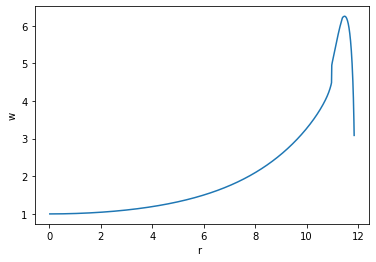

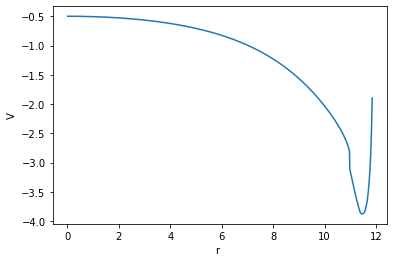

In [10]:
r_arr = r_arr/km2cm

# plt.figure()
# plt.plot(r_arr, p/p_c)
# plt.xlabel("r")
# plt.ylabel("P/Pc")

# plt.figure()
# plt.plot(r_arr, m/msun)
# plt.xlabel("r ")
# plt.ylabel("M/Msun")
# plt.show()

# plt.figure()
# plt.plot(r_arr, v)
# plt.xlabel("r ")
# plt.ylabel("v")
# plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -u*np.exp(v))
plt.xlabel("r ")
plt.ylabel("V")
plt.show()

<IPython.core.display.Javascript object>


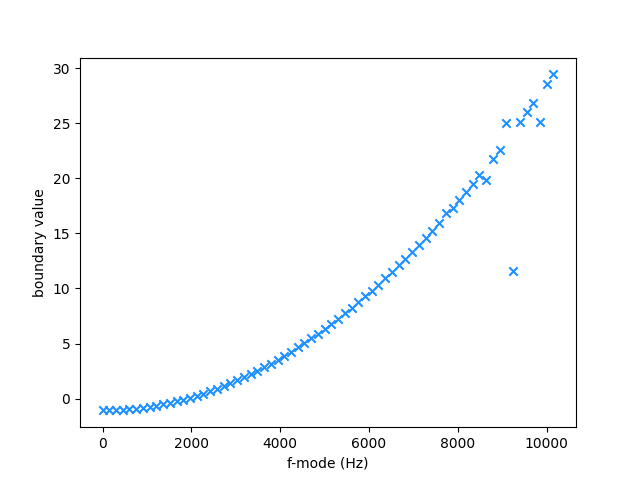

0.0039478417604357436
0.003950474093445813
0.003950474093445813
0.003953107303753953
0.003953107303753953
0.004024552318129604
0.004024552318129604
0.004096637180865869
0.004096637180865869
0.0041693618919627536
0.0041693618919627536
0.004931800662765489
0.004931800662765489
0.0045345569869997574
0.0045345569869997574
0.004241174555741159
0.004241174555741159
0.004313600397134062
0.004313600397134062
0.004386639416141463
0.004460291612763361
0.004609435538850648
0.004761032175395928
0.004915081522399196
0.005071583579860455
0.006771503229662485
0.008716693925263502
0.010907155666663506
0.013342888453862499
0.05119012384479674
0.05119012384479674
0.11356446381562971
0.11356446381562971
0.20046590836636147
0.20046590836636147
0.3118944574969919
0.3118944574969919
1.0187349592213522
1.0187349592213522
1.0187349592213522
1.0187349592213522
1.0187349592213522
1.0187349592213522
2.132104909504246
3.652004308345674
5.578433155745635
12.570993751761259
12.570993751761259
12.570993751761259
12.

4746770150.931274
4746800836.796319
4746831522.760549
4746862208.823961
4746908071.448024
4746908071.448024
4746908071.448024
4746908071.448024
4746908071.448024
4746908071.448024
4746953934.293639
4746999797.360809
4746999797.360809
4747045660.649533
4747091524.159808
4747137387.891639
4747137387.891639
4747183251.845024
4747229116.019962
4747299357.608745
4747299357.608745
4747299357.608745
4747299357.608745
4747299357.608745
4747299357.608745
4747299357.608745
4747369599.717182
4747369599.717182
4747439842.345278
4747510085.493026
4747580329.160429
4747662580.162145
4747744831.876344
4747827084.303032
4747909337.4422035
4747991591.293862
4748073845.858008
4748056057.613957
4748004484.52287
4748004484.52287
4748004484.52287
4748004484.52287
4748004484.52287
4748004484.52287
4748017377.769384
4748030271.033403
4748056057.613957
4748056057.613957
4748056057.613957
4748056057.613957
4748056057.613957
4748056057.613957
4748081844.264538
4748107630.985141
4748133417.775767
4748133417.7757

5116766114.775564
5116766114.775564
5116766114.775564
5116766114.775564
5116766114.775564
5116766114.775564
5117241032.07946
5117715971.422274
5118190932.804006
5119605698.986165
5119605698.986165
5119605698.986165
5119605698.986165
5119605698.986165
5119605698.986165
5119605698.986165
5121020660.675567
5122435817.872206
5122435817.872206
5123851170.576085
5125266718.787206
5127141594.486943
5127141594.486943
5127141594.486943
5127141594.486943
5127141594.486943
5127141594.486943
5127141594.486943
5129016813.04846
5130892374.471751
5130892374.471751
5130421993.353532
5131827366.118617
5133232931.34371
5134638689.028813
5136044639.173926
5137450781.779053
5138857116.844188
5140263644.369332
5141993975.342075
5143724597.500411
5145455510.844342
5147186715.373868
5148918211.088986
5148603104.375671
5148603104.375671
5148603104.375671
5148603104.375671
5148603104.375671
5148603104.375671
5148603104.375671
5150019688.229727
5150019688.229727
5151436466.936031
5152853440.494587
5154270608.90

5527417692.8078985
5527417692.8078985
5527417692.8078985
5527678670.37018
5527939654.093358
5527939654.093358
5528200643.977429
5528461640.022398
5528830465.616914
5528830465.616914
5528830465.616914
5528830465.616914
5528830465.616914
5528830465.616914
5528830465.616914
5529199303.513928
5529199303.513928
5529568153.713442
5529568153.713442
5529937016.215453
5529869800.82701
5530171456.168027
5530473119.736497
5530774791.532415
5531076471.555787
5531378159.806606
5531679856.28488
5531981560.990603
5532283273.923776
5532227323.935352
5532227323.935352
5532227323.935352
5532227323.935352
5532227323.935352
5532227323.935352
5532227323.935352
5532473092.339093
5532473092.339093
5532718866.201825
5532964645.52355
5533210430.304266
5533517702.495334
5533824983.217941
5534132272.472083
5534439570.257762
5534370125.071478
5534607982.782121
5534845845.604013
5535083713.537152
5535321586.58154
5535559464.737174
5535797348.004056
5536035236.382189
5535992251.39325
5536187158.213446
5536382068.46

1.0897579944757245e+18
1.0897673639919058e+18
1.0897673639919058e+18
1.0897638137396271e+18
1.0897591583272623e+18
1.0897591583272623e+18
1.0897591583272623e+18
1.0897591583272623e+18
1.0897591583272623e+18
1.0897591583272623e+18
1.0897603221794216e+18
1.0897614860322022e+18
1.0897626498856045e+18
1.0897638137396282e+18
1.0897661414495396e+18
1.0897661414495396e+18
1.0897661414495396e+18
1.0897661414495396e+18
1.0897661414495396e+18
1.0897661414495396e+18
1.0897684691619369e+18
1.0897707968768202e+18
1.0897731245941894e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897786880330853e+18
1.0897842514861825e+18
1.0897842514861825e+18
1.0897898149534804e+18
1.0897953784349796e+18
1.0897953784349796e+18
1.0898030446627203e+18
1.0898107109174249e+18
1.089818377199094e+18
1.0898260435077272e+18
1.0898337098433245e+18
1.0898422825425492e+18
1.0898422825425492e+18
1.0898422825425492e+18
1.0898422825

1.0990128663987022e+18
1.0990128663987022e+18
1.0990128663987022e+18
1.0990128663987022e+18
1.0991172856343574e+18
1.0991172856343574e+18
1.0992217098303086e+18
1.0993261389865563e+18
1.0997593556519562e+18
1.0997593556519562e+18
1.0997593556519562e+18
1.0997593556519562e+18
1.0997593556519562e+18
1.0997593556519562e+18
1.1001926576604145e+18
1.1006260450119306e+18
1.101059517706505e+18
1.101787400438717e+18
1.101787400438717e+18
1.101787400438717e+18
1.101787400438717e+18
1.101787400438717e+18
1.101787400438717e+18
1.101787400438717e+18
1.1025155236839133e+18
1.1025155236839133e+18
1.1032438874420942e+18
1.1032438874420942e+18
1.1031130601904122e+18
1.1037107585781478e+18
1.1043086188471205e+18
1.1049066409973299e+18
1.105676394322561e+18
1.1054683403994072e+18
1.1060301825402627e+18
1.1065921674198957e+18
1.1071542950383064e+18
1.1070426989163592e+18
1.1070426989163592e+18
1.1070426989163592e+18
1.1070426989163592e+18
1.1070426989163592e+18
1.1070426989163592e+18
1.1070426989163592e+

1.2683534470219026e+18
1.2682917513124616e+18
1.2682917513124616e+18
1.2682917513124616e+18
1.2682917513124616e+18
1.2682917513124616e+18
1.2682917513124616e+18
1.2683071750991455e+18
1.268322598979614e+18
1.2683380229538668e+18
1.2683688711837245e+18
1.2683688711837245e+18
1.2683688711837245e+18
1.2683688711837245e+18
1.2683688711837245e+18
1.2683688711837245e+18
1.2683997197887196e+18
1.268430568768852e+18
1.268461418124122e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2685454984637071e+18
1.2686295815898447e+18
1.2686295815898447e+18
1.268713667502536e+18
1.268713667502536e+18
1.268797756201779e+18
1.268881847687575e+18
1.2689659419599242e+18
1.2689659419599242e+18
1.2689431681653686e+18
1.2688941116646008e+18
1.2688941116646008e+18
1.2688941116646008e+18
1.2688941116646008e+18
1.2688941116646008e+18
1.2688941116646008e+18
1.2689063757008934e+18
1.2689186397964524e+18
1.2689309039512778

4.3591625085214285e+18
4.3591625085214285e+18
4.3591625085214285e+18
4.3591625085214285e+18
4.3591625085214285e+18
4.3591625085214285e+18
4.3591625085214285e+18
4.359192414056479e+18
4.359192414056479e+18
4.3592223196941123e+18
4.3592522254343265e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593340845731277e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.3593074911242245e+18
4.359263278544281e+18
4.359263278544281e+18
4.359263278544281e+18
4.359263278544281e+18
4.359263278544281e+18
4.359263278544281e+18
4.3592743316682476e+18
4.359285384806228e+18
4.3592964379582213e+18
4.3593074911242266e+18
4.359329597498275e+18
4.359329597498275e+18
4.359329597498275e+18
4.359329597498275e+18
4.359329597498275e+18
4.359329597498275e+18
4.3593517039283743e+18
4.3593738104145244e+18
4.3593959169567273e+18
4.3

4.4960894155198244e+18
4.499744643137325e+18
4.5034013559633577e+18
4.5077718745522053e+18
4.512144512890986e+18
4.516519270979701e+18
4.5208961488183485e+18
4.5208961488183485e+18
4.519895853350735e+18
4.517194486517342e+18
4.517194486517342e+18
4.517194486517342e+18
4.517194486517342e+18
4.517194486517342e+18
4.517194486517342e+18
4.517869752523266e+18
4.5185450689974733e+18
4.519220435939964e+18
4.5205713212297933e+18
4.5205713212297933e+18
4.5205713212297933e+18
4.5205713212297933e+18
4.5205713212297933e+18
4.5205713212297933e+18
4.521922408392755e+18
4.52327369742885e+18
4.5246251883380767e+18
4.527512955970589e+18
4.527512955970589e+18
4.527512955970589e+18
4.527512955970589e+18
4.527512955970589e+18
4.527512955970589e+18
4.527512955970589e+18
4.530401644844248e+18
4.530401644844248e+18
4.5332912549590513e+18
4.5361817863149993e+18
4.539073238912094e+18
4.5439888580421284e+18
4.5439888580421284e+18
4.5439888580421284e+18
4.5439888580421284e+18
4.5439888580421284e+18
4.54398885804

5.061035189711521e+18
5.061528857244297e+18
5.062022548852759e+18
5.062516264536902e+18
5.063143073975838e+18
5.063769922216202e+18
5.064396809258e+18
5.065023735101227e+18
5.065650699745887e+18
5.066277703191979e+18
5.066904745439499e+18
5.066757579780607e+18
5.067237479095055e+18
5.067106852537205e+18
5.067106852537205e+18
5.067106852537205e+18
5.067106852537205e+18
5.067106852537205e+18
5.067106852537205e+18
5.067106852537205e+18
5.067456137331803e+18
5.067456137331803e+18
5.067805434164402e+18
5.068154743035e+18
5.068504063943598e+18
5.069093190239202e+18
5.069093190239202e+18
5.069093190239202e+18
5.069093190239202e+18
5.069093190239202e+18
5.069093190239202e+18
5.069093190239202e+18
5.069682350770712e+18
5.069682350770712e+18
5.070271545538121e+18
5.070271545538121e+18
5.070065921318716e+18
5.070065921318716e+18
5.070065921318716e+18
5.070065921318716e+18
5.070065921318716e+18
5.070065921318716e+18
5.070065921318716e+18
5.070449506376586e+18
5.070449506376586e+18
5.07035917085254

9.811048956547408e+18
9.811048956547408e+18
9.811102887699665e+18
9.81115681900015e+18
9.811210750448865e+18
9.811197449695562e+18
9.811164945132505e+18
9.811164945132505e+18
9.811164945132505e+18
9.811164945132505e+18
9.811164945132505e+18
9.811164945132505e+18
9.811173071268223e+18
9.811181197407306e+18
9.811189323549755e+18
9.811205575844747e+18
9.811205575844747e+18
9.811205575844747e+18
9.811205575844747e+18
9.811205575844747e+18
9.811205575844747e+18
9.811221828153199e+18
9.81123808047511e+18
9.811267264745648e+18
9.811267264745648e+18
9.811267264745648e+18
9.811267264745648e+18
9.811267264745648e+18
9.811267264745648e+18
9.811267264745648e+18
9.811296449059594e+18
9.811296449059594e+18
9.811289211772527e+18
9.811289211772527e+18
9.811311158823948e+18
9.811333105899921e+18
9.811329043191128e+18
9.811329043191128e+18
9.811329043191128e+18
9.811329043191128e+18
9.811329043191128e+18
9.811329043191128e+18
9.811329043191128e+18
9.811346927574604e+18
9.811346927574604e+18
9.8113648119

1.0351495522627404e+19
1.0353206914309698e+19
1.035662791903059e+19
1.035662791903059e+19
1.035662791903059e+19
1.035662791903059e+19
1.035662791903059e+19
1.035662791903059e+19
1.035662791903059e+19
1.0360049488858518e+19
1.0363471623793482e+19
1.0363471623793482e+19
1.036689432383548e+19
1.0370317588984517e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0375834589458862e+19
1.0381353057062849e+19
1.0381353057062849e+19
1.0386872991796474e+19
1.0386872991796474e+19
1.0392394393659738e+19
1.0397917262652643e+19
1.0397917262652643e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.0395186716670233e+19
1.03929528282552e+19
1.03929528282552e+19
1.03929528282552e+19
1.03929528282552e+19
1.03929528282552e+19
1.03929528282552e+19
1.0393511277853979e+19
1.0394069742456078e+19
1.0394628222061496e+19
1.039574

1.1453039938939492e+19
1.1453039938939492e+19
1.1453040071964264e+19
1.1453039972195684e+19
1.1453039972195684e+19
1.1453040005451878e+19
1.1453040005451878e+19
1.145304003870807e+19
1.145304003870807e+19
1.1453040105220458e+19
1.145304005533617e+19
1.1453040042865097e+19
1.1453040039747328e+19
1.1453040038967884e+19
1.1453040038967884e+19
1.14530400392277e+19
1.14530400392277e+19
1.1453040040266949e+19
14501255.377096515
14510924.491395656
14510924.491395656
14520596.828195635
14520596.828195635
14783029.433591468
14783029.433591468
15047812.33695844
15047812.33695844
15314945.538296547
15314945.538296547
18115543.940090057
18115543.940090057
16656384.141197916
16656384.141197916
15578728.597485142
15578728.597485142
15844763.987369576
15844763.987369576
16113051.707949849
16383591.759225963
16931428.853865713
17488275.27128882
18054131.01149528
18628996.074485093
24873159.45746802
32018255.11878676
40064283.05844131
49011243.276431695
188032120.76480526
188032120.76480526
417146226.0

1.7441974206959944e+19
1.7442007619474561e+19
1.7442007619474561e+19
1.7442007619474561e+19
1.7442007619474561e+19
1.7442007619474561e+19
1.7442007619474561e+19
1.7442041032021178e+19
1.7442041032021178e+19
1.7442074444599802e+19
1.7442117945164046e+19
1.7442161445782542e+19
1.744220494645528e+19
1.744224844718226e+19
1.7442304426063892e+19
1.744236040503535e+19
1.7442416384096635e+19
1.744247236324775e+19
1.744247236324775e+19
1.7442461176099434e+19
1.7442505968159752e+19
1.744255076027758e+19
1.7442595552452917e+19
1.7442640344685773e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442713473143845e+19
1.7442786601755214e+19
1.7442786601755214e+19
1.744285973051988e+19
1.744285973051988e+19
1.7442845934901408e+19
1.7442905268148515e+19
1.744296460149654e+19
1.744296460149654e+19
1.7442944316550836e+19
1.7442944316550836e+19
1.7442944316550836e+19
1.7442944316550836e+19
1.7442944316550836e+1

1.8993148412136215e+19
1.900031089963865e+19
1.9007474737405805e+19
1.901463992543767e+19
1.9021806463734264e+19
1.9028974352295567e+19
1.90361435911216e+19
1.9043314180212343e+19
1.9050486119567815e+19
1.905855271479202e+19
1.9066621017484095e+19
1.9074691027644035e+19
1.908276274527185e+19
1.909083617036752e+19
1.910142042852684e+19
1.910142042852684e+19
1.910142042852684e+19
1.910142042852684e+19
1.910142042852684e+19
1.910142042852684e+19
1.910142042852684e+19
1.9112007619912237e+19
1.9112007619912237e+19
1.912259774452371e+19
1.9133190802361254e+19
1.914378679342488e+19
1.914378679342488e+19
1.9154385717714575e+19
1.915168506436974e+19
1.915958496429792e+19
1.916748649320942e+19
1.917538965110422e+19
1.9183294437982335e+19
1.9195783391618875e+19
1.9208276409291747e+19
1.922077349100097e+19
1.9233274636746535e+19
1.9245779846528442e+19
1.9258289120346694e+19
1.9270802458201276e+19
1.9270802458201276e+19
1.9267621432576414e+19
1.9267621432576414e+19
1.9260155401943843e+19
1.92601554

2.0360731837023556e+19
2.0360731837023556e+19
2.0360731837023556e+19
2.0360731837023556e+19
2.0360731837023556e+19
2.0360731940665074e+19
2.0360731940665074e+19
2.036073204430659e+19
2.0360731966575444e+19
2.0360731966575444e+19
2.0360731992485827e+19
2.0360731992485827e+19
2.0360732044306584e+19
2.0360732005441016e+19
2.0360732005441016e+19
2.0360732018396205e+19
2.0360732008679805e+19
2.0360732006250713e+19
2.0360732006250713e+19
2.0360732007060414e+19
2.0360732007060414e+19
2.0360732008679813e+19
22658061.98513172
22673169.876513127
22673169.876513127
22688282.803018864
22688282.803018864
23098331.042660926
23098331.042660926
23512051.598645866
23512051.598645866
23929444.470973678
23929444.470973678
28305350.593109958
28305350.593109958
26025428.454663333
26025428.454663333
24341602.78074062
24341602.78074062
24757280.333993055
24757280.333993055
25176477.130730987
25599193.170954414
26455182.98185775
27325249.76670307
28209393.525490366
29107614.25821965
38864055.15232136
50028193

2.725513921377607e+19
2.725513921377607e+19
2.725513921377607e+19
2.725513921377607e+19
2.725518999549498e+19
2.725518999549498e+19
2.7255240777261203e+19
2.7255291559074734e+19
2.7255342340935574e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.7255433925590184e+19
2.725552551039866e+19
2.725552551039866e+19
2.7255617095361016e+19
2.7255708680477233e+19
2.7255708680477233e+19
2.7255800265747333e+19
2.7255782256078692e+19
2.7255855831779455e+19
2.725592940757952e+19
2.72560029834789e+19
2.7256076559477584e+19
2.7256176549681783e+19
2.7256276540069392e+19
2.725637653064041e+19
2.7256476521394835e+19
2.725657651233267e+19
2.725672237672144e+19
2.725672237672144e+19
2.725672237672144e+19
2.725672237672144e+19
2.725672237672144e+19
2.725672237672144e+19
2.725672237672144e+19
2.725686824150051e+19
2.725686824150051e+19
2.7257014106669867e+19
2.725715997222953e+19
2.725730583817949e+19
2.7257547338

3.109902391794731e+19
3.1114018074290508e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1110061303077405e+19
3.1121100646504604e+19
3.1132141948228907e+19
3.114318520825032e+19
3.115423042656883e+19
3.1168111758814487e+19
3.1168111758814487e+19
3.118199618291099e+19
3.1178234896779567e+19
3.118835967843234e+19
3.1198486103772807e+19
3.1208614172800975e+19
3.1218743885516845e+19
3.1231443019672617e+19
3.1244144736174703e+19
3.1244144736174703e+19
3.1240658397565186e+19
3.124987513483558e+19
3.1259093231483822e+19
3.1268312687509905e+19
3.1277533502913815e+19
3.1289058514106958e+19
3.1300585648252305e+19
3.1297471717944607e+19
3.1305886052728467e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1314301518458544e+19
3.1322718115134824e+19
3.1322718115134824e+19
3.1331135842757313e+19
3.134163434864453

32627465.69906612
32649220.966933053
32649220.966933053
32670983.48534712
32670983.48534712
33261450.352401465
33261450.352401465
33857205.33172207
33857205.33172207
34458248.42330894
34458248.42330894
40759525.513821974
40759525.513821974
37476452.079848565
37476452.079848565
35051753.77797389
35051753.77797389
35650326.82096033
35650326.82096033
36253967.552268244
36862675.97189766
38095295.87612096
39348186.53363023
40621347.944425456
41914780.10850664
55963993.18004636
72040281.58018214
90143645.30891399
110274084.36624189
110274084.36624189
423067618.01230437
423067618.01230437
938568684.5179728
938568684.5179728
1656777283.8832474
1656777283.8832474
2577693416.1081285
2577693416.1081285
5257781651.621956
5257781651.621956
5257781651.621956
5257781651.621956
5257781651.621956
5257781651.621956
5257781651.621956
8883087906.754625
13453612181.50614
18969354475.8765
34957403084.28421
34957403084.28421
34957403084.28421
34957403084.28421
34957403084.28421
34957403084.28421
55794549768

3.9243313410489e+19
3.9243313410489e+19
3.924350993304726e+19
3.924350993304726e+19
3.9243706456097595e+19
3.924390297964001e+19
3.924390297964001e+19
3.924409950367448e+19
3.924408496769396e+19
3.9243939377217044e+19
3.9243939377217044e+19
3.9243939377217044e+19
3.9243939377217044e+19
3.9243939377217044e+19
3.9243939377217044e+19
3.924397577481096e+19
3.924401217242175e+19
3.924404857004942e+19
3.924412136535539e+19
3.924412136535539e+19
3.924412136535539e+19
3.924412136535539e+19
3.924412136535539e+19
3.924412136535539e+19
3.9244194160728875e+19
3.924426695616986e+19
3.924433975167838e+19
3.924448565068637e+19
3.924448565068637e+19
3.924448565068637e+19
3.924448565068637e+19
3.924448565068637e+19
3.924448565068637e+19
3.924448565068637e+19
3.924463154996556e+19
3.924463154996556e+19
3.924477744951596e+19
3.9244923349337555e+19
3.924506924943037e+19
3.924506924943037e+19
3.924521514979438e+19
3.924521514979438e+19
3.9245183268276126e+19
3.924509205318627e+19
3.924509205318627e+19
3.92

4.259041735825683e+19
4.259041735825683e+19
4.259041735825683e+19
4.259041735825683e+19
4.259221383998713e+19
4.259221383998713e+19
4.259401035960481e+19
4.259401035960481e+19
4.259580691710987e+19
4.259940014578213e+19
4.259940014578213e+19
4.259940014578213e+19
4.259940014578213e+19
4.259940014578213e+19
4.259940014578213e+19
4.259940014578213e+19
4.26029935260039e+19
4.26029935260039e+19
4.260658705777518e+19
4.26135678018347e+19
4.26135678018347e+19
4.26135678018347e+19
4.26135678018347e+19
4.26135678018347e+19
4.26135678018347e+19
4.26135678018347e+19
4.262054911771655e+19
4.262753100542073e+19
4.262753100542073e+19
4.263451346494725e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2644933739046584e+19
4.2655355286396576e+19
4.2655355286396576e+19
4.266577810699724e+19
4.2676202200848564e+19
4.269530756319892e+19
4.269530756319892e+19
4.269530756319892e+19
4.269530756319892e+19
4.2695307

4.581108107846083e+19
4.5811116685851435e+19
4.5811116685851435e+19
4.581112642091799e+19
4.581112642091799e+19
4.581112642091799e+19
4.581112642091799e+19
4.581112642091799e+19
4.581112642091799e+19
4.5811136155985584e+19
4.581114246705343e+19
4.581114246705343e+19
4.581113773375251e+19
4.581113773375251e+19
4.581113773375251e+19
4.581113773375251e+19
4.581113773375251e+19
4.581113773375251e+19
4.581113931151945e+19
4.5811140889286435e+19
4.581114167816994e+19
4.581114167816994e+19
4.581114167816994e+19
4.581114167816994e+19
4.581114167816994e+19
4.581114167816994e+19
4.581114207261169e+19
4.581114177678036e+19
4.581114177678036e+19
4.581114187539079e+19
4.5811141801432965e+19
4.5811141801432965e+19
4.581114182608557e+19
4.581114182608557e+19
4.581114187539079e+19
4.581114183841188e+19
4.581114185073819e+19
4.58111418630645e+19
4.581114185381977e+19
4.581114185690134e+19
4.581114186546615e+19
44409466.518899746
44439077.76265546
44439077.76265546
44468698.875180416
44468698.875180416


5.341999993752809e+19
5.341999993752809e+19
5.341999993752809e+19
5.342009140023328e+19
5.342009140023328e+19
5.342018286301676e+19
5.342027432587854e+19
5.342039758593837e+19
5.342039758593837e+19
5.342052084614039e+19
5.3420644106484605e+19
5.342076736697103e+19
5.342089062759967e+19
5.342101388837049e+19
5.342113714928353e+19
5.342126041033878e+19
5.34214210976445e+19
5.34214210976445e+19
5.34214210976445e+19
5.34214210976445e+19
5.34214210976445e+19
5.34214210976445e+19
5.34214210976445e+19
5.3421581785191875e+19
5.3421581785191875e+19
5.342174247298093e+19
5.342190316101165e+19
5.342206384928404e+19
5.342229496761921e+19
5.342229496761921e+19
5.342229496761921e+19
5.342229496761921e+19
5.342229496761921e+19
5.342229496761921e+19
5.342252608645431e+19
5.342275720578935e+19
5.342298832562433e+19
5.342321944595925e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.3423547077136744e+19
5.34238

6.10659568675212e+19
6.109354649851097e+19
6.1121142360597996e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.1114810181829796e+19
6.113607756493025e+19
6.1157348647812325e+19
6.117862343047601e+19
6.1199901912921326e+19
6.122610854252898e+19
6.122610854252898e+19
6.122099882106846e+19
6.12420993648655e+19
6.126320354431246e+19
6.128431135940933e+19
6.1305422810156106e+19
6.13291603543976e+19
6.135290249335454e+19
6.1376649227026915e+19
6.140040055541472e+19
6.142415647851795e+19
6.144791699633663e+19
6.144314462027742e+19
6.146213569649973e+19
6.1481129707184865e+19
6.150012665233287e+19
6.1519126531943694e+19
6.153812934601738e+19
6.153812934601738e+19
6.153812934601738e+19
6.153812934601738e+19
6.153812934601738e+19
6.153812934601738e+19
6.153812934601738e+19
6.153418515383618e+19
6.153418515383618e+19
6.154924561852421e+19
6.156430792600778e+19
6.157937207628689e+19
6.1594438069361525e+1

58004064.44463259
58042740.26368034
58042740.26368034
58081428.97251877
58081428.97251877
59131142.073895834
59131142.073895834
60190256.21204087
60190256.21204087
61258771.38695389
61258771.38695389
72460980.15832242
72460980.15832242
66624437.26537856
66624437.26537856
62313886.21437381
62313886.21437381
63378010.21592625
63378010.21592625
64451143.39161119
65533285.74142862
67724597.96346098
69951946.88202333
72215332.4971157
74514754.80873805
99490996.23411146
128070907.31248444
160254488.0438571
196041738.42822933
752116073.1869313
752116073.1869313
1668557373.2455952
1668557373.2455952
2945365638.604222
2945365638.604222
4582540869.262811
4582540869.262811
8795521288.73942
8795521288.73942
8795521288.73942
8795521288.73942
8795521288.73942
8795521288.73942
8795521288.73942
14369875142.317514
21305602429.997093
29602703151.778156
51576120678.86265
51576120678.86265
51576120678.86265
51576120678.86265
51576120678.86265
51576120678.86265
79610412251.05162
113705577868.34511
15386161

6.976591432424786e+19
6.976591432424786e+19
6.976633155366982e+19
6.976674878433938e+19
6.976664889710826e+19
6.976696624126843e+19
6.976728358615034e+19
6.976760093175402e+19
6.976791827807942e+19
6.976829576376425e+19
6.9768673250470306e+19
6.976905073819755e+19
6.976905073819755e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.9768895807080284e+19
6.97687177617639e+19
6.97687177617639e+19
6.97687177617639e+19
6.97687177617639e+19
6.97687177617639e+19
6.97687177617639e+19
6.97687622730717e+19
6.9768806784393716e+19
6.97688512957299e+19
6.9768940318444904e+19
6.9768940318444904e+19
6.9768940318444904e+19
6.9768940318444904e+19
6.9768940318444904e+19
6.9768940318444904e+19
6.97690293412167e+19
6.976911836404529e+19
6.976911836404529e+19
6.976926280265017e+19
6.976926280265017e+19
6.976926280265017e+19
6.976926280265017e+19
6.976926280265017e+19
6.976926280265017e+19
6.976926280265017e+19
6.97

8.035124603124421e+19
8.03777232422122e+19
8.03777232422122e+19
8.03777232422122e+19
8.03777232422122e+19
8.03777232422122e+19
8.03777232422122e+19
8.03777232422122e+19
8.037251388094013e+19
8.037251388094013e+19
8.039378454491459e+19
8.041505802316762e+19
8.04363343156992e+19
8.04576134225094e+19
8.048254672418447e+19
8.04777651044472e+19
8.049791930969776e+19
8.0518076038261e+19
8.053823529013697e+19
8.055839706532564e+19
8.057856136382705e+19
8.059872818564112e+19
8.061889753076797e+19
8.063906939920748e+19
8.065924379095972e+19
8.067942070602467e+19
8.067526265858505e+19
8.067526265858505e+19
8.067526265858505e+19
8.067526265858505e+19
8.067526265858505e+19
8.067526265858505e+19
8.067526265858505e+19
8.069128311672026e+19
8.069128311672026e+19
8.070730516536528e+19
8.072332880452018e+19
8.073935403418488e+19
8.07580593340996e+19
8.07767668005397e+19
8.077301271635034e+19
8.078796748287743e+19
8.080292363368084e+19
8.081788116876062e+19
8.083284008811672e+19
8.084780039174916e+19
8.

73411259.47626464
73460208.47000769
73460208.47000769
73509173.77736214
73509173.77736214
74837714.48564965
74837714.48564965
76178153.35928348
76178153.35928348
77530490.39826357
77530490.39826357
91708259.88211086
91708259.88211086
84321398.82572329
84321398.82572329
78865867.65354046
78865867.65354046
80212647.1239249
80212647.1239249
81570828.80941685
82940412.71001631
85713787.15653777
88532770.4634893
91397362.63087086
94307563.65868248
125918061.2604515
162089444.9052257
202821714.593005
248114870.32378954
951895159.9969176
951895159.9969176
2111764053.9705603
2111764053.9705603
3727721552.2447176
3727721552.2447176
5799767654.81939
5799767654.81939
11073895391.193256
11073895391.193256
11073895391.193256
11073895391.193256
11073895391.193256
11073895391.193256
11073895391.193256
18038893943.889545
26694763312.908245
37041503498.24937
64229585943.71815
64229585943.71815
64229585943.71815
64229585943.71815
64229585943.71815
64229585943.71815
98853294541.5299
140912629291.68466
19

8.829916158693864e+19
8.829935384637109e+19
8.829970652224497e+19
8.829970652224497e+19
8.829970652224497e+19
8.829970652224497e+19
8.829970652224497e+19
8.829970652224497e+19
8.829970652224497e+19
8.830005919882317e+19
8.830005919882317e+19
8.830041187610572e+19
8.830076455409253e+19
8.830111723278369e+19
8.830111723278369e+19
8.830103124596336e+19
8.830129793823695e+19
8.830156463091322e+19
8.830183132399228e+19
8.830209801747407e+19
8.830240826046718e+19
8.830271850400529e+19
8.830302874808846e+19
8.830333899271658e+19
8.830364923788973e+19
8.830364923788973e+19
8.830354034032712e+19
8.830354034032712e+19
8.830354034032712e+19
8.830354034032712e+19
8.830354034032712e+19
8.830354034032712e+19
8.830354034032712e+19
8.83033792622203e+19
8.83033792622203e+19
8.83033792622203e+19
8.83033792622203e+19
8.83033792622203e+19
8.83033792622203e+19
8.830341953173324e+19
8.830345980125531e+19
8.830350007078661e+19
8.830358060987674e+19
8.830358060987674e+19
8.830358060987674e+19
8.83035806098767

1.020306659768547e+20
1.020306659768547e+20
1.020306659768547e+20
1.020306659768547e+20
1.020306659768547e+20
1.020306659768547e+20
1.020306659768547e+20
1.0205749612696412e+20
1.0205749612696412e+20
1.0208432980425977e+20
1.0208432980425977e+20
1.0211116700874169e+20
1.021064608035234e+20
1.0212859420143152e+20
1.0215072999798427e+20
1.0217286819318155e+20
1.0219500878702338e+20
1.0222263886417288e+20
1.0221675069748593e+20
1.0223849492048994e+20
1.0226024145603543e+20
1.0228199030412239e+20
1.0230374146475083e+20
1.0232549493792075e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0232100627932694e+20
1.0233827255058812e+20
1.023555402785344e+20
1.023555402785344e+20
1.0237280946316583e+20
1.0239008010448234e+20
1.0240735220248399e+20
1.0242462575717071e+20
1.0244190076854257e+20
1.024591772365995e+20
1.0247645516134159e+20
1.0247239657221544e+20
1.0248561676055904e+20
1.0249883780163042e+20

90631051.61379592
90691482.38163753
90691482.38163753
90751933.2897106
90751933.2897106
92392104.59807459
92392104.59807459
94046964.97791484
94046964.97791484
95716514.42923139
95716514.42923139
113219907.87359144
113219907.87359144
104100339.6977879
104100339.6977879
97365125.90668495
97365125.90668495
99027814.1722674
99027814.1722674
100704579.22597869
102395421.06781884
105819335.11588576
109299556.31646818
112836084.66956604
116428920.17517938
155454168.61966327
200110132.3156937
250396811.26327065
306314205.46239406
1175177486.2886863
1175177486.2886863
2607112292.269628
2607112292.269628
4602118623.40522
4602118623.40522
7160196479.695463
7160196479.695463
14168570260.000692
14168570260.000692
14168570260.000692
14168570260.000692
14168570260.000692
14168570260.000692
14168570260.000692
23545571473.894554
35291200121.37703
49405456202.44812
88522865306.68993
88522865306.68993
88522865306.68993
88522865306.68993
88522865306.68993
88522865306.68993
138966766563.19003
200737159971

1.0901206522342452e+20
1.0901251851664645e+20
1.090129718108108e+20
1.0901342510591756e+20
1.090138784019668e+20
1.090138784019668e+20
1.0901386360886837e+20
1.0901351280643716e+20
1.0901351280643716e+20
1.0901351280643716e+20
1.0901351280643716e+20
1.0901351280643716e+20
1.0901351280643716e+20
1.0901360050699203e+20
1.0901368820758215e+20
1.0901377590820759e+20
1.0901395130956431e+20
1.0901395130956431e+20
1.0901395130956431e+20
1.0901395130956431e+20
1.0901395130956431e+20
1.0901395130956431e+20
1.0901412671106212e+20
1.0901430211270107e+20
1.0901430211270107e+20
1.0901447751448109e+20
1.090147760327544e+20
1.090147760327544e+20
1.090147760327544e+20
1.090147760327544e+20
1.090147760327544e+20
1.090147760327544e+20
1.090147760327544e+20
1.0901507455143641e+20
1.0901537307052712e+20
1.0901537307052712e+20
1.0901567159002658e+20
1.0901597010993476e+20
1.0901647841060753e+20
1.0901647841060753e+20
1.0901647841060753e+20
1.0901647841060753e+20
1.0901647841060753e+20
1.0901647841060753e+2

1.1513339878843051e+20
1.1513339878843051e+20
1.151865497952112e+20
1.1523971306766659e+20
1.1529288860579661e+20
1.1534607640960131e+20
1.1541175290688673e+20
1.1547744809650599e+20
1.1547744809650599e+20
1.155431619784591e+20
1.155431619784591e+20
1.1551404777519656e+20
1.1548476756831828e+20
1.1548476756831828e+20
1.1548476756831828e+20
1.1548476756831828e+20
1.1548476756831828e+20
1.1548476756831828e+20
1.1549208727209348e+20
1.1549940720783155e+20
1.1550672737553259e+20
1.1552136840682335e+20
1.1552136840682335e+20
1.1552136840682335e+20
1.1552136840682335e+20
1.1552136840682335e+20
1.1552136840682335e+20
1.1553601036596578e+20
1.1555065325295983e+20
1.1556529706780557e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1560565965448408e+20
1.1564602928849437e+20
1.1568640596983631e+20
1.1568640596983631e+20
1.1572678969851003e+20
1.1576718047451546e+20
1.1580757829785256e+20
1.158479831685

109663440.85722639
109736561.99856979
109736561.99856979
109809707.50956404
109809707.50956404
111794312.41117056
111794312.41117056
113796691.06793499
113796691.06793499
115816843.47985731
115816843.47985731
136995924.1327641
136995924.1327641
125961259.88157225
125961259.88157225
117811660.97380719
117811660.97380719
119823511.36095363
119823511.36095363
121852394.64129663
123898310.81483617
128041241.84150492
132252304.44095993
136531498.6132012
140878824.35822868
188099318.31174666
242132969.54388836
302979778.05465376
370639743.84404284
370639743.84404284
1421963052.0622363
1421963052.0622363
3154602088.142798
3154602088.142798
5568556852.085728
5568556852.085728
8663827343.891026
8663827343.891026
17690501420.65655
17690501420.65655
17690501420.65655
17690501420.65655
17690501420.65655
17690501420.65655
17690501420.65655
29905340309.190247
45308344009.4921
63899512521.56212
117872357786.46086
117872357786.46086
117872357786.46086
117872357786.46086
117872357786.46086
117872357786

1.3191662036193827e+20
1.3191651048536873e+20
1.319169331316496e+20
1.3191735577860746e+20
1.3191777842624243e+20
1.3191820107455442e+20
1.319188240407305e+20
1.3191944700837752e+20
1.3192006997749545e+20
1.3192069294808434e+20
1.3192131592014415e+20
1.319219388936749e+20
1.3192183367256392e+20
1.3192235142599968e+20
1.3192286918045142e+20
1.3192338693591921e+20
1.3192390469240301e+20
1.319245664230221e+20
1.3192522815530076e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192588988923907e+20
1.3192655162483697e+20
1.3192655162483697e+20
1.3192721336209452e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.3192809504038524e+20
1.319289767216221e+20
1.319289767216221e+20
1.3192985840580511e+20
1.3193074009293432e+20
1.3193233781883416e+20
1.3193233781883416e+20
1.3193233781883416e+20
1.319323378188341

1.4311348313039657e+20
1.4317093385673392e+20
1.432283961121165e+20
1.432858698965443e+20
1.4334335521001736e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4334208002150341e+20
1.4339830116973565e+20
1.4339830116973565e+20
1.4345453334124102e+20
1.4351077653601945e+20
1.4356703075407109e+20
1.4363725118903093e+20
1.4370748879264e+20
1.4377774356489819e+20
1.4384801550580557e+20
1.4391830461536218e+20
1.4390402692603419e+20
1.439600492489803e+20
1.440160824746439e+20
1.4407212660302499e+20
1.4412818163412356e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4420334154745066e+20
1.4427852105285224e+20
1.4427852105285224e+20
1.4435372015032823e+20
1.444289388398787e+20
1.4450417712150358e+20
1.4459446542855825e+20
1.4468478193352663e+20
1.4477512663640878e+20
1.4477512663640878e+20
1.4486549953720472e

130508427.20655605
130595447.32080454
130595447.32080454
130682496.43692252
130682496.43692252
133044337.92493765
133044337.92493765
135427331.62934393
135427331.62934393
137831477.55014136
137831477.55014136
163036308.6596289
163036308.6596289
149904159.37707648
149904159.37707648
140205472.8549072
140205472.8549072
142599738.68998364
142599738.68998364
145014275.05537063
147449081.95106828
152379507.3333953
157391014.8369646
162483604.46177635
167657276.20783046
223853510.33670175
288157956.5898097
360570614.9671545
441091485.4687359
1692251857.317568
1692251857.317568
3754233441.59007
3754233441.59007
6627036238.286241
6627036238.286241
10310660247.40608
10310660247.40608
25685575901.289177
25685575901.289177
25685575901.289177
25685575901.289177
25685575901.289177
25685575901.289177
25685575901.289177
47957926084.43133
77127710796.83252
113194930038.49275
229339425414.12158
229339425414.12158
229339425414.12158
229339425414.12158
229339425414.12158
229339425414.12158
229339425414.1

1.5696168937813728e+20
1.5696168937813728e+20
1.5696168937813728e+20
1.5696168937813728e+20
1.569621997204536e+20
1.5696271006359958e+20
1.5696373075238057e+20
1.5696373075238057e+20
1.5696373075238057e+20
1.5696373075238057e+20
1.5696373075238057e+20
1.5696373075238057e+20
1.5696475144448023e+20
1.5696577213989847e+20
1.5696679283863536e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.5696908911662242e+20
1.569686724621549e+20
1.569686724621549e+20
1.5697055209692827e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697000560323133e+20
1.5697133874996897e+20
1.5697133874996897e+20
1.569726719023678e+20
1.569726719023678e+20
1.5697238075656084e+20
1.5697342276661117e+20
1.5697446478012e+20
1.5697550679708736e+20
1.5697526347286515e+20
1.5697526347286515e+20
1.5697526347286515e+20
1.5697526347286515e

1.724478259980399e+20
1.724478259980399e+20
1.724478259980399e+20
1.724478259980399e+20
1.724478259980399e+20
1.724478259980399e+20
1.724478259980399e+20
1.7256316643188277e+20
1.7256316643188277e+20
1.725353609820941e+20
1.726229181770091e+20
1.7271049758278494e+20
1.727980991994216e+20
1.7290544251827546e+20
1.7301281916796627e+20
1.7312022914849404e+20
1.7322767245985874e+20
1.733351491020604e+20
1.734620873153307e+20
1.7358907199180436e+20
1.7371610313148134e+20
1.7384318073436176e+20
1.739703048004456e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7420894245506777e+20
1.7444774366894093e+20
1.7444774366894093e+20
1.743695810499016e+20
1.743695810499016e+20
1.743695810499016e+20
1.743695810499016e+20
1.743695810499016e+20
1.743695810499016e+20
1.743695810499016e+20
1.7453029367327638e+20
1.7453029367327638e+20
1.7469108032519225e+20
1.7485194100564905e+20
1.7501287571464684e+20
1.751738

153166010.66178498
153268138.34834176
153268138.34834176
153370300.07178608
153370300.07178608
156142181.13937584
156142181.13937584
158938886.6621417
158938886.6621417
161760416.64008358
161760416.64008358
191341061.45418587
191341061.45418587
175929038.18430057
175929038.18430057
164546561.54998505
164546561.54998505
167356496.1593575
167356496.1593575
170190220.4682009
173047734.47651523
178834131.59155685
184715687.50448227
190692402.2152916
196764275.72398475
262716744.69452855
338185093.45345795
423169322.00077283
517669430.3364734
517669430.3364734
1986043902.0546825
1986043902.0546825
4406006352.6114435
4406006352.6114435
7777556782.00676
7777556782.00676
12100695190.24063
12100695190.24063
24375799015.395817
24375799015.395817
24375799015.395817
24375799015.395817
24375799015.395817
24375799015.395817
24375799015.395817
40905813968.23494
61690740048.75802
86730577256.96507
157985709341.09497
157985709341.09497
157985709341.09497
157985709341.09497
157985709341.09497
1579857093

1.8451376115403463e+20
1.8451376115403463e+20
1.8453580887983977e+20
1.8455785792281818e+20
1.8457990828296975e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8462234830353996e+20
1.8466479320261598e+20
1.8466479320261598e+20
1.846544862903229e+20
1.846544862903229e+20
1.8468662707405947e+20
1.8471877065474975e+20
1.847509170323937e+20
1.8478306620699135e+20
1.8482782208075268e+20
1.848725833739654e+20
1.8486409636523868e+20
1.849003742089686e+20
1.8493665561194247e+20
1.849729405741603e+20
1.8500922909562202e+20
1.8506005836321735e+20
1.851108946122471e+20
1.851617378427113e+20
1.8521258805460982e+20
1.8526344524794285e+20
1.853143094227102e+20
1.8537489409588793e+20
1.8543548867089878e+20
1.8542986601124617e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8538588782699138e+20
1.8539688188407893e+

2.149057425727739e+20
2.149057425727739e+20
2.149057425727739e+20
2.149057425727739e+20
2.149057425727739e+20
2.149057425727739e+20
2.149102907850669e+20
2.149102907850669e+20
2.1491483904548802e+20
2.1491938735403726e+20
2.1492393571071456e+20
2.1492848411551996e+20
2.1493303256845353e+20
2.1493758106951523e+20
2.14942129618705e+20
2.1494667821602292e+20
2.1495122686146894e+20
2.1495577555504307e+20
2.1496032429674525e+20
2.149648730865756e+20
2.1496354798179913e+20
2.1496677169102507e+20
2.1496999542442305e+20
2.1497321918199307e+20
2.1497644296373518e+20
2.1497966676964934e+20
2.1498289059973553e+20
2.149861144539938e+20
2.149861144539938e+20
2.149861144539938e+20
2.149861144539938e+20
2.149861144539938e+20
2.149861144539938e+20
2.149861144539938e+20
2.1498546088482007e+20
2.1498546088482007e+20
2.149880311852694e+20
2.149906015010835e+20
2.1499317183226233e+20
2.1499574217880597e+20
2.1499831254071437e+20
2.1500088291798755e+20
2.150034533106255e+20
2.1500301900929463e+20
2.1500301

2.1911838017657717e+20
2.1929633829180532e+20
2.1947436864250076e+20
2.196524712286636e+20
2.198306460502937e+20
2.2000889310739123e+20
2.2018721239995607e+20
2.203656039279882e+20
2.205440676914878e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2085436612959565e+20
2.2116488270425588e+20
2.2147561741546845e+20
2.2147561741546845e+20
2.217865702632335e+20
2.220977412475509e+20
2.220977412475509e+20
2.2201944090505183e+20
2.222524337370573e+20
2.2248554875924988e+20
2.2271878597162962e+20
2.2295214537419653e+20
2.231856269669505e+20
2.2344868106036268e+20
2.2371189008468997e+20
2.2367541668031175e+20
2.2390226727738897e+20
2.241292328515942e+20
2.243563134029276e+20
2.243563134029276e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2417463976369062e+20
2.2422005127487213e+20
2.2422005127487213e+20


2.4941393118880232e+20
2.4941393118880232e+20
2.4941393245308866e+20
2.4941393150487387e+20
2.4941393126782022e+20
2.4941393126782022e+20
2.4941393134683813e+20
2.4941393134683813e+20
2.49413931504874e+20
2.4941393138634703e+20
2.4941393142585596e+20
2.4941393146536487e+20
2.4941393162340067e+20
203918968.88994044
204054937.51932368
204054937.51932368
204190951.46402824
204190951.46402824
207881320.6702655
207881320.6702655
211604740.14190358
211604740.14190358
215361209.87894246
215361209.87894246
254743671.84637624
254743671.84637624
234224733.73390818
234224733.73390818
219070569.38207415
219070569.38207415
222811601.51913658
222811601.51913658
226584306.2901297
230388683.69505355
238092456.4066935
245922919.65405634
253880073.43714204
261963917.7559507
349770340.40879714
450245816.6339345
563390346.4313624
689203929.8010811
2644137709.9742565
2644137709.9742565
5865976847.376502
5865976847.376502
10354721342.007818
10354721342.007818
16110371193.868202
16110371193.868202
3481748668

2.4966905375429303e+20
2.497082112212636e+20
2.4974737175867277e+20
2.497865353665205e+20
2.4989397537986095e+20
2.4989397537986095e+20
2.4989397537986095e+20
2.4989397537986095e+20
2.4989397537986095e+20
2.4989397537986095e+20
2.5000143849467593e+20
2.5000143849467593e+20
2.5010892471096544e+20
2.5010892471096544e+20
2.5009094724195143e+20
2.501804720098986e+20
2.5027001279851738e+20
2.503595696078078e+20
2.5044914243776987e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5061857174152082e+20
2.5078805833551213e+20
2.5078805833551213e+20
2.5095760221974384e+20
2.511272033942159e+20
2.5129686185892833e+20
2.515233172563147e+20
2.5174987464254662e+20
2.519765340176241e+20
2.5220329538154725e+20
2.524301587343159e+20
2.526571240759302e+20
2.5288419140639008e+20
2.5288419140639008e+20
2.531113607256955e+20
2.5333863203384653e+20
2.5333863203384653e+20
2.5333863203384653e+20
2.5356600533084317e+2

2.8188704959915963e+20
2.8196948139137964e+20
2.8205192523453828e+20
2.8213438112863542e+20
2.8221684907367108e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8233015016760407e+20
2.8244347400036663e+20
2.8244347400036663e+20
2.8242116974377222e+20
2.825122039893409e+20
2.826032529043101e+20
2.8269431648867985e+20
2.8278539474245006e+20
2.828764876656208e+20
2.8296759525819207e+20
2.8305871752016377e+20
2.83149854451536e+20
2.8324100605230878e+20
2.8333217232248206e+20
2.8342335326205585e+20
2.8351454887103015e+20
2.836057591494049e+20
2.8369698409718022e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8368026799130408e+20
2.8375478661939095e+20
2.8382931503366554e+20
2.8382931503366554e+20
2.8390385323412783e+20
2.8397840122077784e+20
2.8405295899361552e+20
2.8412752655264088e+20
2.841120958181255

2.7900409449744178e+20
2.7900409449744178e+20
2.7900409449744178e+20
2.7900409449744178e+20
2.7900409449744178e+20
2.7900796935753705e+20
2.7900796935753705e+20
2.7901184424453944e+20
2.790157191584491e+20
2.7902165154962162e+20
2.7902165154962162e+20
2.7902165154962162e+20
2.7902165154962162e+20
2.7902165154962162e+20
2.7902165154962162e+20
2.7902758400386023e+20
2.7903351652116506e+20
2.79039449101536e+20
2.79039449101536e+20
2.7904538174497305e+20
2.7904538174497305e+20
2.7904425477305896e+20
2.7904041023253008e+20
2.7904041023253008e+20
2.7904041023253008e+20
2.7904041023253008e+20
2.7904041023253008e+20
2.7904041023253008e+20
2.7904137136517942e+20
2.790423324994841e+20
2.7904425477305903e+20
2.7904425477305903e+20
2.7904425477305903e+20
2.7904425477305903e+20
2.7904425477305903e+20
2.7904425477305903e+20
2.790461770532551e+20
2.7904809934007226e+20
2.7905002163351047e+20
2.790535342832318e+20
2.790535342832318e+20
2.790535342832318e+20
2.790535342832318e+20
2.790535342832318e+20


3.058596892351248e+20
3.0588553433401806e+20
3.059372278075267e+20
3.059372278075267e+20
3.059372278075267e+20
3.059372278075267e+20
3.059372278075267e+20
3.059372278075267e+20
3.05988925648665e+20
3.05988925648665e+20
3.0604062785743284e+20
3.06119290917439e+20
3.06197964085714e+20
3.0627664736225775e+20
3.063553407470705e+20
3.06469744589586e+20
3.06469744589586e+20
3.06469744589586e+20
3.06469744589586e+20
3.06469744589586e+20
3.06469744589586e+20
3.06469744589586e+20
3.065841697893201e+20
3.065841697893201e+20
3.0669861634627286e+20
3.068130842604441e+20
3.069894678953473e+20
3.069894678953473e+20
3.069894678953473e+20
3.069894678953473e+20
3.069894678953473e+20
3.069894678953473e+20
3.069894678953473e+20
3.071659022162362e+20
3.0734238722311055e+20
3.075189229159705e+20
3.0769550929481617e+20
3.079145103932817e+20
3.0813358940061984e+20
3.0835274631683074e+20
3.0835274631683074e+20
3.085719811419143e+20
3.0879129387587043e+20
3.091202405615276e+20
3.091202405615276e+20
3.091202405

261922315.54169267
262096959.51151535
262096959.51151535
262271661.68629053
262271661.68629053
267011731.00383943
267011731.00383943
271794251.50722057
271794251.50722057
276619223.1964337
276619223.1964337
327203755.309335
327203755.309335
300848346.53039503
300848346.53039503
281383684.47007436
281383684.47007436
286188827.44029075
286188827.44029075
291034652.10708296
295921158.4704511
305816216.2869149
315874000.88968194
326094512.2787525
336477750.4541264
449260105.4545525
578315139.0853176
723642851.3464222
885243242.2378658
3396244475.820957
3396244475.820957
7534513572.437967
7534513572.437967
13300050532.088894
13300050532.088894
20692855354.77374
20692855354.77374
41996895610.66453
41996895610.66453
41996895610.66453
41996895610.66453
41996895610.66453
41996895610.66453
41996895610.66453
70762792894.15111
106990547205.2335
150680158543.91168
276387592843.5887
276387592843.5887
276387592843.5887
276387592843.5887
276387592843.5887
276387592843.5887
439935227378.87714
641323062

3.150140380987332e+20
3.1501217637407044e+20
3.150085472284989e+20
3.150085472284989e+20
3.150085472284989e+20
3.150085472284989e+20
3.150085472284989e+20
3.150085472284989e+20
3.15009454512932e+20
3.150103617986716e+20
3.150121763740706e+20
3.150121763740706e+20
3.150121763740706e+20
3.150121763740706e+20
3.150121763740706e+20
3.150121763740706e+20
3.150139909546958e+20
3.150139909546958e+20
3.1501580554054736e+20
3.1501844111302164e+20
3.1502107669652105e+20
3.150237122910458e+20
3.150263478965956e+20
3.150263478965956e+20
3.150289835131706e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.150268400576385e+20
3.150268400576385e+20
3.150268400576385e+20
3.150268400576385e+20
3.150268400576385e+20
3.150268400576385e+20
3.1502733221906586e+20
3.150278243808778e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.1502880870565465e+20
3.150288087056546

3.429971290137577e+20
3.43066716911893e+20
3.43066716911893e+20
3.431363118683737e+20
3.432059138831998e+20
3.432755229563713e+20
3.433743933398331e+20
3.433743933398331e+20
3.433743933398331e+20
3.433743933398331e+20
3.433743933398331e+20
3.433743933398331e+20
3.433743933398331e+20
3.4347327795959294e+20
3.4347327795959294e+20
3.435721768156506e+20
3.436710899080061e+20
3.438172419877303e+20
3.438172419877303e+20
3.438172419877303e+20
3.438172419877303e+20
3.438172419877303e+20
3.438172419877303e+20
3.438172419877303e+20
3.439634251376991e+20
3.439634251376991e+20
3.4393327854340224e+20
3.440493346766419e+20
3.4416541038744915e+20
3.442815056758241e+20
3.4444985056886247e+20
3.444163531154969e+20
3.445512269583768e+20
3.446861272044639e+20
3.448210538537578e+20
3.4495600690625885e+20
3.451268613420502e+20
3.452977580789042e+20
3.4546869711682096e+20
3.456396784558003e+20
3.458107020958424e+20
3.4598176803694726e+20
3.461528762791147e+20
3.46324026822345e+20
3.465527967968833e+20
3.465

3.6769570327433714e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.6769501751711315e+20
3.676979935479848e+20
3.677009695909002e+20
3.677009695909002e+20
3.67703945645859e+20
3.6770723388044725e+20
3.677105221297382e+20
3.677138103937315e+20
3.677170986724277e+20
3.677203869658265e+20
3.677195861094421e+20
3.677220735548697e+20
3.677245610087103e+20
3.677270484709642e+20
3.677295359416313e+20
3.6773202342071134e+20
3.677345109082047e+20
3.677369984041111e+20
3.6773694923980636e+20
3.677349985738783e+20
3.677349985738783e+20
3.677349985738783e+20
3.677349985738783e+20
3.677349985738783e+20
3.677349985738783e+20
3.6773548623987533e+20
3.677359739061956e+20
3.677364615728394e+20
3.6773743690709683e+20
3.6773743690709683e+20
3.6773743690709683e+20
3.6773743690709683e+20
3.6773743690709683e+20
3.6773743690709683e+20
3.677384122426477e+20
3.677384122426477e+20
3.677393875794921e+20
3.6774036291762

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,



2.8642302046527137e+20
2.8642302046527137e+20
2.8642302046527137e+20
2.8822905086480305e+20
2.8822905086480305e+20
2.900407573142807e+20
2.918581398137043e+20
2.9437108102448408e+20
2.9437108102448408e+20
2.968947943058358e+20
2.9942927965775954e+20
3.0197453708025515e+20
3.045305665733228e+20
3.0709736813696234e+20
3.09674941771174e+20
3.091110477959155e+20
3.1113130788527106e+20
3.1315814840502885e+20
3.151915693551891e+20
3.172315707357517e+20
3.192781525467167e+20
3.213313147880841e+20
3.2339105745985366e+20
3.2545738056202564e+20
3.275302840946e+20
3.296097680575767e+20
3.296097680575767e+20
3.296097680575767e+20
3.296097680575767e+20
3.296097680575767e+20
3.296097680575767e+20
3.296097680575767e+20
3.290943247866681e+20
3.290943247866681e+20
3.3066209093575265e+20
3.3066209093575265e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.3032277056918985e+20
3.293398308626474e+20
3.2933983086

3.531945189024619e+20
3.531945189024619e+20
3.531957918776737e+20
3.5319706485517956e+20
3.531983378349795e+20
3.531996108170732e+20
3.532016314344045e+20
3.532016314344045e+20
3.532016314344045e+20
3.532016314344045e+20
3.532016314344045e+20
3.532016314344045e+20
3.532016314344045e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.5320092296700907e+20
3.532022351193821e+20
3.532022351193821e+20
3.53202095486474e+20
3.532011574707463e+20
3.532011574707463e+20
3.532011574707463e+20
3.532011574707463e+20
3.532011574707463e+20
3.532011574707463e+20
3.5320139197456155e+20
3.532016264784547e+20
3.5320186098242565e+20
3.532023299906008e+20
3.532023299906008e+20
3.532023299906008e+20
3.532023299906008e+20
3.532023299906008e+20
3.532023299906008e+20
3.532027989990873e+20
3.532027989990873e+20
3.532032680078854e+20
3.5320389512059165e+20
3.5320452223385475e+20
3.532051493476744e+20
3.532057764620508e+20

3.865236340846152e+20
3.865236340846152e+20
3.8656455287441936e+20
3.8660547383001435e+20
3.867013631543287e+20
3.867013631543287e+20
3.867013631543287e+20
3.867013631543287e+20
3.867013631543287e+20
3.867013631543287e+20
3.867013631543287e+20
3.867972643688294e+20
3.867972643688294e+20
3.868931774735168e+20
3.869891024683908e+20
3.871436420098793e+20
3.871436420098793e+20
3.871436420098793e+20
3.871436420098793e+20
3.871436420098793e+20
3.871436420098793e+20
3.871436420098793e+20
3.872982124019814e+20
3.87452813644697e+20
3.87452813644697e+20
3.876074457380261e+20
3.877621086819688e+20
3.8795073458770883e+20
3.881394063605931e+20
3.883281240006217e+20
3.885168875077943e+20
3.887056968821112e+20
3.888945521235724e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.8910516729926445e+20
3.89315839491369e+20
3.895265686998864e+20
3.8973735492481633e+20
3.89948198166159e+20
3.9019376558520127e+20
3.

327176050.6170419
327394204.324917
327394204.324917
327612430.73857313
327612430.73857313
333533412.1400979
333533412.1400979
339507420.7580928
339507420.7580928
345534456.5925577
345534456.5925577
408721311.84306246
408721311.84306246
375799876.5737614
375799876.5737614
351485906.81398576
351485906.81398576
357488173.9228202
357488173.9228202
363541257.91906095
369645158.80270797
382005411.2322211
394568931.2113595
407335718.7401231
420305773.81851214
561186039.8317947
722393060.8076082
903926836.7459527
1105787367.6468282
1105787367.6468282
4242364199.594787
4242364199.594787
9411616527.795845
9411616527.795845
16613544352.25
16613544352.25
25848147672.957253
25848147672.957253
51332698302.06431
51332698302.06431
51332698302.06431
51332698302.06431
51332698302.06431
51332698302.06431
51332698302.06431
85474848081.4241
128274597011.03662
179731945090.90186
323108620609.6082
323108620609.6082
323108620609.6082
323108620609.6082
323108620609.6082
323108620609.6082
508233310697.6478
7351

3.934886704561627e+20
3.934897810676804e+20
3.934920022954174e+20
3.934920022954174e+20
3.934920022954174e+20
3.934920022954174e+20
3.934920022954174e+20
3.934920022954174e+20
3.93494223529424e+20
3.934964447696998e+20
3.934986660162449e+20
3.935019624742558e+20
3.935019624742558e+20
3.935019624742558e+20
3.935019624742558e+20
3.935019624742558e+20
3.935019624742558e+20
3.935019624742558e+20
3.9350525894607425e+20
3.9350525894607425e+20
3.9350855543170027e+20
3.9350855543170027e+20
3.935118519311342e+20
3.935114730472526e+20
3.935091389539455e+20
3.935091389539455e+20
3.935091389539455e+20
3.935091389539455e+20
3.935091389539455e+20
3.935091389539455e+20
3.9350972247662323e+20
3.935103059997335e+20
3.935114730472525e+20
3.935114730472525e+20
3.935114730472525e+20
3.935114730472525e+20
3.935114730472525e+20
3.935114730472525e+20
3.935126400965019e+20
3.93513807147482e+20
3.9351497420019257e+20
3.9351691976665065e+20
3.9351691976665065e+20
3.9351691976665065e+20
3.9351691976665065e+20
3.

4.255555304781242e+20
4.255424948593237e+20
4.2544165908517814e+20
4.2544165908517814e+20
4.2544165908517814e+20
4.2544165908517814e+20
4.2544165908517814e+20
4.2544165908517814e+20
4.2546686690855715e+20
4.2546686690855715e+20
4.254920754787078e+20
4.255172847956301e+20
4.2554249485932383e+20
4.255929172270267e+20
4.255929172270267e+20
4.255929172270267e+20
4.255929172270267e+20
4.255929172270267e+20
4.255929172270267e+20
4.25643342581816e+20
4.2569377092369174e+20
4.2574420225265435e+20
4.258639298288737e+20
4.258639298288737e+20
4.258639298288737e+20
4.258639298288737e+20
4.258639298288737e+20
4.258639298288737e+20
4.258639298288737e+20
4.259836742375917e+20
4.26103435478808e+20
4.262232135525229e+20
4.263430084587362e+20
4.264788199198143e+20
4.2661465300880156e+20
4.2661465300880156e+20
4.267505077256982e+20
4.2671930020077994e+20
4.26823960225993e+20
4.269286330844406e+20
4.270333187761229e+20
4.2713801730103974e+20
4.273240223342181e+20
4.273240223342181e+20
4.273240223342181e+2

362521813.81356525
362763535.2895715
362763535.2895715
363005337.32597184
363005337.32597184
369565979.25923365
369565979.25923365
376185377.09061193
376185377.09061193
382863530.820107
382863530.820107
452876642.5114643
452876642.5114643
416398610.56302416
416398610.56302416
389457933.2069082
389457933.2069082
396108642.3746006
396108642.3746006
402815658.3231841
409578981.05265856
423274546.8542808
437195339.7794676
451341359.82821846
465712607.00053364
621812570.519723
800435246.3953434
1001580634.6273942
1225248735.2158759
4700678920.704374
4700678920.704374
10428380341.835936
10428380341.835936
18408352998.61056
18408352998.61056
28640596891.028248
28640596891.028248
58333038693.17301
58333038693.17301
58333038693.17301
58333038693.17301
58333038693.17301
58333038693.17301
58333038693.17301
98476302937.03162
149070389622.60403
210115298749.89026
386677908958.2634
386677908958.2634
386677908958.2634
386677908958.2634
386677908958.2634
386677908958.2634
616672949468.6638
90010042028

4.3603036271285135e+20
4.360327150038024e+20
4.360327150038024e+20
4.360350673010984e+20
4.3603741960473956e+20
4.3603741960473956e+20
4.36036836962647e+20
4.360386066277867e+20
4.3604037629651753e+20
4.3604214596883946e+20
4.360439156447525e+20
4.360460657957411e+20
4.3604821595203096e+20
4.3604778644818874e+20
4.360495071040313e+20
4.3605122776326865e+20
4.3605122776326865e+20
4.360506687913571e+20
4.360506687913571e+20
4.360506687913571e+20
4.360506687913571e+20
4.360506687913571e+20
4.360506687913571e+20
4.360506687913571e+20
4.3605183048023035e+20
4.3605183048023035e+20
4.36052992170651e+20
4.360541538626191e+20
4.360553155561346e+20
4.360568148212467e+20
4.360583140889361e+20
4.3605981335920306e+20
4.360613126320474e+20
4.36062811907469e+20
4.36062811907469e+20
4.3606230420981966e+20
4.3606230420981966e+20
4.360632957887192e+20
4.3606308230817e+20
4.3606308230817e+20
4.3606308230817e+20
4.3606308230817e+20
4.3606308230817e+20
4.3606308230817e+20
4.3606308230817e+20
4.360638604072

4.6601793644767864e+20
4.6601793644767864e+20
4.6601793644767864e+20
4.6601793644767864e+20
4.6601793644767864e+20
4.6611903082477014e+20
4.6611903082477014e+20
4.662201361659939e+20
4.661991382858553e+20
4.662792526300044e+20
4.663593738572169e+20
4.664395019674933e+20
4.6651963696083324e+20
4.66648108041739e+20
4.6677659680951704e+20
4.669051032641671e+20
4.670336274056897e+20
4.670336274056897e+20
4.669998905348564e+20
4.670946874260388e+20
4.6718949393771456e+20
4.672843100698835e+20
4.673791358225458e+20
4.674739711957013e+20
4.6756881618935015e+20
4.676636708034922e+20
4.6775853503812744e+20
4.677515816298464e+20
4.676812523078104e+20
4.676812523078104e+20
4.676812523078104e+20
4.676812523078104e+20
4.676812523078104e+20
4.676812523078104e+20
4.676988341426051e+20
4.676988341426051e+20
4.677164163078759e+20
4.677164163078759e+20
4.6773399880362295e+20
4.677515816298464e+20
4.677818631841781e+20
4.677818631841781e+20
4.677818631841781e+20
4.677818631841781e+20
4.677818631841781e+2

399680174.11598784
399946671.9595284
399946671.9595284
400213258.6208757
400213258.6208757
407446364.0790405
407446364.0790405
414744247.89452
414744247.89452
422106910.0673142
422106910.0673142
499296341.4475582
499296341.4475582
459079323.86400694
459079323.86400694
429377236.41380835
429377236.41380835
436709640.9667247
436709640.9667247
444104123.7260633
451560684.69182396
466660041.24261194
482007710.61908853
497603692.82125366
513447987.8491076
685548143.5405233
882479581.8008053
1104242302.6299534
1350836306.0279675
5182496881.295743
5182496881.295743
11497285713.45013
11497285713.45013
20295202802.491123
20295202802.491123
31576248148.418724
31576248148.418724
84088121601.62402
84088121601.62402
84088121601.62402
84088121601.62402
84088121601.62402
84088121601.62402
161814692567.38644
264755961045.7059
392911927036.5825
815746090010.4829
815746090010.4829
815746090010.4829
815746090010.4829
815746090010.4829
815746090010.4829
815746090010.4829
1391329685899.1138
2119662714702.4

4.8055944916697226e+20
4.805582068782341e+20
4.805622211545993e+20
4.805622211545993e+20
4.805610814392079e+20
4.805610814392079e+20
4.805610814392079e+20
4.805610814392079e+20
4.805610814392079e+20
4.805610814392079e+20
4.805610814392079e+20
4.805639560087792e+20
4.805639560087792e+20
4.805668305869477e+20
4.8056970517371355e+20
4.805725797690768e+20
4.80576919958464e+20
4.80576919958464e+20
4.80576919958464e+20
4.80576919958464e+20
4.80576919958464e+20
4.80576919958464e+20
4.805812601674496e+20
4.8058560039603405e+20
4.8058560039603405e+20
4.8058994064421696e+20
4.805942809119986e+20
4.805991494440645e+20
4.805991494440645e+20
4.8060401800078977e+20
4.8060888658217474e+20
4.8061375518821915e+20
4.806186238189233e+20
4.8062349247428683e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.8062971156453635e+20
4.806359306950221e+20
4.806359306950221e+20
4.8064214986574384e+20
4.806483690767017e+20

4.890233097466301e+20
4.890233097466301e+20
4.890233097466301e+20
4.890233097466301e+20
4.890233097466301e+20
4.890233097466301e+20
4.890233097466301e+20
4.891386401656657e+20
4.891386401656657e+20
4.891386401656657e+20
4.891386401656657e+20
4.890463747425924e+20
4.890463747425924e+20
4.890463747425924e+20
4.890463747425924e+20
4.890463747425924e+20
4.890463747425924e+20
4.890694402824772e+20
4.8909250636628433e+20
4.8913864016566583e+20
4.8913864016566583e+20
4.8913864016566583e+20
4.8913864016566583e+20
4.8913864016566583e+20
4.8913864016566583e+20
4.891847761407371e+20
4.8923091429149796e+20
4.8927705461794845e+20
4.893957922602311e+20
4.893957922602311e+20
4.893957922602311e+20
4.893957922602311e+20
4.893957922602311e+20
4.893957922602311e+20
4.893957922602311e+20
4.895145443083777e+20
4.895145443083777e+20
4.8948653020379434e+20
4.8948653020379434e+20
4.8957727655835245e+20
4.896680313239058e+20
4.8975879450045415e+20
4.898802218501913e+20
4.900016642509842e+20
4.9012312170283264e

5.598266251000059e+20
5.5981655666730644e+20
5.598513170338266e+20
5.5988607847949114e+20
5.5992084100429965e+20
5.599556046082526e+20
5.5999036929134966e+20
5.6002513505359076e+20
5.600599018949763e+20
5.6010047127295184e+20
5.601410421202478e+20
5.601816144368641e+20
5.601715802237453e+20
5.602021191596676e+20
5.6023265892801426e+20
5.602262437618232e+20
5.602262437618232e+20
5.602262437618232e+20
5.602262437618232e+20
5.602262437618232e+20
5.602262437618232e+20
5.602262437618232e+20
5.6025036888342004e+20
5.6025036888342004e+20
5.602744945244579e+20
5.6029862068493654e+20
5.6032274736485637e+20
5.6034687456421714e+20
5.603710022830188e+20
5.604046983077366e+20
5.604046983077366e+20
5.604046983077366e+20
5.604046983077366e+20
5.604046983077366e+20
5.604046983077366e+20
5.604046983077366e+20
5.6039736357495125e+20
5.6039736357495125e+20
5.604237254869205e+20
5.604186788967487e+20
5.604186788967487e+20
5.604186788967487e+20
5.604186788967487e+20
5.604186788967487e+20
5.604186788967487e

5.273416564897657e+20
5.273440324746154e+20
5.2734640846481765e+20
5.273487844603723e+20
5.273511604612798e+20
5.2735353646753985e+20
5.273559124791525e+20
5.273585430600688e+20
5.273585430600688e+20
5.273585430600688e+20
5.273585430600688e+20
5.273585430600688e+20
5.273585430600688e+20
5.273585430600688e+20
5.2736117364754606e+20
5.2736117364754606e+20
5.273638042415845e+20
5.273638042415845e+20
5.273664348421837e+20
5.2736906544934394e+20
5.273716960630653e+20
5.2737432668334745e+20
5.273769573101906e+20
5.273795879435949e+20
5.2738221858355996e+20
5.273848492300861e+20
5.2738747988317327e+20
5.2739011054282126e+20
5.2739274120903026e+20
5.273953718818003e+20
5.273991012514246e+20
5.273991012514246e+20
5.273991012514246e+20
5.273991012514246e+20
5.273991012514246e+20
5.273991012514246e+20
5.273991012514246e+20
5.2740283063423474e+20
5.2740283063423474e+20
5.274065600302305e+20
5.27410289439412e+20
5.274140188617791e+20
5.27417748297332e+20
5.274214777460706e+20
5.2742520720799465e+20

5.534647232907811e+20
5.534647232907811e+20
5.532281195831826e+20
5.532281195831826e+20
5.532281195831826e+20
5.532281195831826e+20
5.532281195831826e+20
5.532281195831826e+20
5.532872657678014e+20
5.532872657678014e+20
5.533464151139409e+20
5.534055676216009e+20
5.534647232907815e+20
5.535830441137042e+20
5.535830441137042e+20
5.535830441137042e+20
5.535830441137042e+20
5.535830441137042e+20
5.535830441137042e+20
5.537013775827093e+20
5.5381972369779655e+20
5.53938082458966e+20
5.542061217011655e+20
5.542061217011655e+20
5.542061217011655e+20
5.542061217011655e+20
5.542061217011655e+20
5.542061217011655e+20
5.542061217011655e+20
5.544742257770174e+20
5.544742257770174e+20
5.547423946865222e+20
5.547423946865222e+20
5.546870364680324e+20
5.5489988799025204e+20
5.551127803436764e+20
5.553257135283056e+20
5.555386875441396e+20
5.558594792375651e+20
5.5618036352365075e+20
5.565013404023965e+20
5.565013404023965e+20
5.564006455737376e+20
5.562244164445428e+20
5.562244164445428e+20
5.562244

5.797547505660553e+20
5.799513896654543e+20
5.801884706202821e+20
5.804256000239062e+20
5.806627778763265e+20
5.8090000417754304e+20
5.811372789275558e+20
5.814564337485446e+20
5.814564337485446e+20
5.814564337485446e+20
5.814564337485446e+20
5.814564337485446e+20
5.814564337485446e+20
5.814564337485446e+20
5.817756761838053e+20
5.817756761838053e+20
5.820950062333377e+20
5.8241442389714226e+20
5.827339291752187e+20
5.83217844826322e+20
5.83217844826322e+20
5.83217844826322e+20
5.83217844826322e+20
5.83217844826322e+20
5.83217844826322e+20
5.83217844826322e+20
5.837019613213819e+20
5.837019613213819e+20
5.841862786603983e+20
5.841862786603983e+20
5.841015261925382e+20
5.8450122777512994e+20
5.849010660691569e+20
5.853010410746191e+20
5.857011527915168e+20
5.8610140121984965e+20
5.86614618400745e+20
5.8712806018152903e+20
5.8764172656220144e+20
5.8815561754276266e+20
5.886697331232125e+20
5.891840733035509e+20
5.8969863808377776e+20
5.8969863808377776e+20
5.895786537539869e+20
5.8957865

479434686.03853065
479754362.4153497
479754362.4153497
480074145.3331984
480074145.3331984
488750586.8206676
488750586.8206676
497504732.9165024
497504732.9165024
506336583.6207031
506336583.6207031
598928844.1228225
598928844.1228225
550686688.4011316
550686688.4011316
515057673.2695421
515057673.2695421
523853228.5720045
523853228.5720045
532723249.52809006
541667736.1377991
559780106.3180875
578190339.1128693
596898434.5221444
615904392.5459129
822346416.5807387
1058574702.0649091
1324589248.9984243
1620390057.3812838
1620390057.3812838
6216642520.923827
6216642520.923827
13791521129.400822
13791521129.400822
24345025882.81227
24345025882.81227
37877156781.15817
37877156781.15817
82787170600.31688
82787170600.31688
82787170600.31688
82787170600.31688
82787170600.31688
82787170600.31688
82787170600.31688
145035030788.985
224620737347.16257
321544290274.8495
627781420360.3413
627781420360.3413
627781420360.3413
627781420360.3413
627781420360.3413
627781420360.3413
1035518753782.6635
1

5.7597588488885096e+20
5.7597588488885096e+20
5.7597588488885096e+20
5.7597588488885096e+20
5.7597588488885096e+20
5.7597588488885096e+20
5.7598060405849063e+20
5.7598060405849063e+20
5.759853232474631e+20
5.759853232474631e+20
5.7599004245576837e+20
5.759947616834065e+20
5.759994809303774e+20
5.760052353213888e+20
5.7601098974114415e+20
5.760167441896432e+20
5.760224986668861e+20
5.760221339235693e+20
5.760178221344111e+20
5.760178221344111e+20
5.760178221344111e+20
5.760178221344111e+20
5.760178221344111e+20
5.760178221344111e+20
5.760178221344111e+20
5.760189000801876e+20
5.760189000801876e+20
5.7601997802697274e+20
5.760210559747665e+20
5.760221339235689e+20
5.760240926934806e+20
5.760240926934806e+20
5.760240926934806e+20
5.760240926934806e+20
5.760240926934806e+20
5.760240926934806e+20
5.760240926934806e+20
5.7602605146672254e+20
5.7602605146672254e+20
5.760280102432949e+20
5.7602996902319784e+20
5.7603406300867514e+20
5.7603406300867514e+20
5.7603406300867514e+20
5.7603406300867

5.953869625851883e+20
5.953869625851883e+20
5.953869625851883e+20
5.953869625851883e+20
5.953869625851883e+20
5.953869625851883e+20
5.956971746988193e+20
5.956971746988193e+20
5.960074676056992e+20
5.963178413058278e+20
5.967045613920551e+20
5.970914068342093e+20
5.9747837763229e+20
5.9747837763229e+20
5.973779008184236e+20
5.97664463518346e+20
5.979510949339765e+20
5.98237795065315e+20
5.985245639123615e+20
5.98811401475116e+20
5.990983077535785e+20
5.995965112536946e+20
5.995965112536946e+20
5.995965112536946e+20
5.995965112536946e+20
5.995965112536946e+20
5.995965112536946e+20
5.995965112536946e+20
6.000949218179728e+20
6.000949218179728e+20
5.999368589134265e+20
5.999368589134265e+20
5.999368589134265e+20
5.999368589134265e+20
5.999368589134265e+20
5.999368589134265e+20
5.999368589134265e+20
6.002773031411528e+20
6.002773031411528e+20
6.006178439368737e+20
6.00958481300589e+20
6.008924369646572e+20
6.01167092747902e+20
6.01441811286608e+20
6.013839061406159e+20
6.013839061406159e+2

6.632443064016876e+20
6.63547516462588e+20
6.634944966720448e+20
6.637447341221269e+20
6.639950187519341e+20
6.642453505614663e+20
6.644957295507236e+20
6.647461557197059e+20
6.649966290684133e+20
6.649469873542145e+20
6.649469873542145e+20
6.649469873542145e+20
6.649469873542145e+20
6.649469873542145e+20
6.649469873542145e+20
6.649469873542145e+20
6.651478493215455e+20
6.653487416216984e+20
6.653487416216984e+20
6.655496642546734e+20
6.657506172204708e+20
6.659516005190901e+20
6.661526141505318e+20
6.663536581147956e+20
6.665547324118815e+20
6.667558370417899e+20
6.669569720045202e+20
6.671581373000727e+20
6.673593329284473e+20
6.673163356242229e+20
6.67474552702355e+20
6.676327885344688e+20
6.67791043120564e+20
6.679493164606413e+20
6.681076085547001e+20
6.682659194027405e+20
6.68424249004763e+20
6.687409644707525e+20
6.687409644707525e+20
6.687409644707525e+20
6.687409644707525e+20
6.687409644707525e+20
6.687409644707525e+20
6.687409644707525e+20
6.686044500932333e+20
6.686044500932

522030837.6586508
522378916.20121413
522378916.20121413
522727110.7506174
522727110.7506174
532174424.74248767
532174424.74248767
541706347.1345768
541706347.1345768
551322877.9268848
551322877.9268848
652141647.861993
652141647.861993
599613339.6372739
599613339.6372739
560818806.9183756
560818806.9183756
570395817.5851599
570395817.5851599
580053909.9272377
589793083.944609
609514677.0052321
629560596.7670289
649930843.2299997
670625416.3941442
895409116.6001539
1152625486.923551
1442274527.3643363
1764356237.9225082
1764356237.9225082
6768970199.960544
6768970199.960544
15016851173.737326
15016851173.737326
26507999159.25285
26507999159.25285
41242414156.507126
41242414156.507126
85225266430.07649
85225266430.07649
85225266430.07649
85225266430.07649
85225266430.07649
85225266430.07649
85225266430.07649
144997255459.6277
220558381245.1607
311908643786.6756
581827566954.1527
581827566954.1527
581827566954.1527
581827566954.1527
581827566954.1527
581827566954.1527
935213994585.1652
13

6.27719900969326e+20
6.277258074686533e+20
6.27731713995769e+20
6.277376205506731e+20
6.27746053375333e+20
6.277446454536127e+20
6.277516703958595e+20
6.277586953774133e+20
6.277657203982741e+20
6.277727454584419e+20
6.277797705579169e+20
6.277867956966988e+20
6.277938208747875e+20
6.27801620647147e+20
6.278094204679587e+20
6.278172203372227e+20
6.278250202549389e+20
6.278328202211074e+20
6.278328202211074e+20
6.278328202211074e+20
6.278328202211074e+20
6.278328202211074e+20
6.278328202211074e+20
6.278328202211074e+20
6.278406202357282e+20
6.278406202357282e+20
6.278484202988012e+20
6.278484202988012e+20
6.278469856238237e+20
6.27853351044187e+20
6.278597164968178e+20
6.278660819817165e+20
6.278645700410066e+20
6.278645700410066e+20
6.278645700410066e+20
6.278645700410066e+20
6.278645700410066e+20
6.278645700410066e+20
6.278645700410066e+20
6.278694236039547e+20
6.278694236039547e+20
6.278694236039547e+20
6.278655407520954e+20
6.278655407520954e+20
6.278655407520954e+20
6.2786554075209

6.657917407169181e+20
6.657917407169181e+20
6.657917407169181e+20
6.659628210983126e+20
6.659628210983126e+20
6.661339234571025e+20
6.663050477932885e+20
6.663050477932885e+20
6.6647619410687e+20
6.666473623978473e+20
6.668764294848456e+20
6.668764294848456e+20
6.668764294848456e+20
6.668764294848456e+20
6.668764294848456e+20
6.668764294848456e+20
6.668764294848456e+20
6.671055359200212e+20
6.671055359200212e+20
6.673346817033744e+20
6.673346817033744e+20
6.675638668349048e+20
6.677930913146127e+20
6.680223551424979e+20
6.682516583185608e+20
6.682038372085883e+20
6.68385343923006e+20
6.685668752857507e+20
6.687484312968226e+20
6.68930011956222e+20
6.691116172639485e+20
6.693150647966631e+20
6.69518543254418e+20
6.697220526372128e+20
6.699255929450478e+20
6.701291641779229e+20
6.70332766335838e+20
6.705363994187933e+20
6.707400634267887e+20
6.707400634267887e+20
6.707114157934072e+20
6.707114157934072e+20
6.705714008667171e+20
6.705714008667171e+20
6.705714008667171e+20
6.70571400866717

7.319223174398757e+20
7.319223174398757e+20
7.319223174398757e+20
7.319223174398757e+20
7.319223174398757e+20
7.319809189709772e+20
7.319809189709772e+20
7.319557340949888e+20
7.319557340949888e+20
7.319557340949888e+20
7.319557340949888e+20
7.319557340949888e+20
7.319557340949888e+20
7.319557340949888e+20
7.319891515129203e+20
7.319891515129203e+20
7.319828687322035e+20
7.320100038723684e+20
7.320371395154839e+20
7.320642756615496e+20
7.321009687917509e+20
7.32137662841511e+20
7.32129057059878e+20
7.321571458668209e+20
7.321852352125802e+20
7.322133250971554e+20
7.322084963582462e+20
7.322084963582462e+20
7.322084963582462e+20
7.322084963582462e+20
7.322084963582462e+20
7.322084963582462e+20
7.322084963582462e+20
7.322317578734035e+20
7.322317578734035e+20
7.322550197580524e+20
7.322782820121928e+20
7.323015446358245e+20
7.323315598427184e+20
7.323615756647236e+20
7.32354755596573e+20
7.323779517177712e+20
7.32401148206313e+20
7.32424345062198e+20
7.32420540347051e+20
7.32405026613922

3.346438999687632e+20
3.3765600414355974e+20
3.43720698072733e+20
3.43720698072733e+20
3.43720698072733e+20
3.43720698072733e+20
3.43720698072733e+20
3.43720698072733e+20
3.4983937277467984e+20
3.560120282494e+20
3.6223866449689385e+20
3.685192815171612e+20
3.826269992748186e+20
3.826269992748186e+20
3.826269992748186e+20
3.826269992748186e+20
3.826269992748186e+20
3.826269992748186e+20
3.826269992748186e+20
3.9699970570401513e+20
3.9699970570401513e+20
4.11637400804751e+20
4.265400845770263e+20
4.265400845770263e+20
4.417077570208407e+20
4.390894892326853e+20
4.51820837571708e+20
4.647341295940944e+20
4.7782936529984455e+20
4.753824923165433e+20
4.753824923165433e+20
4.753824923165433e+20
4.753824923165433e+20
4.753824923165433e+20
4.753824923165433e+20
4.753824923165433e+20
4.861514690808707e+20
4.861514690808707e+20
4.970410598870762e+20
5.0805126473516004e+20
5.1918208362512214e+20
5.323177466877967e+20
5.4561751094328374e+20
5.4561751094328374e+20
5.4113970767272444e+20
5.41139707

6.810674087459891e+20
6.810641464387142e+20
6.810641464387142e+20
6.810641464387142e+20
6.810641464387142e+20
6.810641464387142e+20
6.810641464387142e+20
6.810641464387142e+20
6.810606670246556e+20
6.810606670246556e+20
6.810606670246556e+20
6.810606670246556e+20
6.810606670246556e+20
6.810606670246556e+20
6.810615368773371e+20
6.810624067305738e+20
6.810632765843661e+20
6.810641464387138e+20
6.810658861490757e+20
6.810658861490757e+20
6.810658861490757e+20
6.810658861490757e+20
6.810658861490757e+20
6.810658861490757e+20
6.810676258616596e+20
6.810693655764656e+20
6.810711052934935e+20
6.810748835028013e+20
6.810748835028013e+20
6.810748835028013e+20
6.810748835028013e+20
6.810748835028013e+20
6.810748835028013e+20
6.810748835028013e+20
6.810786617225886e+20
6.810786617225886e+20
6.810824399528557e+20
6.810862181936025e+20
6.810935887283551e+20
6.810935887283551e+20
6.810935887283551e+20
6.810935887283551e+20
6.810935887283551e+20
6.810935887283551e+20
6.810935887283551e+20
6.81091971

7.196553176144729e+20
7.198616319710618e+20
7.201239367342124e+20
7.201239367342124e+20
7.201239367342124e+20
7.201239367342124e+20
7.201239367342124e+20
7.201239367342124e+20
7.201239367342124e+20
7.203862892782509e+20
7.203862892782509e+20
7.20339926516057e+20
7.205559486844037e+20
7.207720032392527e+20
7.209880901806037e+20
7.209513975831011e+20
7.209513975831011e+20
7.209513975831011e+20
7.209513975831011e+20
7.209513975831011e+20
7.209513975831011e+20
7.209513975831011e+20
7.21130814249075e+20
7.21130814249075e+20
7.213102532371744e+20
7.213102532371744e+20
7.214897145473993e+20
7.217642275076152e+20
7.217642275076152e+20
7.217642275076152e+20
7.217642275076152e+20
7.217642275076152e+20
7.217642275076152e+20
7.217642275076152e+20
7.216583327659016e+20
7.216583327659016e+20
7.216583327659016e+20
7.216583327659016e+20
7.216583327659016e+20
7.216583327659016e+20
7.216583327659016e+20
7.21523436614984e+20
7.21523436614984e+20
7.21523436614984e+20
7.21523436614984e+20
7.21523436614984e

7.908342128853345e+20
7.90976342042083e+20
7.911184839694487e+20
7.912606386674316e+20
7.91402806136032e+20
7.91371252969838e+20
7.914818750033685e+20
7.915925047680234e+20
7.917031422638027e+20
7.918137874907063e+20
7.919244404487341e+20
7.920351011378864e+20
7.921457695581628e+20
7.922564457095639e+20
7.922564457095639e+20
7.922141240712422e+20
7.922141240712422e+20
7.922141240712422e+20
7.922141240712422e+20
7.922141240712422e+20
7.922141240712422e+20
7.922141240712422e+20
7.921594402248554e+20
7.921594402248554e+20
7.921594402248554e+20
7.921594402248554e+20
7.921594402248554e+20
7.921594402248554e+20
7.921731110095096e+20
7.921867819121253e+20
7.922004529327026e+20
7.922277953277421e+20
7.922277953277421e+20
7.922277953277421e+20
7.922277953277421e+20
7.922277953277421e+20
7.922277953277421e+20
7.922551381946281e+20
7.922824815333603e+20
7.923098253439388e+20
7.923743327327622e+20
7.923743327327622e+20
7.923743327327622e+20
7.923743327327622e+20
7.923743327327622e+20
7.92374332732

7.366477536890037e+20
7.366513276456601e+20
7.366549016109861e+20
7.366598335420161e+20
7.36664765489556e+20
7.366696974536054e+20
7.366746294341644e+20
7.366795614312333e+20
7.366864545909591e+20
7.366864545909591e+20
7.366864545909591e+20
7.366864545909591e+20
7.366864545909591e+20
7.366864545909591e+20
7.366864545909591e+20
7.366933477829349e+20
7.366933477829349e+20
7.367002410071603e+20
7.367002410071603e+20
7.366989089632683e+20
7.36704470164592e+20
7.367100313869057e+20
7.367155926302096e+20
7.367211538945035e+20
7.367278288937808e+20
7.367345039232969e+20
7.367411789830518e+20
7.367478540730458e+20
7.36754529193279e+20
7.367642604267682e+20
7.367642604267682e+20
7.367642604267682e+20
7.367642604267682e+20
7.367642604267682e+20
7.367642604267682e+20
7.367642604267682e+20
7.367739917245232e+20
7.367739917245232e+20
7.36783723086544e+20
7.367934545128305e+20
7.36803186003383e+20
7.368204717112904e+20
7.368204717112904e+20
7.368204717112904e+20
7.368204717112904e+20
7.3682047171129

7.512338567642694e+20
7.513772769443073e+20
7.516027228348053e+20
7.516027228348053e+20
7.516027228348053e+20
7.516027228348053e+20
7.516027228348053e+20
7.516027228348053e+20
7.518282025420206e+20
7.518282025420206e+20
7.520537160659533e+20
7.522792634066032e+20
7.525768083333933e+20
7.525768083333933e+20
7.528744120917129e+20
7.531720746815618e+20
7.534697961029401e+20
7.537675763558482e+20
7.541332669277674e+20
7.541332669277674e+20
7.541332669277674e+20
7.541332669277674e+20
7.541332669277674e+20
7.541332669277674e+20
7.544990461856219e+20
7.544990461856219e+20
7.548649141294115e+20
7.55230870759136e+20
7.55596916074796e+20
7.560371511364378e+20
7.564775144082848e+20
7.569180058903366e+20
7.573586255825935e+20
7.573586255825935e+20
7.577993734850551e+20
7.582402495977221e+20
7.587388488290872e+20
7.587388488290872e+20
7.587388488290872e+20
7.587388488290872e+20
7.587388488290872e+20
7.587388488290872e+20
7.587388488290872e+20
7.592376119395727e+20
7.592376119395727e+20
7.5913750265

8.594304598004915e+20
8.594304598004915e+20
8.594304598004915e+20
8.594304598004915e+20
8.594304598004915e+20
8.594304598004915e+20
8.594304598004915e+20
8.594565005323616e+20
8.594565005323616e+20
8.594825416587423e+20
8.594825416587423e+20
8.595085831796342e+20
8.595483961265698e+20
8.595483961265698e+20
8.595483961265698e+20
8.595483961265698e+20
8.595483961265698e+20
8.595483961265698e+20
8.595483961265698e+20
8.595346923904329e+20
8.595346923904329e+20
8.595346923904329e+20
8.595346923904329e+20
8.595346923904329e+20
8.595346923904329e+20
8.595346923904329e+20
8.59560801997784e+20
8.59560801997784e+20
8.595869120016878e+20
8.59613022402144e+20
8.596067258432742e+20
8.596265399132165e+20
8.596463542115151e+20
8.596661687381697e+20
8.596859834931804e+20
8.597057984765471e+20
8.5972561368827e+20
8.59745429128349e+20
8.597409882168683e+20
8.597409882168683e+20
8.597409882168683e+20
8.597409882168683e+20
8.597409882168683e+20
8.597409882168683e+20
8.597409882168683e+20
8.59756362882937

7.94261032178164e+20
7.94259996925849e+20
7.942641573189879e+20
7.942683177230232e+20
7.942724781379549e+20
7.942766385637824e+20
7.942807990005063e+20
7.942807990005063e+20
7.942794747775252e+20
7.942794747775252e+20
7.942794747775252e+20
7.942794747775252e+20
7.942794747775252e+20
7.942794747775252e+20
7.942794747775252e+20
7.942823109963317e+20
7.942823109963317e+20
7.942851472202021e+20
7.942879834491364e+20
7.942908196831343e+20
7.942947334492219e+20
7.942947334492219e+20
7.942947334492219e+20
7.942947334492219e+20
7.942947334492219e+20
7.942947334492219e+20
7.942947334492219e+20
7.942986472249515e+20
7.942986472249515e+20
7.943025610103236e+20
7.943064748053378e+20
7.943103886099946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943163221116946e+20
7.943222556355565e+20
7.943222556355565e+20
7.943281891815799e+20
7.943341227497647e+20
7.943327502030217e+20
7.94337311237558e+20
7.94337311237

8.176637077940091e+20
8.176637077940091e+20
8.182978976121046e+20
8.181913965000993e+20
8.187192554262638e+20
8.186087206228018e+20
8.190261511478832e+20
8.194436880753436e+20
8.198613314051827e+20
8.202790811374008e+20
8.206969372719978e+20
8.211148998089736e+20
8.215329687483284e+20
8.21951144090062e+20
8.223694258341746e+20
8.222670370207781e+20
8.222670370207781e+20
8.222670370207781e+20
8.222670370207781e+20
8.222670370207781e+20
8.222670370207781e+20
8.222670370207781e+20
8.220143178209691e+20
8.220143178209691e+20
8.220143178209691e+20
8.220143178209691e+20
8.220143178209691e+20
8.220143178209691e+20
8.220774939794942e+20
8.220774939794942e+20
8.221406725656374e+20
8.221406725656374e+20
8.222038535793987e+20
8.222810884897417e+20
8.222810884897417e+20
8.222810884897417e+20
8.222810884897417e+20
8.222810884897417e+20
8.222810884897417e+20
8.222810884897417e+20
8.223583270275011e+20
8.223583270275011e+20
8.224355691926766e+20
8.225506831172748e+20
8.226658050973906e+20
8.227809351

9.093526542039277e+20
9.098001154878366e+20
9.102476868348515e+20
9.10695368244972e+20
9.111431597181981e+20
9.1159106125453e+20
9.120390728539679e+20
9.124871945165111e+20
9.129354262421602e+20
9.128580966120219e+20
9.132290740732001e+20
9.136001269000453e+20
9.139712550925582e+20
9.143424586507379e+20
9.147137375745853e+20
9.150850918640998e+20
9.150163616826957e+20
9.150163616826957e+20
9.150163616826957e+20
9.150163616826957e+20
9.150163616826957e+20
9.150163616826957e+20
9.150163616826957e+20
9.153190358426426e+20
9.156217600544257e+20
9.156217600544257e+20
9.159245343180451e+20
9.162273586335009e+20
9.16530233000793e+20
9.168331574199216e+20
9.171361318908862e+20
9.174391564136873e+20
9.177422309883246e+20
9.180453556147982e+20
9.183485302931082e+20
9.186517550232546e+20
9.185905334975735e+20
9.188325685841805e+20
9.190746355529288e+20
9.19316734403819e+20
9.195588651368503e+20
9.198010277520234e+20
9.200432222493379e+20
9.20285448628794e+20
9.205770514763693e+20
9.20577051476369

710541415.1981239
711015188.3976964
711015188.3976964
711489119.4953436
711489119.4953436
724347953.4364793
724347953.4364793
737321948.7207625
737321948.7207625
750411105.3481928
750411105.3481928
887636545.495596
887636545.495596
816139737.6990409
816139737.6990409
763336109.6534878
763336109.6534878
776371475.0412203
776371475.0412203
789517201.5113899
802773289.0639968
829616547.4165224
856901250.0987972
884627397.1108212
912794988.4525944
1218750340.006532
1568850124.5353873
1568850124.5353873
1963094342.0391598
1963094342.0391598
2401482992.5178504
9213313310.925224
9213313310.925224
20439586926.824352
20439586926.824352
36080303840.21525
36080303840.21525
56135464051.09789
56135464051.09789
227783890961.34085
227783890961.34085
227783890961.34085
227783890961.34085
227783890961.34085
227783890961.34085
514956899486.04706
917654489625.2164
1435876661378.8494
3550455046222.2446
3550455046222.2446
3550455046222.2446
3550455046222.2446
3550455046222.2446
3550455046222.2446
355045504

8.536306167925548e+20
8.536306167925548e+20
8.53636451072776e+20
8.536422853729348e+20
8.536481196930315e+20
8.536551255275947e+20
8.536621313909057e+20
8.536691372829649e+20
8.536761432037723e+20
8.536831491533278e+20
8.536818153453629e+20
8.536874875057972e+20
8.536868325371631e+20
8.536828187825433e+20
8.536828187825433e+20
8.536828187825433e+20
8.536828187825433e+20
8.536828187825433e+20
8.536828187825433e+20
8.536838222203135e+20
8.536848256586736e+20
8.536858290976231e+20
8.536868325371625e+20
8.536888394180108e+20
8.536888394180108e+20
8.536888394180108e+20
8.536888394180108e+20
8.536888394180108e+20
8.536888394180108e+20
8.536908463012181e+20
8.536928531867843e+20
8.536948600747094e+20
8.53699967002355e+20
8.53699967002355e+20
8.53699967002355e+20
8.53699967002355e+20
8.53699967002355e+20
8.53699967002355e+20
8.53699967002355e+20
8.537050739452759e+20
8.537050739452759e+20
8.53710180903472e+20
8.537152878769428e+20
8.537224412237562e+20
8.537295946005385e+20
8.537367480072898e+

8.567307163767075e+20
8.567307163767075e+20
8.567389710265427e+20
8.567389710265427e+20
8.567472257161449e+20
8.56755480445514e+20
8.567719900235528e+20
8.567719900235528e+20
8.567719900235528e+20
8.567719900235528e+20
8.567719900235528e+20
8.567719900235528e+20
8.567884997606588e+20
8.568050096568323e+20
8.568476791541347e+20
8.568476791541347e+20
8.568476791541347e+20
8.568476791541347e+20
8.568476791541347e+20
8.568476791541347e+20
8.568476791541347e+20
8.568903497138964e+20
8.568903497138964e+20
8.569330213361172e+20
8.56991572450981e+20
8.570501255660692e+20
8.57108680681381e+20
8.57108680681381e+20
8.571672377969169e+20
8.572444202688807e+20
8.572444202688807e+20
8.572444202688807e+20
8.572444202688807e+20
8.572444202688807e+20
8.572444202688807e+20
8.572444202688807e+20
8.57321606215584e+20
8.57321606215584e+20
8.573987956370271e+20
8.573987956370271e+20
8.574759885332096e+20
8.575531849041315e+20
8.576866812165278e+20
8.576866812165278e+20
8.576866812165278e+20
8.57686681216527

9.465122146215154e+20
9.465122146215154e+20
9.465122146215154e+20
9.465122146215154e+20
9.474093980979193e+20
9.483070065857022e+20
9.492050400848635e+20
9.492050400848635e+20
9.501034985954034e+20
9.51002382117322e+20
9.519016906506188e+20
9.528014241952942e+20
9.537015827513484e+20
9.54602166318781e+20
9.55503174897592e+20
9.565149497463104e+20
9.575272599918448e+20
9.585401056341956e+20
9.583704079076234e+20
9.592139268758094e+20
9.600578168964029e+20
9.609020779694041e+20
9.617467100948127e+20
9.625917132726288e+20
9.634370875028528e+20
9.64282832785484e+20
9.64282832785484e+20
9.64282832785484e+20
9.64282832785484e+20
9.64282832785484e+20
9.64282832785484e+20
9.64282832785484e+20
9.653351978056257e+20
9.653351978056257e+20
9.651551844224297e+20
9.660279304734021e+20
9.669010709384009e+20
9.669010709384009e+20
9.662025270132796e+20
9.662025270132796e+20
9.662025270132796e+20
9.662025270132796e+20
9.662025270132796e+20
9.662025270132796e+20
9.663771393297183e+20
9.665517674227179e+2

762200552.3477402
762708770.7100731
762708770.7100731
763217158.4502876
763217158.4502876
777010879.861655
777010879.861655
790928135.2957809
790928135.2957809
804968924.7526653
804968924.7526653
952171190.573227
952171190.573227
875476285.4937822
875476285.4937822
818833627.3722104
818833627.3722104
832816714.7560947
832816714.7560947
846918186.904318
861138043.8168806
889932911.9350228
919201319.1105216
948943265.3433768
979158750.6335881
1307358251.6903055
1682911658.4826627
1682911658.4826627
2105818971.0106597
2105818971.0106597
2576080189.2742963
9883157187.370848
9883157187.370848
21925624759.031372
21925624759.031372
38703482904.25586
38703482904.25586
60216731623.04432
60216731623.04432
242736607874.11896
242736607874.11896
242736607874.11896
242736607874.11896
242736607874.11896
242736607874.11896
547563242996.3842
974696636989.8403
1524136789854.4866
3757739336949.864
3757739336949.864
3757739336949.864
3757739336949.864
3757739336949.864
3757739336949.864
3757739336949.864


9.156746443290984e+20
9.156746443290984e+20
9.156814336821203e+20
9.156814336821203e+20
9.156882230603122e+20
9.156950124636743e+20
9.157018018922063e+20
9.157085913459087e+20
9.157153808247808e+20
9.15722170328823e+20
9.157289598580353e+20
9.157375997857425e+20
9.157462397542083e+20
9.157548797634329e+20
9.157635198134164e+20
9.157721599041586e+20
9.157705772016708e+20
9.157776346171191e+20
9.15776027015047e+20
9.157814768446394e+20
9.157869266904478e+20
9.157869266904478e+20
9.157825668125039e+20
9.157825668125039e+20
9.157825668125039e+20
9.157825668125039e+20
9.157825668125039e+20
9.157825668125039e+20
9.157825668125039e+20
9.157836567810171e+20
9.157836567810171e+20
9.157847467501791e+20
9.157858367199896e+20
9.157869266904487e+20
9.157891066333124e+20
9.157891066333124e+20
9.157891066333124e+20
9.157891066333124e+20
9.157891066333124e+20
9.157891066333124e+20
9.157891066333124e+20
9.157912865787709e+20
9.157912865787709e+20
9.157934665268236e+20
9.157956464774713e+20
9.1579782643

9.168412351908341e+20
9.168412351908341e+20
9.168412351908341e+20
9.168412351908341e+20
9.168412351908341e+20
9.168401365902558e+20
9.168401365902558e+20
9.168401365902558e+20
9.168401365902558e+20
9.168401365902558e+20
9.168401365902558e+20
9.168404112403386e+20
9.168406858904624e+20
9.168409605406276e+20
9.168412351908337e+20
9.168417844913696e+20
9.168417844913696e+20
9.168417844913696e+20
9.168417844913696e+20
9.168417844913696e+20
9.168417844913696e+20
9.1684233379207e+20
9.168428830929351e+20
9.168434323939647e+20
9.168446862296115e+20
9.168446862296115e+20
9.168446862296115e+20
9.168446862296115e+20
9.168446862296115e+20
9.168446862296115e+20
9.168446862296115e+20
9.168459400661154e+20
9.168471939034769e+20
9.168471939034769e+20
9.168484477416959e+20
9.168497015807718e+20
9.168518032781476e+20
9.168518032781476e+20
9.168518032781476e+20
9.168518032781476e+20
9.168518032781476e+20
9.168518032781476e+20
9.16853904977932e+20
9.16853904977932e+20
9.168560066801254e+20
9.168581083847

9.598369709494313e+20
9.598369709494313e+20
9.604593189990392e+20
9.61081868745181e+20
9.61081868745181e+20
9.617046201878559e+20
9.615923894956499e+20
9.621030458028518e+20
9.626138376667871e+20
9.631247650874554e+20
9.636358280648568e+20
9.642000431532979e+20
9.647644233692157e+20
9.653289687126101e+20
9.658936791834815e+20
9.664585547818293e+20
9.670235955076537e+20
9.675888013609548e+20
9.681541723417329e+20
9.687197084499872e+20
9.692854096857184e+20
9.698512760489264e+20
9.704173075396108e+20
9.70983504157772e+20
9.70983504157772e+20
9.70983504157772e+20
9.70983504157772e+20
9.70983504157772e+20
9.70983504157772e+20
9.70983504157772e+20
9.715498659034097e+20
9.715498659034097e+20
9.715475135829277e+20
9.710962929420952e+20
9.710962929420952e+20
9.710962929420952e+20
9.710962929420952e+20
9.710962929420952e+20
9.710962929420952e+20
9.712090882767723e+20
9.712090882767723e+20
9.713218901618035e+20
9.714346985971884e+20
9.7166033511902e+20
9.7166033511902e+20
9.7166033511902e+20
9.7

815672286.6032559
816216158.7277523
816216158.7277523
816760212.1127369
816760212.1127369
831521623.9875019
831521623.9875019
846415236.3421882
846415236.3421882
861441049.176796
861441049.176796
1018970203.9185505
1018970203.9185505
936894812.6002437
936894812.6002437
876278421.9049109
876278421.9049109
891242484.6113132
891242484.6113132
906333237.2960026
921550679.9589795
952365635.2197948
983687350.393759
1015515825.4808723
1047851060.4811347
1399075205.7069514
1800975342.2476654
1800975342.2476654
2253551470.1032777
2253551470.1032777
2756803589.273788
10576504303.298258
10576504303.298258
23463804148.812485
23463804148.812485
41418703125.81648
41418703125.81648
64441201234.31024
64441201234.31024
274224785923.6775
274224785923.6775
274224785923.6775
274224785923.6775
274224785923.6775
274224785923.6775
629605454395.8772
1130583206650.9094
1777158042688.7734
4488413776514.457
4488413776514.457
4488413776514.457
4488413776514.457
4488413776514.457
4488413776514.457
4488413776514.45

9.799712109935903e+20
9.799725140058942e+20
9.799738170190641e+20
9.799763415734592e+20
9.799763415734592e+20
9.799763415734592e+20
9.799763415734592e+20
9.799763415734592e+20
9.799763415734592e+20
9.799763415734592e+20
9.799788661311061e+20
9.799788661311061e+20
9.799813906920048e+20
9.799839152561552e+20
9.799864398235578e+20
9.799914591799421e+20
9.799914591799421e+20
9.799914591799421e+20
9.799914591799421e+20
9.799914591799421e+20
9.799914591799421e+20
9.799914591799421e+20
9.799964785491807e+20
9.799964785491807e+20
9.800014979312733e+20
9.800065173262204e+20
9.800126920587255e+20
9.800188668106833e+20
9.800250415820938e+20
9.800312163729565e+20
9.80039935362818e+20
9.80039935362818e+20
9.80039935362818e+20
9.80039935362818e+20
9.80039935362818e+20
9.80039935362818e+20
9.800486543914642e+20
9.800486543914642e+20
9.800573734588947e+20
9.800573734588947e+20
9.800660925651103e+20
9.800644389108475e+20
9.800715043882682e+20
9.80078569891157e+20
9.800856354195138e+20
9.80095340044704e

9.967849863535998e+20
9.967849863535998e+20
9.967849863535998e+20
9.97097288743649e+20
9.97097288743649e+20
9.974096400497171e+20
9.974096400497171e+20
9.977220402718047e+20
9.98034489409911e+20
9.98034489409911e+20
9.97910415322121e+20
9.97910415322121e+20
9.97910415322121e+20
9.97910415322121e+20
9.97910415322121e+20
9.97910415322121e+20
9.97910415322121e+20
9.980988081538476e+20
9.980988081538476e+20
9.980575349681517e+20
9.980575349681517e+20
9.982046654581393e+20
9.98351806792084e+20
9.984989589699853e+20
9.987907044364579e+20
9.987907044364579e+20
9.987907044364579e+20
9.987907044364579e+20
9.987907044364579e+20
9.987907044364579e+20
9.987907044364579e+20
9.986671017675457e+20
9.986671017675457e+20
9.986671017675457e+20
9.986671017675457e+20
9.986671017675457e+20
9.986671017675457e+20
9.986671017675457e+20
9.98835258721165e+20
9.98835258721165e+20
9.98783504143661e+20
9.98783504143661e+20
9.98783504143661e+20
9.98783504143661e+20
9.98783504143661e+20
9.98783504143661e+20
9.987835

1.145224436654635e+21
1.14522985752002e+21
1.1452352783982348e+21
1.1452406992892793e+21
1.1452461201931533e+21
1.1452515411098572e+21
1.1452569620393907e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.1452559475578326e+21
1.145257234674063e+21
1.145257234674063e+21
1.145257234674063e+21
1.145257234674063e+21
1.145257234674063e+21
1.145257234674063e+21
1.145257234674063e+21
1.1452585217910166e+21
1.1452585217910166e+21
1.1452587972996164e+21
1.1452587972996164e+21
1.1452587972996164e+21
1.1452587972996164e+21
1.1452587972996164e+21
1.1452587972996164e+21
1.1452590728082499e+21
1.145259348316916e+21
1.1452598993343486e+21
1.1452594860712619e+21
1.1452594860712619e+21
1.1452594860712619e+21
1.1452594860712619e+21
1.1452594860712619e+21
1.1452594860712619e+21
870956617.9646705
871537352.450734
871537352.450734
872118280.4826913
872118280.4826913
887880185.8140197
887880185.8140197
903783251.859

1.0099559089540043e+21
1.0099559089540043e+21
1.0099559089540043e+21
1.0105010579249472e+21
1.0110463539850938e+21
1.0115917971344438e+21
1.0115917971344438e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0123565127828586e+21
1.0131215173665395e+21
1.0131215173665395e+21
1.0138868108854867e+21
1.0146523933397001e+21
1.0156290648915769e+21
1.0156290648915769e+21
1.0154271609251109e+21
1.0148073232019523e+21
1.0148073232019523e+21
1.0148073232019523e+21
1.0148073232019523e+21
1.0148073232019523e+21
1.0148073232019523e+21
1.0149622648916195e+21
1.0151172184087016e+21
1.0154271609251109e+21
1.0154271609251109e+21
1.0154271609251109e+21
1.0154271609251109e+21
1.0154271609251109e+21
1.0154271609251109e+21
1.0157371507511802e+21
1.0160471878869093e+21
1.0163572723322984e+21
1.017087548365698e+21
1.017087548365698e+21
1.017087548365698e+21
1.017087548365698e+21
1.017087548365698e+21
1.01708754836569

1.0475137380027863e+21
1.0475196078797752e+21
1.0475196078797752e+21
1.0475254777732103e+21
1.047531347683092e+21
1.0475372176094196e+21
1.0475357917902306e+21
1.0475402359067962e+21
1.0475446800327888e+21
1.0475491241682084e+21
1.0475535683130547e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475526970484046e+21
1.0475562699346938e+21
1.0475562699346938e+21
1.0475598428270764e+21
1.0475598428270764e+21
1.0475634157255518e+21
1.0475679605031895e+21
1.0475725052906858e+21
1.0475717427870425e+21
1.0475755250777238e+21
1.047574668884412e+21
1.0475723280061893e+21
1.0475723280061893e+21
1.0475723280061893e+21
1.0475723280061893e+21
1.0475723280061893e+21
1.0475723280061893e+21
1.0475729132254997e+21
1.0475734984449733e+21
1.0475740836646105e+21
1.0475752541043756e+21
1.0475752541043756e+21
1.0475752541043756e+21
1.0475752541043756e+21
1.0475752541043756e+21
1.0475752541043756e+21
1.04757642454

1.0918020292196291e+21
1.0918020292196291e+21
1.0918020292196291e+21
1.0918020292196291e+21
1.0922478754610448e+21
1.0922478754610448e+21
1.0926938127163482e+21
1.0931398409855395e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0938840730181058e+21
1.0946285583086864e+21
1.0953732968572819e+21
1.096118288663892e+21
1.0968635337285165e+21
1.0978257589847662e+21
1.0987884061128006e+21
1.0997514751126195e+21
1.0997514751126195e+21
1.1007149659842228e+21
1.1016788787276106e+21
1.10309068146378e+21
1.10309068146378e+21
1.10309068146378e+21
1.10309068146378e+21
1.10309068146378e+21
1.10309068146378e+21
1.10309068146378e+21
1.1028436843604437e+21
1.1028436843604437e+21
1.1040091054427528e+21
1.1051751419745383e+21
1.1051751419745383e+21
1.10478925708811e+21
1.10478925708811e+21
1.10478925708811e+21
1.10478925708811e+21
1.10478925708811e+21
1.10478925708811e+21
1.10478925708811e+21
1.105569684284471

928053546.4319844
928672351.8790181
928672351.8790181
929291363.5601504
929291363.5601504
946086565.3412085
946086565.3412085
963032181.8491689
963032181.8491689
980128213.0840312
980128213.0840312
1159361335.4122732
1159361335.4122732
1065977804.7483252
1065977804.7483252
997009841.4122449
997009841.4122449
1014035614.7427812
1014035614.7427812
1031205533.07564
1048519596.4108213
1083580158.0881517
1119217299.7747722
1155431021.470683
1192221323.175884
1591836240.738857
2049109159.2308505
2049109159.2308505
2564040078.6518655
2564040078.6518655
3136628999.001901
12033708253.598415
12033708253.598415
26696587601.097027
26696587601.097027
47125267041.497734
47125267041.497734
73319746574.80055
73319746574.80055
207561905867.17313
207561905867.17313
207561905867.17313
207561905867.17313
207561905867.17313
207561905867.17313
410116074181.15576
680982251516.7488
1020160437873.9521
2168916662305.6804
2168916662305.6804
2168916662305.6804
2168916662305.6804
2168916662305.6804
2168916662305.6

1.1144993543979886e+21
1.1144993543979886e+21
1.1145012211493672e+21
1.1145030879023091e+21
1.1145049546568143e+21
1.114506821412883e+21
1.1145105549297106e+21
1.1145105549297106e+21
1.1145105549297106e+21
1.1145105549297106e+21
1.1145105549297106e+21
1.1145105549297106e+21
1.1145142884527914e+21
1.1145180219821258e+21
1.1145217555177136e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.1145286352990125e+21
1.114535515101545e+21
1.1145423949253113e+21
1.1145492747703119e+21
1.114556154636546e+21
1.114569037127497e+21
1.114569037127497e+21
1.114569037127497e+21
1.114569037127497e+21
1.114569037127497e+21
1.114569037127497e+21
1.114569037127497e+21
1.1145819196928983e+21
1.1145819196928983e+21
1.1145948023327495e+21
1.1145948023327495e+21
1.114607685047051e+21
1.1146205678358023e+21
1.1146334506990039e+21
1.1146463336366556e+21
1.1146592166487573e+21
1.1146753788395635e+21
1.1146915411475421e+21

1.1241089590595031e+21
1.1241089590595031e+21
1.1244265032561737e+21
1.1244265032561737e+21
1.124744092297286e+21
1.124744092297286e+21
1.1250617261828398e+21
1.1253794049128354e+21
1.12583052432302e+21
1.12583052432302e+21
1.12583052432302e+21
1.12583052432302e+21
1.12583052432302e+21
1.12583052432302e+21
1.12583052432302e+21
1.1262817341329146e+21
1.1262817341329146e+21
1.126733034342519e+21
1.127184424951833e+21
1.127635905960857e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1283291093970952e+21
1.1282022924210226e+21
1.1282022924210226e+21
1.128768821087144e+21
1.1293354919592213e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1291921890550769e+21
1.1296156364045565e+21
1.1300391631355835e+21
1.1300391631355835e+21
1.1304627692481569e+21
1.1308864547422773e+21
1.1313102196179447e+21
1.131734

1.288849081787475e+21
1.288849081787475e+21
1.2892546984105555e+21
1.289660378849859e+21
1.2900661231053858e+21
1.2904719311771355e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2903876760794012e+21
1.2907092691224607e+21
1.2910309022345637e+21
1.2910309022345637e+21
1.2913525754157096e+21
1.2916742886658996e+21
1.291996041985133e+21
1.2923178353734095e+21
1.29263966883073e+21
1.2930158055369162e+21
1.2929263173198592e+21
1.2932129975882421e+21
1.2934997096358785e+21
1.2937864534627676e+21
1.294073229068911e+21
1.2943600364543075e+21
1.2946468756189565e+21
1.2945958401601508e+21
1.2948316653431428e+21
1.2950675120032823e+21
1.2953033801405697e+21
1.2955392697550048e+21
1.2957751808465877e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2960111134153182e+21
1.2962470674611962e+21
1.2962470674611962

986963072.0051975
987621157.0126047
987621157.0126047
988279461.3451147
988279461.3451147
1006140762.5690684
1006140762.5690684
1024162026.3097423
1024162026.3097423
1042343252.567136
1042343252.567136
1232953453.5606728
1232953453.5606728
1133642269.7899458
1133642269.7899458
1060296466.3868785
1060296466.3868785
1078402975.0190308
1078402975.0190308
1096662778.4635928
1115075876.7205646
1152361957.671737
1190261217.8725483
1228773657.3229988
1267899276.0230877
1692880321.7541173
2179179292.4490333
2179179292.4490333
2726796188.107836
2726796188.107836
3335731008.730525
12797565087.971167
12797565087.971167
28391191663.60045
28391191663.60045
50116610735.61838
50116610735.61838
77973822304.02493
77973822304.02493
242739562283.0471
242739562283.0471
242739562283.0471
242739562283.0471
242739562283.0471
242739562283.0471
498625516932.41516
845631686252.1292
1283758070242.189
2836096318696.4185
2836096318696.4185
2836096318696.4185
2836096318696.4185
2836096318696.4185
2836096318696.4185

1.1849227266245227e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849172755847452e+21
1.1849423272051731e+21
1.1849423272051731e+21
1.18496737909042e+21
1.18496737909042e+21
1.184992431240486e+21
1.185017483655371e+21
1.1850129417179895e+21
1.1850334523729946e+21
1.1850539632055018e+21
1.1850744742155099e+21
1.1850949854030198e+21
1.1851154967680312e+21
1.1851360083105447e+21
1.185156520030559e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.1851527277042003e+21
1.18516944721579e+21
1.18516944721579e+21
1.1851861668453142e+21
1.185202886592773e+21
1.1852196064581654e+21
1.1852363264414922e+21
1.1852530465427533e+21
1.1852530465427533e+21
1.1852471539819702e+21
1.1852471539819702e+21
1.1852471539819702e+21
1.1852471539819702e+21
1.1852471539819702e+21
1.1852471539819702e+21
1.1852471539819702e+21


1.1871003726299207e+21
1.1871042955199392e+21
1.1871082184164398e+21
1.187107198964029e+21
1.187107198964029e+21
1.187107198964029e+21
1.187107198964029e+21
1.187107198964029e+21
1.187107198964029e+21
1.187107198964029e+21
1.1871101024116694e+21
1.1871101024116694e+21
1.1871130058628611e+21
1.1871130058628611e+21
1.1871159093176028e+21
1.1871198505156702e+21
1.1871190720966857e+21
1.1871222348799816e+21
1.1871253976674906e+21
1.1871285604592132e+21
1.187131723255149e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871362255187366e+21
1.1871407277908626e+21
1.1871407277908626e+21
1.1871452300715253e+21
1.1871452300715253e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871432810091837e+21
1.1871412384343067e+21
1.1871412384343067e+21
1.1871412384343067e+21
1.1871412384343067e+21
1.1871412384343067e

1.2630830128063827e+21
1.2631743761350195e+21
1.263265742767856e+21
1.263448485946126e+21
1.263448485946126e+21
1.263448485946126e+21
1.263448485946126e+21
1.263448485946126e+21
1.263448485946126e+21
1.2636312423411936e+21
1.2636312423411936e+21
1.2638140119530584e+21
1.26399679478172e+21
1.264439091313015e+21
1.264439091313015e+21
1.264439091313015e+21
1.264439091313015e+21
1.264439091313015e+21
1.264439091313015e+21
1.264439091313015e+21
1.2648814652147599e+21
1.2653239164869558e+21
1.2653239164869558e+21
1.2652336765026852e+21
1.2655859368211034e+21
1.2659382461700136e+21
1.2662906045494172e+21
1.2666430119593131e+21
1.2671023664693817e+21
1.2675618042579714e+21
1.2680213253250818e+21
1.2684809296707133e+21
1.2689406172948658e+21
1.2688550126672132e+21
1.269229150815294e+21
1.2696033441149564e+21
1.269977592566199e+21
1.2703518961690235e+21
1.2707262549234287e+21
1.2711006688294155e+21
1.2714751378869828e+21
1.271410506859516e+21
1.271410506859516e+21
1.271410506859516e+21
1.2714105

1.3857597051447206e+21
1.3857597051447206e+21
1.3857597051447206e+21
1.3857597051447206e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857612590380197e+21
1.3857628129321906e+21
1.3857628129321906e+21
1.3857631457151182e+21
1.3857631457151182e+21
1.3857631457151182e+21
1.3857631457151182e+21
1.3857631457151182e+21
1.3857631457151182e+21
1.385763478498086e+21
1.3857636774093927e+21
1.3857636774093927e+21
1.3857636774093927e+21
1.3857636774093927e+21
1.3857636774093927e+21
1.3857636774093927e+21
1047685194.6843098
1048383767.8514938
1048383767.8514938
1049082573.8375839
1049082573.8375839
1068042777.4975995
1068042777.4975995
1087172785.2417045
1087172785.2417045
1106472597.069899
1106472597.069899
1308809939.9767642
1308809939.9767642
1203388714.1432865
1203388714.1432865
1125530368.1754901
1125530368.1754901
1144750865.4356246
1144750865.4356246
1164134088.8503015
1183680038.4195223
122326

1.2583645813274853e+21
1.2583645813274853e+21
1.2583645813274853e+21
1.2583645813274853e+21
1.2583645813274853e+21
1.2583645813274853e+21
1.2583604420346296e+21
1.2583604420346296e+21
1.258375479044569e+21
1.258375479044569e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583717400229178e+21
1.2583830380619243e+21
1.2583830380619243e+21
1.25839433615165e+21
1.25839433615165e+21
1.2583909977219242e+21
1.258398957407097e+21
1.258398957407097e+21
1.258392589656945e+21
1.258392589656945e+21
1.258392589656945e+21
1.258392589656945e+21
1.258392589656945e+21
1.258392589656945e+21
1.2583941815929723e+21
1.258395773530007e+21
1.2583973654680487e+21
1.258400549347152e+21
1.258400549347152e+21
1.258400549347152e+21
1.258400549347152e+21
1.258400549347152e+21
1.258400549347152e+21
1.2584037332302834e+21
1.258406917117443e+21
1.258406917117443e+21
1.2584101010086298e+21
1.2584164093283465e+21
1.258416409

1.266635989814634e+21
1.2669001705095805e+21
1.267164378751574e+21
1.2674286145406144e+21
1.2676928778767025e+21
1.268007714211343e+21
1.268007714211343e+21
1.268007714211343e+21
1.268007714211343e+21
1.268007714211343e+21
1.268007714211343e+21
1.268007714211343e+21
1.2683225896365287e+21
1.2683225896365287e+21
1.2686375041522598e+21
1.2689524577585353e+21
1.2692674504553558e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2696874021109094e+21
1.2701074232278773e+21
1.2701074232278773e+21
1.2705275138062586e+21
1.2709476738460544e+21
1.2713679033472642e+21
1.2719640415184413e+21
1.2719640415184413e+21
1.2719640415184413e+21
1.2719640415184413e+21
1.2719640415184413e+21
1.2719640415184413e+21
1.2725603194199922e+21
1.2731567370519173e+21
1.2737532944142172e+21
1.2737532944142172e+21
1.2743499915068905e+21
1.275100211606084e+21
1.275100211606084e+21
1.275850652470605e+21
1.276601314100454e+21
1

1.4367496540773836e+21
1.4367496540773836e+21
1.4374668785492975e+21
1.4381842819955315e+21
1.4381842819955315e+21
1.438901864416087e+21
1.438901864416087e+21
1.4396196258109624e+21
1.4403375661801585e+21
1.441055685523675e+21
1.441773983841512e+21
1.4416313722501946e+21
1.4422071739441747e+21
1.4427830906056157e+21
1.443359122234517e+21
1.4439352688308784e+21
1.4446039201618495e+21
1.4452727262750746e+21
1.445941687170555e+21
1.44661080284829e+21
1.44728007330828e+21
1.4479494985505243e+21
1.4486190785750227e+21
1.4492888133817766e+21
1.450243728264668e+21
1.450243728264668e+21
1.450243728264668e+21
1.450243728264668e+21
1.450243728264668e+21
1.450243728264668e+21
1.450243728264668e+21
1.4499934865077877e+21
1.4499934865077877e+21
1.4506983309052278e+21
1.4514033465740965e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4512715500698138e+21
1.4508129656800165e+21
1.4508129656800165e+21
1.450

1110219914.4693215
1110960184.3956854
1110960184.3956854
1111700701.037558
1111700701.037558
1131792610.1268015
1131792610.1268015
1152064458.6450555
1152064458.6450555
1172516246.5923202
1172516246.5923202
1386930794.660548
1386930794.660548
1275217137.8083467
1275217137.8083467
1192711546.7780793
1192711546.7780793
1213079285.9925616
1213079285.9925616
1233619464.235767
1254332081.5076954
1296274633.1377208
1338906940.882639
1382229004.7424495
1426240824.717152
1904295610.783253
2451326008.3385787
2451326008.3385787
3067332017.383129
3067332017.383129
3752313637.9169044
14395788475.162016
14395788475.162016
31936824461.329594
31936824461.329594
56375421596.41965
56375421596.41965
87711579880.43219
87711579880.43219
300068067253.81805
300068067253.81805
300068067253.81805
300068067253.81805
300068067253.81805
300068067253.81805
639053106822.2513
1104666698585.7322
1696908842544.2598
3898784558596.3833
3898784558596.3833
3898784558596.3833
3898784558596.3833
3898784558596.3833
38987845

1.3336411427991975e+21
1.333649067636987e+21
1.3336569924983228e+21
1.3336649173832035e+21
1.333676858541484e+21
1.333676858541484e+21
1.333676858541484e+21
1.333676858541484e+21
1.333676858541484e+21
1.333676858541484e+21
1.333676858541484e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.3336731765463347e+21
1.333681435735039e+21
1.333681435735039e+21
1.333679616694066e+21
1.333679616694066e+21
1.3336860568573476e+21
1.333692497036178e+21
1.3336989372305574e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3336977664676667e+21
1.3337030359095653e+21
1.3337030359095653e+21
1.3337083053618734e+21
1.3337083053618734e+21
1.333713574824592e+21
1.3337210494872972e+21
1.3337197161418672e+21
1.333725857473282e+21
1.333731998818836e+21
1.3337381401785294e+21
1.333744281552362e+21
1.3337517286213605e+21
1.333

1.343097776314318e+21
1.343097776314318e+21
1.343097776314318e+21
1.343097776314318e+21
1.343097776314318e+21
1.343541919724526e+21
1.343541919724526e+21
1.3439861365585617e+21
1.3444304268164247e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3450688773589849e+21
1.3457074794610187e+21
1.3457074794610187e+21
1.346346233122528e+21
1.3469851383435108e+21
1.347935423832443e+21
1.347935423832443e+21
1.347935423832443e+21
1.347935423832443e+21
1.347935423832443e+21
1.347935423832443e+21
1.347935423832443e+21
1.348886044411972e+21
1.3498370000820974e+21
1.3507882908428193e+21
1.3507882908428193e+21
1.351739916694138e+21
1.353029968832085e+21
1.354320636266225e+21
1.3556119189965583e+21
1.356903817023084e+21
1.3581963303458025e+21
1.3594894589647145e+21
1.3592425779811503e+21
1.3602892284348106e+21
1.360178526311056e+21
1.359429741876962e+21
1.359429741876962e+21
1.359429741876962e+21
1.3594297418

1.550683099608469e+21
1.550921221636797e+21
1.5508795470137194e+21
1.5510760068615955e+21
1.5512724791520972e+21
1.5514689638852246e+21
1.5516654610609778e+21
1.5518619706793567e+21
1.5520584927403605e+21
1.5522550272439906e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5526057921524688e+21
1.5525324743819849e+21
1.5528099463129525e+21
1.5528099463129525e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5526879449004387e+21
1.5525635678629546e+21
1.5525635678629546e+21
1.5525635678629546e+21
1.5525635678629546e+21
1.5525635678629546e+21
1.5525635678629546e+21
1.5525946616552848e+21
1.5526257557589758e+21
1.5526568501740272e+21
1.552719039938212e+21
1.552719039938212e+21
1.552719039938212e+21
1.552719039938212e+21
1.552719039938212e+21
1.552719039938212e+21
1.552781230947839e+21
1.5528434232029086e+

1.8576739073575432e+19
2.2540092702168666e+19
2.6886375412984476e+19
3.632227462646738e+19
3.632227462646738e+19
3.632227462646738e+19
3.632227462646738e+19
3.632227462646738e+19
3.632227462646738e+19
4.717471798765349e+19
4.717471798765349e+19
5.9443705496542814e+19
7.312923715313533e+19
8.8231312957431e+19
1.0474993290942993e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.4238737540048467e+20
1.8579038820249076e+20
1.8579038820249076e+20
1.778866414758814e+20
2.173328165980261e+20
2.6072590076691874e+20
3.0806589398255934e+20
3.5935279624494796e+20
3.5935279624494796e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.4383870971136036e+20
3.8157601401986325e+20
3.8157601401986325e+20
4.2127780690806794e+20
4.6294408837597417e+20
4.548312487569625e+20
4.8967020019664565e+20
5.257946612271172e+20
5.63

1.410762237185505e+21
1.410776028881598e+21
1.410789820645105e+21
1.4108036124760259e+21
1.4108036124760259e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107987972417493e+21
1.4107916159621496e+21
1.4107916159621496e+21
1.4107916159621496e+21
1.4107916159621496e+21
1.4107916159621496e+21
1.4107916159621496e+21
1.4107934112803366e+21
1.4107952065996658e+21
1.4107970019201371e+21
1.410800592564506e+21
1.410800592564506e+21
1.410800592564506e+21
1.410800592564506e+21
1.410800592564506e+21
1.410800592564506e+21
1.410804183213445e+21
1.410807773866953e+21
1.410807773866953e+21
1.4108113645250297e+21
1.410818000412966e+21
1.410818000412966e+21
1.410818000412966e+21
1.410818000412966e+21
1.410818000412966e+21
1.410818000412966e+21
1.410818000412966e+21
1.4108246363165087e+21
1.4108312722356568e+21
1.4108312722356568e+21
1.4108379081704119e+21
1.4108445441207726e+21
1.4108553031818326e+21
1.41085

1.4135936206643058e+21
1.4135936206643058e+21
1.4135936206643058e+21
1.4135936206643058e+21
1.4135883533950098e+21
1.4135883533950098e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.4135691865037765e+21
1.413573978214403e+21
1.413573978214403e+21
1.4135787699331502e+21
1.4135835616600195e+21
1.4135921005960495e+21
1.4135921005960495e+21
1.4135921005960495e+21
1.4135921005960495e+21
1.4135921005960495e+21
1.4135921005960495e+21
1.4136006395578706e+21
1.4136006395578706e+21
1.413609178545481e+21
1.413625434576002e+21
1.413625434576002e+21
1.413625434576002e+21
1.413625434576002e+21
1.413625434576002e+21
1.413625434576002e+21
1.413625434576002e+21
1.413641690699992e+21
1.413641690699992e+21
1.4136579469174505e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.4136952452180628e+21
1.413732544010712e+21
1

1.6291683437776654e+21
1.6291683437776654e+21
1.6291683437776654e+21
1.6291683437776654e+21
1.6291683437776654e+21
1.6291683437776654e+21
1.6291683437776654e+21
1.6296569497345115e+21
1.6301456289495908e+21
1.6301456289495908e+21
1.6306343814229026e+21
1.631123207154448e+21
1.6316121061442257e+21
1.6321010783922361e+21
1.6325901238984804e+21
1.6332109847867215e+21
1.6332109847867215e+21
1.6330424847141026e+21
1.6334949081914918e+21
1.6339473943306476e+21
1.6343999431315698e+21
1.6348525545942588e+21
1.6347721118729629e+21
1.6351443229827507e+21
1.6355165764609334e+21
1.6358888723075107e+21
1.6362612105224832e+21
1.6366335911058507e+21
1.6370060140576128e+21
1.6373784793777698e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6377509870663217e+21
1.6381235371232684e+21
1.6381235371232684e+21
1.6384961295486102e+21
1.6384336903062133e+21
1.6387438728477173e+21
1.639054084747779e+21
1.63936432600

1.4899839000104272e+21
1.4899839000104272e+21
1.4899839000104272e+21
1.4899839000104272e+21
1.4899863015881169e+21
1.489988703167742e+21
1.4899911047493024e+21
1.4899935063327986e+21
1.4899983095055982e+21
1.4899983095055982e+21
1.4899983095055982e+21
1.4899983095055982e+21
1.4899983095055982e+21
1.4899983095055982e+21
1.490003112686139e+21
1.490007915874422e+21
1.4900127190704471e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.4900212965384994e+21
1.490029874031241e+21
1.490038451548671e+21
1.49004702909079e+21
1.490055606657597e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900718071891207e+21
1.4900880078087132e+21
1.4900880078087132e+21
1.4901042085163749e+21
1.4901042085163749e+21
1.4901012472276286e+21
1.49011448670536e+21
1.490127726241907e+21
1.4901409658372696e+21
1.4901542054914483e+21

1.492895737510586e+21
1.492895737510586e+21
1.492895737510586e+21
1.492895737510586e+21
1.4929266314351422e+21
1.4929266314351422e+21
1.4929575256793542e+21
1.4929884202432214e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4930638132327321e+21
1.4931392081257937e+21
1.4932146049224063e+21
1.4932146049224063e+21
1.4931942207361896e+21
1.493249234359998e+21
1.4933042489972186e+21
1.4933592646478518e+21
1.4934324353898798e+21
1.4935056079244524e+21
1.4935787822515704e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4935647349216014e+21
1.4936238630891285e+21
1.493682992427034e+21
1.4937421229353172e+21
1.4938012546139787e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.4938860331965623e+21
1.493970814184822

1.741480589256375e+21
1.741507734836923e+21
1.7415010761809954e+21
1.7415215632261204e+21
1.7415420503917496e+21
1.741562537677883e+21
1.7415866310778563e+21
1.7416107246444864e+21
1.7416348183777743e+21
1.7416348183777743e+21
1.7416155433778115e+21
1.7416155433778115e+21
1.7416155433778115e+21
1.7416155433778115e+21
1.7416155433778115e+21
1.7416155433778115e+21
1.7416203621178031e+21
1.741625180864461e+21
1.7416299996177844e+21
1.741639637144431e+21
1.741639637144431e+21
1.741639637144431e+21
1.741639637144431e+21
1.741639637144431e+21
1.741639637144431e+21
1.7416492746977418e+21
1.7416589122777186e+21
1.74166854988436e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416835880137324e+21
1.7416986262080258e+21
1.7416986262080258e+21
1.7417136644672418e+21
1.7417287027913788e+21
1.7417470366258047e+21
1.7417470366258047e+21
1.741765370556723e+21
1.7417611046740773e+21
1.7417751727791635e+21
1

1.4308055577278493e+21
1.435390852416786e+21
1.435390852416786e+21
1.439983482590745e+21
1.4445834482497261e+21
1.4499862299122464e+21
1.4553990960012494e+21
1.460822046516734e+21
1.4662550814587012e+21
1.4662550814587012e+21
1.4645914879124221e+21
1.4683657862947094e+21
1.4683657862947094e+21
1.4683657862947094e+21
1.4653459590299517e+21
1.4653459590299517e+21
1.4653459590299517e+21
1.4653459590299517e+21
1.4653459590299517e+21
1.4653459590299517e+21
1.4661006244269457e+21
1.4668554841034032e+21
1.4676105380593247e+21
1.4691212288095599e+21
1.4691212288095599e+21
1.4691212288095599e+21
1.4691212288095599e+21
1.4691212288095599e+21
1.4691212288095599e+21
1.4706326966776504e+21
1.4721449416635974e+21
1.4736579637673994e+21
1.4736579637673994e+21
1.475382765547976e+21
1.475382765547976e+21
1.477108576111309e+21
1.478835395457399e+21
1.4805632235862462e+21
1.48229206049785e+21
1.4819176034616148e+21
1.4832726025291566e+21
1.4846282207888726e+21
1.4859844582407623e+21
1.487586749717391e+21

1.573916036497582e+21
1.573916036497582e+21
1.5739570480558724e+21
1.573998060148475e+21
1.573998060148475e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5739832358663999e+21
1.5740094238947837e+21
1.5740094238947837e+21
1.5740041966621423e+21
1.5740251575974515e+21
1.574046118672328e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740412811386293e+21
1.5740574047623874e+21
1.5740574047623874e+21
1.5740574047623874e+21
1.5740574047623874e+21
1.5740445058567745e+21
1.5740445058567745e+21
1.5740445058567745e+21
1.5740445058567745e+21
1.5740445058567745e+21
1.5740445058567745e+21
1.5740477305782227e+21
1.5740509553029735e+21
1.5740574047623869e+21
1.5740574047623869e+21
1.5740574047623869e+21
1.5740574047623869e+21
1.5740574047623869e+21
1.5740574047623869e+21
1.574063854235013e+21
1.574070303720852

1.7011155751428725e+21
1.7011155751428725e+21
1.700904407315827e+21
1.700904407315827e+21
1.700904407315827e+21
1.700904407315827e+21
1.700904407315827e+21
1.700904407315827e+21
1.700904407315827e+21
1.7015667951971819e+21
1.7022293120311951e+21
1.7022293120311951e+21
1.70209892659401e+21
1.7026311411846215e+21
1.7031634389690147e+21
1.7036958199471908e+21
1.7042282841191492e+21
1.7047608314848894e+21
1.7054263398692076e+21
1.7060919781295102e+21
1.7067577462657959e+21
1.7074236442780655e+21
1.7080896721663188e+21
1.7087558299305559e+21
1.709422117570777e+21
1.7100885350869817e+21
1.7107550824791702e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.7146627715665093e+21
1.712572711096725e+21
1.712572711096725e+21
1.712572711096725e+21
1.712572711096725e+21
1.712572711096725e+21
1.712572711096725e+21
1.712572711096725e+21
1.7111185309965416e+21
1.7111185309965416e+21
1.7111185309965416e+21
1.711

1378484764.6683602
1379403907.6254764
1379403907.6254764
1380323356.9125066
1380323356.9125066
1405270117.6503217
1405270117.6503217
1430440296.9723482
1430440296.9723482
1455833894.8785863
1455833894.8785863
1722057896.0726051
1722057896.0726051
1583350625.5857863
1583350625.5857863
1480909029.3282151
1480909029.3282151
1506198269.623749
1506198269.623749
1531701615.7651887
1557419067.7525349
1609496289.264944
1662429934.1609762
1716220002.440632
1770866494.1039112
2364434696.835985
2364434696.835985
3043645237.930391
3043645237.930391
3808498117.387128
3808498117.387128
4658993335.206197
17874274123.325108
17874274123.325108
39653788747.677155
39653788747.677155
69997537208.26233
69997537208.26233
108905519505.08064
108905519505.08064
231230509195.9453
231230509195.9453
231230509195.9453
231230509195.9453
231230509195.9453
231230509195.9453
231230509195.9453
399070547922.243
612425635683.9734
871295772481.137
1667323363853.2097
1667323363853.2097
1667323363853.2097
1667323363853.2097

1.6552467530941451e+21
1.6552662218773386e+21
1.6552856907750263e+21
1.6553051597872075e+21
1.655324628913883e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553202281750415e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553081734592874e+21
1.6553111871341105e+21
1.6553111871341105e+21
1.6553142008116772e+21
1.655317214491987e+21
1.6553202281750402e+21
1.65532599217981e+21
1.65532599217981e+21
1.65532599217981e+21
1.65532599217981e+21
1.65532599217981e+21
1.65532599217981e+21
1.65532599217981e+21
1.6553317561946158e+21
1.6553317561946158e+21
1.6553375202194563e+21
1.6553432842543324e+21
1.6553490482992445e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553643950827805e+21
1.6553797419374564e+21
1.65

1.757850242644473e+21
1.7582467566516875e+21
1.7586433153742086e+21
1.759039918812038e+21
1.7597473599967464e+21
1.7597473599967464e+21
1.7597473599967464e+21
1.7597473599967464e+21
1.7597473599967464e+21
1.7597473599967464e+21
1.760454943410296e+21
1.760454943410296e+21
1.761162669052686e+21
1.7618705369239168e+21
1.7625785470239873e+21
1.7634482277967738e+21
1.764318123072939e+21
1.764318123072939e+21
1.7641531757552263e+21
1.7635892061184461e+21
1.7635892061184461e+21
1.7635892061184461e+21
1.7635892061184461e+21
1.7635892061184461e+21
1.7635892061184461e+21
1.7637301900751277e+21
1.763871179666818e+21
1.764012174893517e+21
1.7642941822519426e+21
1.7642941822519426e+21
1.7642941822519426e+21
1.7642941822519426e+21
1.7642941822519426e+21
1.7642941822519426e+21
1.7645762121504037e+21
1.7648582645889e+21
1.7651403395674318e+21
1.7654224370859998e+21
1.7659233659128106e+21
1.7659233659128106e+21
1.7659233659128106e+21
1.7659233659128106e+21
1.7659233659128106e+21
1.7659233659128106e+21


1.9349023892659736e+21
1.9349023892659736e+21
1.934907976433797e+21
1.9349135636096877e+21
1.9349191507936443e+21
1.934930325185757e+21
1.934930325185757e+21
1.934930325185757e+21
1.934930325185757e+21
1.934930325185757e+21
1.934930325185757e+21
1.9349414996101363e+21
1.934952674066783e+21
1.9349638485556957e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9349860714537552e+21
1.9350082944794283e+21
1.9350082944794283e+21
1.935030517632714e+21
1.935030517632714e+21
1.9350527409136138e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350838363297205e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350744606876801e+21
1.9350961805836416e+21
1.9350961805836416e+21
1.935117900601498e+21
1.9351396207412498e+21

1.742965144690549e+21
1.7429964689973712e+21
1.7430277935856686e+21
1.743059118455442e+21
1.74309044360669e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431217690394136e+21
1.7431530947536125e+21
1.7431530947536125e+21
1.7431489387504898e+21
1.743127202964689e+21
1.743127202964689e+21
1.743127202964689e+21
1.743127202964689e+21
1.743127202964689e+21
1.743127202964689e+21
1.7431326368984345e+21
1.7431380708406494e+21
1.7431435047913348e+21
1.7431489387504893e+21
1.7431598066942073e+21
1.7431598066942073e+21
1.7431598066942073e+21
1.7431598066942073e+21
1.7431598066942073e+21
1.7431598066942073e+21
1.7431706746718047e+21
1.7431706746718047e+21
1.7431815426832804e+21
1.743192410728635e+21
1.7432032788078692e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432369717288229e+21
1.7432706649753846e+21

1.8896783945551312e+21
1.890455024134648e+21
1.890455024134648e+21
1.891231813272954e+21
1.891061186517132e+21
1.8916674460650952e+21
1.8922738027785387e+21
1.892880256657461e+21
1.8934868077018635e+21
1.8942218172294446e+21
1.8949569693865321e+21
1.8956922641731255e+21
1.896427701589225e+21
1.8971632816348314e+21
1.898105235445942e+21
1.898105235445942e+21
1.898105235445942e+21
1.898105235445942e+21
1.898105235445942e+21
1.898105235445942e+21
1.898105235445942e+21
1.8990474230420912e+21
1.8999898444232789e+21
1.8999898444232789e+21
1.9009324995895055e+21
1.9018753885407698e+21
1.9028185112770726e+21
1.9028185112770726e+21
1.9037618677984144e+21
1.9047054581047938e+21
1.9056492821962118e+21
1.906593340072668e+21
1.907537631734163e+21
1.9084821571806961e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9098719089532543e+21
1.9112621665484842e+21
1.9112621665484842e+21
1.9126529299663851e+21
1.9

1523492772.4032745
1524508603.4721866
1524508603.4721866
1525524773.0950103
1525524773.0950103
1553095777.6161082
1553095777.6161082
1580913702.964327
1580913702.964327
1608978549.139668
1608978549.139668
1903207656.3847861
1903207656.3847861
1749909245.3448253
1749909245.3448253
1636691431.487149
1636691431.487149
1664640942.2814054
1664640942.2814054
1692827081.5224364
1721249849.2102432
1778805269.926182
1837307204.4292219
1896755652.7193635
1957150614.796605
2613158493.8595815
2613158493.8595815
3363817751.632657
3363817751.632657
4209128388.1158323
4209128388.1158323
5149090403.309107
19754536384.29734
19754536384.29734
43825120236.295525
43825120236.295525
77360841959.30367
77360841959.30367
120361701553.32178
120361701553.32178
252660457267.835
252660457267.835
252660457267.835
252660457267.835
252660457267.835
252660457267.835
252660457267.835
433457631896.878
662753225440.4508
940547237898.5536
1780572122149.4233
1780572122149.4233
1780572122149.4233
1780572122149.4233
1780572

1.828570726327985e+21
1.828570726327985e+21
1.828570726327985e+21
1.82866098031893e+21
1.82866098031893e+21
1.8286371365553507e+21
1.8286371365553507e+21
1.8287035479886418e+21
1.8287699606278573e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.8287586145268072e+21
1.828813681894052e+21
1.828813681894052e+21
1.8288687500903753e+21
1.8288687500903753e+21
1.8289238191157774e+21
1.8289788889702578e+21
1.8290409091317364e+21
1.8290240718490155e+21
1.8290692552858626e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290612490395908e+21
1.8290984266079986e+21
1.8290984266079986e+21
1.8291356045542393e+21
1.829172782878312e+21
1.829209961580218e+21
1.8292471406599558e+21
1.8292400984383776e+21
1.829270235544793e+21
1.8293003728994642e+21
1.8293305105023904e+21
1.8293606483535725e+21
1.8293938506653284e+21


2.033901653851849e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.0357109598031173e+21
2.037521070152371e+21
2.037521070152371e+21
2.0393319848996095e+21
2.0393319848996095e+21
2.041143704044834e+21
2.0429562275880433e+21
2.0447695555292375e+21
2.0465836878684173e+21
2.0489331830338727e+21
2.0484254779772486e+21
2.05026809645809e+21
2.0521115433109427e+21
2.053955818535806e+21
2.0537270309574035e+21
2.055343154235389e+21
2.0569599131449012e+21
2.058577307685938e+21
2.060195337858501e+21
2.0620665644956776e+21
2.06393864054257e+21
2.0658115659991768e+21
2.0676853408654995e+21
2.0695599651415363e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0714354388272884e+21
2.0733117619227564e+21
2.0733117619227564e+21
2.0729617260720926e+21
2.074488575413805e+21
2.0760159868524256e+21
2.0775439603879544e+21
2

1598715671.9295805
1599781659.9534953
1599781659.9534953
1600848003.2475202
1600848003.2475202
1629780334.1500072
1629780334.1500072
1658971777.6673996
1658971777.6673996
1688422333.799696
1688422333.799696
1997179088.9424148
1997179088.9424148
1836311524.191924
1836311524.191924
1717503547.7875829
1717503547.7875829
1746833073.820749
1746833073.820749
1776410911.8991947
1806237062.0229194
1866634298.4062083
1928024782.9706142
1990408515.7161388
2053785496.6427813
2742183955.8706865
2742183955.8706865
3529907233.2103796
3529907233.2103796
4416955328.66186
4416955328.66186
5403328242.225129
20729922374.00613
20729922374.00613
45988998316.965866
45988998316.965866
81180556071.10435
81180556071.10435
126304595636.42162
126304595636.42162
264723545963.2853
264723545963.2853
264723545963.2853
264723545963.2853
264723545963.2853
264723545963.2853
264723545963.2853
453780426661.77203
693475237731.8816
983807979173.6141
1859741765435.5847
1859741765435.5847
1859741765435.5847
1859741765435.584

1.9200991760588087e+21
1.9201100358102664e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.9201262217095215e+21
1.920122599688478e+21
1.920122599688478e+21
1.920135163607795e+21
1.9201477275682168e+21
1.9201602915697426e+21
1.9201728556123735e+21
1.9201906104763141e+21
1.9202083654223405e+21
1.9202261204504514e+21
1.9202438755606465e+21
1.9202438755606465e+21
1.9202390222728515e+21
1.9202519241385952e+21
1.9202519241385952e+21
1.9202416026425334e+21
1.9202416026425334e+21
1.9202416026425334e+21
1.9202416026425334e+21
1.9202416026425334e+21
1.9202416026425334e+21
1.920244183013948e+21
1.920246763387097e+21
1.920249343761979e+21
1.920254504516945e+21
1.920254504516945e+21
1.920254504516945e+21
1.920254504516945e+21
1.920254504516945e+21
1.920254504516945e+21
1.920259665278846e+21
1.9202648260476818e+21
1.9202648260476818e+21
1.920269986823452e+21
1.9202798294384283e+21
1.9202798294384283e+21
1.

2.211524775295157e+21
2.212463643883139e+21
2.2134027117198872e+21
2.2143419788054029e+21
2.214152615320062e+21
2.214152615320062e+21
2.214152615320062e+21
2.214152615320062e+21
2.214152615320062e+21
2.214152615320062e+21
2.214152615320062e+21
2.2149026459328599e+21
2.2156528035582797e+21
2.2156528035582797e+21
2.2164030881963222e+21
2.217153499846987e+21
2.2179040385102745e+21
2.2186547041861844e+21
2.219405496874718e+21
2.220156416575873e+21
2.2200291104336338e+21
2.2206528115924148e+21
2.2212766003510614e+21
2.2219004767095727e+21
2.2225244406679496e+21
2.2231484922261912e+21
2.2237726313842976e+21
2.2243968581422702e+21
2.2250211725001068e+21
2.2256455744578094e+21
2.2262700640153764e+21
2.22616591041452e+21
2.22616591041452e+21
2.22616591041452e+21
2.22616591041452e+21
2.22616591041452e+21
2.22616591041452e+21
2.22616591041452e+21
2.2266863071890587e+21
2.2272067647814267e+21
2.2272067647814267e+21
2.2277272831916237e+21
2.2282478624196495e+21
2.228768502465504e+21
2.2292892033291

1675751168.5617857
1676868522.1401067
1676868522.1401067
1677986248.107535
1677986248.107535
1708312708.3845782
1708312708.3845782
1738910766.841861
1738910766.841861
1769780423.4793828
1769780423.4793828
2093414889.7677357
2093414889.7677357
1924795782.350743
1924795782.350743
1800262940.9019942
1800262940.9019942
1831005735.5004365
1831005735.5004365
1862008807.2747087
1893272156.2248108
1956579685.6525054
2020928323.78352
2086318070.617854
2152748926.155509
2874318460.214664
2874318460.214664
3699998864.60583
3699998864.60583
4629790139.329007
4629790139.329007
5663692284.384196
6745603775.105276
7922022267.793863
9192947762.449955
10558380259.073553
13572766258.223263
13572766258.223263
13572766258.223263
13572766258.223263
13572766258.223263
13572766258.223263
16965180265.242998
20735622280.132763
24884092302.89254
87160332963.34158
87160332963.34158
87160332963.34158
87160332963.34158
87160332963.34158
87160332963.34158
187239374410.79285
325121216645.24634
500805859666.702
43368

2.0146767042786361e+21
2.0146767042786361e+21
2.0146767042786361e+21
2.0146949627325773e+21
2.0147132212692538e+21
2.0147314798886652e+21
2.0147497385908122e+21
2.0147862562433133e+21
2.0147862562433133e+21
2.0147862562433133e+21
2.0147862562433133e+21
2.0147862562433133e+21
2.0147862562433133e+21
2.0148227742267553e+21
2.0148592925411385e+21
2.014895811186462e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0149738118452053e+21
2.0150518140137e+21
2.0151298176919462e+21
2.0151298176919462e+21
2.0152078228799449e+21
2.0153075255668926e+21
2.015407230720181e+21
2.0155069383398111e+21
2.0156066484257822e+21
2.015706360978094e+21
2.0156923838308512e+21
2.0157781210592924e+21
2.0157565823256345e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157052234480214e+21
2.0157180631060846e+21
2.015730902805041

2.3524372775081392e+21
2.3524372775081392e+21
2.3524372775081392e+21
2.3524372775081392e+21
2.3524372775081392e+21
2.3524325539573444e+21
2.3524325539573444e+21
2.352455805346258e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.3524517214668626e+21
2.352470889054469e+21
2.352470889054469e+21
2.3524900567201628e+21
2.3525092244639446e+21
2.3525283922858135e+21
2.3525475601857705e+21
2.3525667281638148e+21
2.3525858962199473e+21
2.3525826883099086e+21
2.3525986485101412e+21
2.3526146087645107e+21
2.352630569073018e+21
2.3526465294356636e+21
2.3526624898524462e+21
2.352678450323367e+21
2.352694410848425e+21
2.3527103714276218e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527073598631198e+21
2.3527203089134497e+21
2.3527332579994155e+21
2.3527332579994155e+21
2.3527462071210153e+21
2.352760636917302

2.109133661209332e+21
2.109133661209332e+21
2.109133661209332e+21
2.109133661209332e+21
2.109133661209332e+21
2.109133661209332e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090857178701512e+21
2.1090977036538607e+21
2.1090977036538607e+21
2.109109689471627e+21
2.1091216753234506e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091456471292686e+21
2.1091696190713152e+21
2.10919359114959e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1092525407990212e+21
2.1093114912722295e+21
2.109370442569216e+21
2.109458347873535e+21
2.1095462550094865e+21
2.1095462550094865e+21
2.10963416397707e+21
2.1097220747762857e+21
2.109847537629752e+21
2.109847537629752e+21
2.109847537629752e+21
2.109847537629752e+21
2.109

2.4577232349207425e+21
2.4577232349207425e+21
2.4577232349207425e+21
2.4577232349207425e+21
2.457664327910188e+21
2.457664327910188e+21
2.457807297498517e+21
2.457950271245206e+21
2.458093249150256e+21
2.4582362312136663e+21
2.458379217435436e+21
2.4585222078155677e+21
2.4586652023540595e+21
2.4588464451915534e+21
2.4590276947090447e+21
2.459208950906534e+21
2.4591608541060467e+21
2.459294017108323e+21
2.459427183715875e+21
2.459399631436768e+21
2.459399631436768e+21
2.459399631436768e+21
2.459399631436768e+21
2.459399631436768e+21
2.459399631436768e+21
2.459399631436768e+21
2.4595052480329663e+21
2.4595052480329663e+21
2.4596108668969193e+21
2.4597164880286256e+21
2.459822111428086e+21
2.4599277370953e+21
2.460033365030268e+21
2.460176829390281e+21
2.460176829390281e+21
2.460176829390281e+21
2.460176829390281e+21
2.460176829390281e+21
2.460176829390281e+21
2.460176829390281e+21
2.460147522289972e+21
2.460147522289972e+21
2.460261682198335e+21
2.4602407670304987e+21
2.4602407670304987e

2.2040385952898996e+21
2.204052260308672e+21
2.204052260308672e+21
2.204065925369806e+21
2.204079590473301e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041050499797636e+21
2.2041305096332687e+21
2.2041305096332687e+21
2.2041559694338144e+21
2.204181429381402e+21
2.204206889476031e+21
2.2042389825834587e+21
2.204271075924521e+21
2.2043031694992183e+21
2.2043352633075515e+21
2.2043352633075515e+21
2.204367357349519e+21
2.2043587090772344e+21
2.2043821549716038e+21
2.2043799050889685e+21
2.2043629482714289e+21
2.2043629482714289e+21
2.2043629482714289e+21
2.2043629482714289e+21
2.2043629482714289e+21
2.2043629482714289e+21
2.2043671874697e+21
2.2043714266720473e+21
2.204375665878471e+21
2.204384144303546e+21
2.204384144303546e+21
2.204384144303546e+21
2.204384144303546e+21
2.204384144303546e+21
2.204384144303546e+21
2.2043926227449248e+21
2.2044011012026086e+21
2.204409579676598e+21
2.20442

2.410756118651272e+21
2.410756118651272e+21
2.4113619237622377e+21
2.4119678049808045e+21
2.412573762306972e+21
2.4131797957407403e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4145084072512486e+21
2.4158373844043804e+21
2.4158373844043804e+21
2.4171667272001357e+21
2.4171667272001357e+21
2.418496435638514e+21
2.4198265097195157e+21
2.4211569494431414e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.4229378385488165e+21
2.424719382382826e+21
2.424719382382826e+21
2.42650158094517e+21
2.428284434235849e+21
2.428284434235849e+21
2.4279246859742096e+21
2.429348208195282e+21
2.4307721476083894e+21
2.4321965042135303e+21
2.4336212780107044e+21
2.435046468999913e+21
2.4367323877955265e+21
2.4384188900171024e+21
2.4401059756646413e+21
2.441793644738143e+21
2.4434818972376074e+21
2.445170733163035e+21
2.

1917733241.0937967
1919011942.9317548
1919011942.9317548
1920291070.9326086
1920291070.9326086
1954996737.2923176
1954996737.2923176
1990013221.193578
1990013221.193578
2025340522.63639
2025340522.63639
2395708501.849851
2395708501.849851
2202740432.697519
2202740432.697519
2060224781.1290963
2060224781.1290963
2095406901.381562
2095406901.381562
2130886883.3937876
2166664727.165774
2239113999.9890237
2312754719.851313
2387586886.752641
2463610500.6930084
3289376227.2438254
3289376227.2438254
4234286657.6985393
4234286657.6985393
5298341792.057151
5298341792.057151
6481541630.31966
7732462343.11537
9093685846.668962
10565212140.980442
12147041226.049807
12147041226.049807
15641607768.4622
15641607768.4622
15641607768.4622
15641607768.4622
15641607768.4622
15641607768.4622
19577385473.90614
23954374342.38162
28772574373.88865
101221188655.69392
101221188655.69392
101221188655.69392
101221188655.69392
101221188655.69392
101221188655.69392
217790919240.6537
378481766128.76794
583293729320

2.3095224449561597e+21
2.3095224449561597e+21
2.3097849096430134e+21
2.3100473892428634e+21
2.310309883755709e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3107244067624672e+21
2.3111389669533952e+21
2.3111389669533952e+21
2.311553564328492e+21
2.3119681988877594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.3126860669559594e+21
2.313404046456179e+21
2.313404046456179e+21
2.314122137388419e+21
2.314122137388419e+21
2.3148403397526789e+21
2.3156489521100995e+21
2.3164577056737523e+21
2.3172666004436387e+21
2.318075636419758e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3203853734573153e+21
2.3199491474169974e+21
2.3199491474169974e+21
2.321823415211314e+21
2.3236984398027083e+21
2.3255742211911791e

2.6916570796983446e+21
2.691697118828161e+21
2.691737158255771e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.6917302832810563e+21
2.691763447938261e+21
2.691763447938261e+21
2.691796612799774e+21
2.6918297778655954e+21
2.691862943135726e+21
2.691896108610165e+21
2.691929274288912e+21
2.6919624401719683e+21
2.6919566472852406e+21
2.691984020420741e+21
2.6920113936954116e+21
2.6920387671092526e+21
2.692066140662266e+21
2.6920935143544497e+21
2.6921208881858043e+21
2.6921482621563306e+21
2.692143462217302e+21
2.692143462217302e+21
2.692143462217302e+21
2.692143462217302e+21
2.692143462217302e+21
2.692143462217302e+21
2.692143462217302e+21
2.692166036343443e+21
2.692166036343443e+21
2.692188610564228e+21
2.692211184879656e+21
2.692233759289729e+21
2.6922563337944454e+21
2.692278908393805e+21
2.692301483087808e+21
2.692297528353167e+21
2.692316148376917e+21
2.692334768465056e+21
2.6923533886175

2.446229068623231e+21
2.4491758711915267e+21
2.4521244475959547e+21
2.4521244475959547e+21
2.455074797836514e+21
2.455074797836514e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4534271828316573e+21
2.4523849669663853e+21
2.4523849669663853e+21
2.4523849669663853e+21
2.4523849669663853e+21
2.4523849669663853e+21
2.4523849669663853e+21
2.452645500175171e+21
2.452906047222312e+21
2.4531666081078067e+21
2.453687771393863e+21
2.453687771393863e+21
2.453687771393863e+21
2.453687771393863e+21
2.453687771393863e+21
2.453687771393863e+21
2.454208990033339e+21
2.454730264026236e+21
2.4552515933725513e+21
2.456832358255573e+21
2.456832358255573e+21
2.456832358255573e+21
2.456832358255573e+21
2.456832358255573e+21
2.456832358255573e+21
2.456832358255573e+21
2.4584136318468536e+21
2.459995414146395e+21
2.459995414146395e+21
2.4615777051541955e+21
2.463160504870257e+21
2.465030178574676e+21
2.4669005616

2.8107419791304803e+21
2.810761417158268e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.8107580181542433e+21
2.810774057223767e+21
2.810774057223767e+21
2.810790096339054e+21
2.8108061355001024e+21
2.810822174706913e+21
2.8108382139594855e+21
2.8108542532578186e+21
2.810870292601915e+21
2.810867487182978e+21
2.8108807211392906e+21
2.8108939551267577e+21
2.8109071891453774e+21
2.810920423195151e+21
2.810933657276078e+21
2.8109468913881585e+21
2.810960125531393e+21
2.810957810661553e+21
2.810957810661553e+21
2.810957810661553e+21
2.810957810661553e+21
2.810957810661553e+21
2.810957810661553e+21
2.810957810661553e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.8109609821569396e+21
2.810964153654115e+21
2.810964153654115e+21
2.81096732515308e+21
2.810967534949109e+21
2.810967534949109e+21
2.810967534

2.660212356410121e+21
2.661910196041517e+21
2.661910196041517e+21
2.661910196041517e+21
2.6605518810054247e+21
2.6605518810054247e+21
2.6605518810054247e+21
2.6605518810054247e+21
2.6605518810054247e+21
2.6605518810054247e+21
2.6608914272662166e+21
2.6612309951924955e+21
2.6615705847842624e+21
2.662249828964259e+21
2.662249828964259e+21
2.662249828964259e+21
2.662249828964259e+21
2.662249828964259e+21
2.662249828964259e+21
2.662929159806206e+21
2.663608577310102e+21
2.664288081475948e+21
2.6649676723037447e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.6660476112337424e+21
2.667127768934094e+21
2.667127768934094e+21
2.6682081454048024e+21
2.6692887406458637e+21
2.67036955465728e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6717674109609716e+21
2.6731656330363184e+21
2.6731656330363184e+21
2.672

2176028687.5789013
2177479615.0711265
2177479615.0711265
2178931026.1252284
2178931026.1252284
2218311125.5060973
2218311125.5060973
2258043905.7877946
2258043905.7877946
2298129366.970321
2298129366.970321
2718381428.341197
2718381428.341197
2499422896.8497734
2499422896.8497734
2337712112.6819983
2337712112.6819983
2377632838.5257826
2377632838.5257826
2417891544.501673
2458488230.6096697
2540695543.221984
2624254776.3627234
2709165930.031889
2795429004.2294803
3732415375.2688327
3732415375.2688327
4804593799.150791
4804593799.150791
6011964275.875357
6011964275.875357
7354526805.442526
8745955066.732656
10257858054.28461
11890235768.098398
13643088208.17401
13643088208.17401
17510217267.110725
17510217267.110725
17510217267.110725
17510217267.110725
17510217267.110725
17510217267.110725
21859245231.094746
26690172100.12609
32002997874.20475
111635695392.5936
111635695392.5936
111635695392.5936
111635695392.5936
111635695392.5936
111635695392.5936
239458283415.7139
415470761943.5657


2.632894375229602e+21
2.632894375229602e+21
2.632894375229602e+21
2.6324147713519455e+21
2.6324147713519455e+21
2.634536146778505e+21
2.636658376633736e+21
2.638781460917641e+21
2.641335824694154e+21
2.6438914241959994e+21
2.6464482594231754e+21
2.649006330375685e+21
2.651565637053524e+21
2.6548775307284526e+21
2.6581914914453586e+21
2.6615075192042433e+21
2.664825614005105e+21
2.668145775847945e+21
2.668145775847945e+21
2.666316578796621e+21
2.666316578796621e+21
2.666316578796621e+21
2.666316578796621e+21
2.666316578796621e+21
2.666316578796621e+21
2.666316578796621e+21
2.6651237736050626e+21
2.6651237736050626e+21
2.6651237736050626e+21
2.6651237736050626e+21
2.6651237736050626e+21
2.6651237736050626e+21
2.665421949884194e+21
2.665720142842497e+21
2.6660183524799734e+21
2.6666148217924433e+21
2.6666148217924433e+21
2.6666148217924433e+21
2.6666148217924433e+21
2.6666148217924433e+21
2.6666148217924433e+21
2.6672113578216055e+21
2.6678079605674586e+21
2.668404630030003e+21
2.67021822

2265752363.9524007
2267263117.1948547
2267263117.1948547
2268774373.9377785
2268774373.9377785
2309778223.645365
2309778223.645365
2351149296.2619777
2351149296.2619777
2392887591.7876143
2392887591.7876143
2830467807.040363
2830467807.040363
2602481010.1906314
2602481010.1906314
2434102443.494255
2434102443.494255
2475669211.187876
2475669211.187876
2517587894.86848
2559858494.536065
2645455441.8321786
2732460053.076219
2820872328.268184
2910692267.4080763
3886313175.9429116
3886313175.9429116
5002700479.270328
5002700479.270328
6259854177.390326
6259854177.390326
7657774270.302903
9115500727.529348
10700154936.66616
12411736897.713343
14250246610.67089
14250246610.67089
18308049292.31709
18308049292.31709
18308049292.31709
18308049292.31709
18308049292.31709
18308049292.31709
22873562981.604763
27946787678.53391
33527723383.104534
117261185849.09154
117261185849.09154
117261185849.09154
117261185849.09154
117261185849.09154
117261185849.09154
251765749079.22546
437041413073.5065
6730

2.9170970486375433e+21
2.9170632297801067e+21
2.9163219460985963e+21
2.9163219460985963e+21
2.9163219460985963e+21
2.9163219460985963e+21
2.9163219460985963e+21
2.9163219460985963e+21
2.916507258187779e+21
2.9166925761644247e+21
2.9168779000285343e+21
2.9170632297801077e+21
2.9174339069456453e+21
2.9174339069456453e+21
2.9174339069456453e+21
2.9174339069456453e+21
2.9174339069456453e+21
2.9174339069456453e+21
2.917804607661039e+21
2.918175331926287e+21
2.91854607974139e+21
2.918916851106348e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9196702850297653e+21
2.9204238161792184e+21
2.921177444554706e+21
2.921177444554706e+21
2.9219311701562297e+21
2.9226849929837884e+21
2.923438913037382e+21
2.924551225927506e+21
2.924551225927506e+21
2.924551225927506e+21
2.924551225927506e+21
2.924551225927506e+21
2.924551225927506e+21
2.924551225927506e+21
2.9243101985719824e+21
2.9243101985719824e+21
2.92

2357288637.4318
2358860425.023886
2358860425.023886
2360432736.457834
2360432736.457834
2403093139.485305
2403093139.485305
2446135601.207549
2446135601.207549
2489560121.6245656
2489560121.6245656
2944818554.0072203
2944818554.0072203
2707621102.843209
2707621102.843209
2532440051.1204886
2532440051.1204886
2575686113.990315
2575686113.990315
2619298310.2340436
2663276639.8516746
2752331699.2086453
2842851292.061228
2934835418.4094195
3028284078.2532234
4043320018.9498625
4043320018.9498625
5204809309.207593
5204809309.207593
6512751949.026413
6512751949.026413
7967147938.4063225
9483448117.116495
11131750801.069178
12912055990.264374
12912055990.264374
14824363684.70208
19044986589.305023
19044986589.305023
19044986589.305023
19044986589.305023
19044986589.305023
19044986589.305023
23793619514.878
29070262461.421017
34874915428.934074
121961996257.41687
121961996257.41687
121961996257.41687
121961996257.41687
121961996257.41687
121961996257.41687
261850079182.90375
454539164205.3947


3.0203664589386484e+21
3.0203664589386484e+21
3.0203664589386484e+21
3.0203664589386484e+21
3.0203664589386484e+21
3.0214859374603545e+21
3.0226056234072167e+21
3.0226056234072167e+21
3.0223516837299403e+21
3.0232175540128847e+21
3.024083548309188e+21
3.0249496666188515e+21
3.025815908941874e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.0272960388976985e+21
3.026865722398764e+21
3.026865722398764e+21
3.0279157179416073e+21
3.02761646426396e+21
3.02761646426396e+21
3.02761646426396e+21
3.02761646426396e+21
3.02761646426396e+21
3.02761646426396e+21
3.02761646426396e+21
3.028367299219421e+21
3.028367299219421e+21
3.028226161012279e+21
3.0288359191443145e+21
3.0294457386600665e+21
3.030055619559535e+21
3.0309284428130927e+21
3.031801391759182e+21
3.0326744663978043e+21
3.0335476667289593e+21
3.034420992752647e+21
3.0359999609523253e+21
3.0359999609523253e+21
3.0359999609523253e+21
3.0359999609

2450637508.017098
2452271538.5582194
2452271538.5582194
2453906113.685394
2453906113.685394
2498255873.0259156
2498255873.0259156
2543002820.62451
2543002820.62451
2588146956.481175
2588146956.481175
3061433669.2417703
3061433669.2417703
2814843174.807506
2814843174.807506
2632724935.5607004
2632724935.5607004
2677683546.9330964
2677683546.9330964
2723022790.5983624
2768742666.556499
2861324315.3513837
2955428493.317749
3051055200.455596
3148204436.7649245
4203435904.2896843
4203435904.2896843
5410920288.962583
5410920288.962583
6770657590.783617
6770657590.783617
8282647809.752788
9888831075.836601
11637263821.400072
13527946046.443207
13527946046.443207
15560877750.966002
20053489598.45057
20053489598.45057
20053489598.45057
20053489598.45057
20053489598.45057
20053489598.45057
25115099363.85378
30745707047.17564
36945312648.41613
130236254146.34633
130236254146.34633
130236254146.34633
130236254146.34633
130236254146.34633
130236254146.34633
280426987436.1407
487517512517.7991
75150

3.13020099431669e+21
3.13020099431669e+21
3.131313302355906e+21
3.132425807987769e+21
3.1339112769453173e+21
3.1339112769453173e+21
3.1339112769453173e+21
3.1339112769453173e+21
3.1339112769453173e+21
3.1339112769453173e+21
3.135397098041287e+21
3.135397098041287e+21
3.1368832712756806e+21
3.1368832712756806e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1362080557436413e+21
3.1370191183078883e+21
3.1370191183078883e+21
3.136829707443798e+21
3.136829707443798e+21
3.13745142074901e+21
3.138073195659277e+21
3.1386950321745995e+21
3.139498809979278e+21
3.1403026906891525e+21
3.1411066743042207e+21
3.141910760824485e+21
3.142714950249944e+21
3.1436534937878654e+21
3.1445921774486547e+21
3.145531001232312e+21
3.1464699651388374e+21
3.1474090691682317e+21
3.148563546654627e+21
3.148364890918529e+21
3.1493208577812825e+21
3.150276969756493e+21
3.151233226844159e+21
3.1521896290442816e+21
3.1531461

2545798975.7082953
2547496457.7978554
2547496457.7978554
2549194505.620458
2549194505.620458
2595266424.2671976
2595266424.2671976
2641750954.512859
2641750954.512859
2688648096.3574424
2688648096.3574424
3180313152.744013
3180313152.744013
2924147226.0835238
2924147226.0835238
2734957096.81489
2734957096.81489
2781661510.0162215
2781661510.0162215
2828761335.9614377
2876256574.650538
2972433290.2603927
3070191656.8457837
3169531674.4067116
3270453342.9431767
4366660831.962379
4366660831.962379
5621033418.535299
5621033418.535299
7033571102.661938
7033571102.661938
8604273884.342299
10250365316.670076
12040442531.543673
13974505528.96308
13974505528.96308
16052554308.928305
20640609216.496185
20640609216.496185
20640609216.496185
20640609216.496185
20640609216.496185
20640609216.496185
25804607254.247326
31544548422.181713
37860432720.29937
132696147861.55498
132696147861.55498
132696147861.55498
132696147861.55498
132696147861.55498
132696147861.55498
285126176021.1362
495150517199.04

3.2577067595286577e+21
3.259157220246911e+21
3.259157220246911e+21
3.258807659938393e+21
3.2579269247317097e+21
3.2579269247317097e+21
3.2579269247317097e+21
3.2579269247317097e+21
3.2579269247317097e+21
3.2579269247317097e+21
3.258147097374209e+21
3.2583672774561565e+21
3.2585874649775515e+21
3.259027862338683e+21
3.259027862338683e+21
3.259027862338683e+21
3.259027862338683e+21
3.259027862338683e+21
3.259027862338683e+21
3.259468289457606e+21
3.259908746334321e+21
3.2603492329688264e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.2615532571007485e+21
3.26275750351047e+21
3.263961972197988e+21
3.263961972197988e+21
3.2636839116701733e+21
3.264610451330648e+21
3.2655371224918943e+21
3.266463925153913e+21
3.267390859316703e+21
3.268698455284435e+21
3.2700063128470055e+21
3.2700063128470055e+21
3.269550445512941e+21
3.270402546763124e+21
3.270225217185692e+21
3.270225217185692e+21
3.2702252171

3.5709593889578235e+21
3.5709593889578235e+21
3.57105725547534e+21
3.5711551233339136e+21
3.571252992533545e+21
3.571366413801209e+21
3.571479836869947e+21
3.571479836869947e+21
3.571593261739759e+21
3.5715725470840484e+21
3.5716652585014416e+21
3.5717579711221276e+21
3.5718506849461065e+21
3.5719433999733783e+21
3.5720361162039424e+21
3.572017679507701e+21
3.572091959814346e+21
3.5721662408933166e+21
3.572240522744609e+21
3.572359358429799e+21
3.572478196091576e+21
3.572478196091576e+21
3.572438782261823e+21
3.572518206976746e+21
3.57259763257457e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726770590552943e+21
3.5726592824428205e+21
3.5726592824428205e+21
3.572720932842993e+21
3.5727825837750836e+21
3.572844235239096e+21
3.5729058872350275e+21
3.572967539762879e+21
3.5730291928226516e+21
3.573090846414344e+21
3.573085502768403e+21
3.573040454776305e+21
3.573040454776305e+21
3.5730404547

3.372807437254536e+21
3.372807437254536e+21
3.372807437254536e+21
3.372807437254536e+21
3.372807437254536e+21
3.3741418955183295e+21
3.3741418955183295e+21
3.3754766177205014e+21
3.376811603861054e+21
3.3781468539399863e+21
3.3798057483640137e+21
3.381465050001723e+21
3.3831247588531126e+21
3.3831247588531126e+21
3.382699481830128e+21
3.3817119183451115e+21
3.3817119183451115e+21
3.3817119183451115e+21
3.3817119183451115e+21
3.3817119183451115e+21
3.3817119183451115e+21
3.381958795699646e+21
3.3822056820653283e+21
3.3824525774421565e+21
3.3829463952292514e+21
3.3829463952292514e+21
3.3829463952292514e+21
3.3829463952292514e+21
3.3829463952292514e+21
3.3829463952292514e+21
3.383440249060933e+21
3.383440249060933e+21
3.3839341389371996e+21
3.384428064858054e+21
3.385592209878752e+21
3.385592209878752e+21
3.385592209878752e+21
3.385592209878752e+21
3.385592209878752e+21
3.385592209878752e+21
3.385592209878752e+21
3.3867565550810715e+21
3.3879211004650125e+21
3.3879211004650125e+21
3.38769

2741559702.4083877
2743387713.393034
2743387713.393034
2745216333.6131034
2745216333.6131034
2794830979.851774
2794830979.851774
2844889965.7037234
2844889965.7037234
2895393291.1689515
2895393291.1689515
3424865224.5515733
3424865224.5515733
3149001266.5707173
3149001266.5707173
2945263249.765203
2945263249.765203
2995559026.603504
2995559026.603504
3046280621.683857
3097428035.006262
3201000316.3772235
3306275870.716391
3413254698.023763
3521936798.29934
4702437814.306382
4702437814.306382
6053266127.133912
6053266127.133912
7574421736.781935
7574421736.781935
9265904643.250448
10911897078.826136
12692384508.515259
14607366932.317814
16656844350.23381
16656844350.23381
21159284168.406105
21159284168.406105
21159284168.406105
21159284168.406105
21159284168.406105
21159284168.406105
26199703963.03215
31778103734.111942
37894483481.64547
128647179661.93674
128647179661.93674
128647179661.93674
128647179661.93674
128647179661.93674
128647179661.93674
273197873487.6025
471546564958.6427
7

3.4815708448878e+21
3.4815708448878e+21
3.482495834689635e+21
3.4834209473515996e+21
3.484346182873695e+21
3.486182697327807e+21
3.486182697327807e+21
3.486182697327807e+21
3.486182697327807e+21
3.486182697327807e+21
3.486182697327807e+21
3.486182697327807e+21
3.488019695645549e+21
3.488019695645549e+21
3.4898571778269187e+21
3.491695143871918e+21
3.4935335937805454e+21
3.4935335937805454e+21
3.4953725275528013e+21
3.4950735358677174e+21
3.493841555051836e+21
3.493841555051836e+21
3.493841555051836e+21
3.493841555051836e+21
3.493841555051836e+21
3.493841555051836e+21
3.4941495298961986e+21
3.4944575183136327e+21
3.494765520304139e+21
3.495381565004367e+21
3.495381565004367e+21
3.495381565004367e+21
3.495381565004367e+21
3.495381565004367e+21
3.495381565004367e+21
3.495997663996882e+21
3.496613817281684e+21
3.497230024858774e+21
3.498759642815525e+21
3.498759642815525e+21
3.498759642815525e+21
3.498759642815525e+21
3.498759642815525e+21
3.498759642815525e+21
3.498759642815525e+21
3.5002

2842158961.4172826
2844054049.7485776
2844054049.7485776
2845949769.670684
2845949769.670684
2897384984.1950693
2897384984.1950693
2949280843.006239
2949280843.006239
3001637346.1041937
3001637346.1041937
3550537812.8568916
3550537812.8568916
3264551255.781894
3264551255.781894
3053337241.4613256
3053337241.4613256
3105478580.1076612
3105478580.1076612
3158061362.0432014
3211085587.2679453
3318458367.5850463
3427596921.0589643
3538501247.6896987
3651171347.47725
4874989868.977692
4874989868.977692
6275385706.159811
6275385706.159811
7852358859.023611
7852358859.023611
9605909327.569092
11312060569.81899
13157604384.486073
15142540771.570335
15142540771.570335
17266869731.07178
21933705367.326233
21933705367.326233
21933705367.326233
21933705367.326233
21933705367.326233
21933705367.326233
27158111293.249424
32940087508.841347
39279634014.102005
133341464998.489
133341464998.489
133341464998.489
133341464998.489
133341464998.489
133341464998.489
283160324949.7495
488736213867.88367
7500

3.6628734502224213e+21
3.6628734502224213e+21
3.6628734502224213e+21
3.6628734502224213e+21
3.6628734502224213e+21
3.6637991675831286e+21
3.66472500190725e+21
3.66472500190725e+21
3.6656509531947836e+21
3.6665770214457307e+21
3.66750320666009e+21
3.6684295088378636e+21
3.6684295088378636e+21
3.669355927979049e+21
3.670282464083648e+21
3.6714471103538455e+21
3.6726119413762784e+21
3.673776957150945e+21
3.6749421576778463e+21
3.6761075429569814e+21
3.6772731129883515e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.6788373870369366e+21
3.680401993727796e+21
3.6819669330609297e+21
3.6835322050363376e+21
3.68509780965402e+21
3.68509780965402e+21
3.6866637469139757e+21
3.6882300168162063e+21
3.6897966193607117e+21
3.6913635545474914e+21
3.692930822376545e+21
3.694498422847873e+21
3.694498422847873e+21
3.694049314785251e+21
3.6951679765493973e+21
3.696286807668985e+21
3.697405808144013e+21
3.698524

2944570817.532077
2946534191.8094234
2946534191.8094234
2948498220.435769
2948498220.435769
3001786806.2390347
3001786806.2390347
3055552634.7801433
3055552634.7801433
3109795706.0590935
3109795706.0590935
3678474769.4299026
3678474769.4299026
3382183224.30479
3382183224.30479
3163358509.971426
3163358509.971426
3217378663.7521615
3217378663.7521615
3271856167.401301
3326791020.918844
3438032777.55914
3551103933.6730504
3666004489.2605743
3782734444.3217125
5050650965.981872
5050650965.981872
6501507435.003435
6501507435.003435
8135303851.386403
8135303851.386403
9952040215.13078
11720997947.06205
13634579633.232569
15692785273.642328
15692785273.642328
17895614868.291336
22735145920.30708
22735145920.30708
22735145920.30708
22735145920.30708
22735145920.30708
22735145920.30708
28153172789.27981
34149695475.20951
40724713978.0962
138292168939.5968
138292168939.5968
138292168939.5968
138292168939.5968
138292168939.5968
138292168939.5968
293709205596.79535
506975823949.6915
778092023998.

3.821722888992203e+21
3.821722888992203e+21
3.821722888992203e+21
3.8232112655807624e+21
3.8232112655807624e+21
3.8246999319383187e+21
3.8246999319383187e+21
3.826188888064869e+21
3.8259092789840356e+21
3.827118817193653e+21
3.828328546567169e+21
3.829538467104584e+21
3.830748578805897e+21
3.83195888167111e+21
3.8331693757002217e+21
3.834380060893233e+21
3.836418115648922e+21
3.836418115648922e+21
3.836418115648922e+21
3.836418115648922e+21
3.836418115648922e+21
3.836418115648922e+21
3.836418115648922e+21
3.838456711895492e+21
3.838456711895492e+21
3.837831115899288e+21
3.837831115899288e+21
3.837831115899288e+21
3.837831115899288e+21
3.837831115899288e+21
3.837831115899288e+21
3.837831115899288e+21
3.839244376314482e+21
3.839244376314482e+21
3.838857544112802e+21
3.839884109567114e+21
3.840910812262225e+21
3.8419376521981335e+21
3.843206688238287e+21
3.844475933832406e+21
3.8457453889804934e+21
3.8470150536825463e+21
3.848284927938567e+21
3.8498828081704725e+21
3.8514810200684773e+21


3048795270.75277
3050828139.575572
3050828139.575572
3052861685.9083586
3052861685.9083586
3108036445.983672
3108036445.983672
3163705341.0254364
3163705341.0254364
3219868371.033652
3219868371.033652
3808676094.270605
3808676094.270605
3501897172.1394067
3501897172.1394067
3275327055.2955046
3275327055.2955046
3331259277.5370064
3331259277.5370064
3387665037.758157
3444544335.958957
3559723546.299505
3676796908.558649
3795764422.7363896
3916626088.832728
5229421105.318924
5229421105.318924
6731631313.664784
6731631313.664784
8423256713.870315
8423256713.870315
10304297305.935507
12131537858.188457
14107841861.364143
16233209315.462559
16233209315.462559
18507640220.483715
23503692383.294205
23503692383.294205
23503692383.294205
23503692383.294205
23503692383.294205
23503692383.294205
29095998349.795635
35284558119.988
42069371693.87129
142711466635.70547
142711466635.70547
142711466635.70547
142711466635.70547
142711466635.70547
142711466635.70547
302978941946.63275
522871797626.6533


3.8866418892269504e+21
3.887296184685876e+21
3.887296184685876e+21
3.887296184685876e+21
3.887296184685876e+21
3.887296184685876e+21
3.887296184685876e+21
3.887950535213744e+21
3.888604940810556e+21
3.8892594014763085e+21
3.891008858572066e+21
3.891008858572066e+21
3.891008858572066e+21
3.891008858572066e+21
3.891008858572066e+21
3.891008858572066e+21
3.891008858572066e+21
3.8927587090475967e+21
3.8927587090475967e+21
3.894508952902902e+21
3.894508952902902e+21
3.8962595901379806e+21
3.8980106207528333e+21
3.8997620447474593e+21
3.9015138621218604e+21
3.9015138621218604e+21
3.9001123767519585e+21
3.9001123767519585e+21
3.9001123767519585e+21
3.9001123767519585e+21
3.9001123767519585e+21
3.9001123767519585e+21
3.9004627244916476e+21
3.900813087966528e+21
3.9011634671765994e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9018642728023134e+21
3.9025651413687914e+21
3.903266072876032e+21
3.90396

4.276284805546252e+21
4.276410366454279e+21
4.276410366454279e+21
4.276410366454279e+21
4.276410366454279e+21
4.276410366454279e+21
4.276410366454279e+21
4.276410366454279e+21
4.2765359292056475e+21
4.2765359292056475e+21
4.276661493800359e+21
4.276661493800359e+21
4.276787060238412e+21
4.276912628519808e+21
4.277038198644544e+21
4.2771637706126236e+21
4.2772893444240436e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2774920563773617e+21
4.2776947731340906e+21
4.2776947731340906e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2776182413685345e+21
4.2775172932267016e+21
4.2775172932267016e+21
4.2775172932267016e+21
4.2775172932267016e+21
4.2775172932267016e+21
4.2775172932267016e+21
4.27754253015049e+21
4.2775677671487245e+21
4.277593004221408e+21
4.2776182413685377e+21
4.277643478590116e+21
4.277

4.037667802886784e+21
4.037942930053551e+21
4.0382180665935963e+21
4.0384932125069227e+21
4.039043532453413e+21
4.039043532453413e+21
4.039043532453413e+21
4.039043532453413e+21
4.039043532453413e+21
4.039043532453413e+21
4.0395938898930224e+21
4.0401442848257517e+21
4.040694717251598e+21
4.042655909032489e+21
4.042655909032489e+21
4.042655909032489e+21
4.042655909032489e+21
4.042655909032489e+21
4.042655909032489e+21
4.042655909032489e+21
4.0422471186796967e+21
4.0422471186796967e+21
4.043799818260407e+21
4.045352815993728e+21
4.044962280513846e+21
4.044962280513846e+21
4.044962280513846e+21
4.044962280513846e+21
4.044962280513846e+21
4.044962280513846e+21
4.044962280513846e+21
4.0461249098285093e+21
4.0461249098285093e+21
4.047287706204398e+21
4.04845066964151e+21
4.0496138001398455e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0514539275982445e+21
4.0509912807939223e+21
4.05099128079392

4.428637804326641e+21
4.428681441722624e+21
4.4287250793335955e+21
4.428768717159556e+21
4.428812355200505e+21
4.428804990003314e+21
4.428804990003314e+21
4.428804990003314e+21
4.428804990003314e+21
4.428804990003314e+21
4.428804990003314e+21
4.428804990003314e+21
4.428841262995615e+21
4.428841262995615e+21
4.4288775361364566e+21
4.42891380942584e+21
4.428950082863766e+21
4.428986356450233e+21
4.4290226301852414e+21
4.429058904068793e+21
4.429095178100885e+21
4.429088454011724e+21
4.429118004053232e+21
4.429147554193316e+21
4.429177104431975e+21
4.4292097947900067e+21
4.429242485268676e+21
4.4292751758679836e+21
4.42930786658793e+21
4.4293405574285136e+21
4.429332597712909e+21
4.429332597712909e+21
4.429332597712909e+21
4.429332597712909e+21
4.429332597712909e+21
4.429332597712909e+21
4.429332597712909e+21
4.429357328906932e+21
4.429382060169998e+21
4.429382060169998e+21
4.4294067915021075e+21
4.429431522903259e+21
4.429456254373455e+21
4.429480985912693e+21
4.4295057175209753e+21
4.42

2.842895843199479e+21
2.842895843199479e+21
2.871797607429264e+21
2.871797607429264e+21
2.900845541759725e+21
2.930039646190864e+21
2.9237219654820965e+21
2.9466882384129955e+21
2.969744360552423e+21
2.9928903319003794e+21
3.016126152456864e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0106682094884796e+21
3.0284987314577783e+21
3.046381897808275e+21
3.0643177085399686e+21
3.0643177085399686e+21
3.0823061636528603e+21
3.10034726314695e+21
3.096657652178862e+21
3.1110424740446963e+21
3.1254606292503647e+21
3.139912117795866e+21
3.1543969396811996e+21
3.168915094906367e+21
3.183466583471368e+21
3.198051405376201e+21
3.2148811378141183e+21
3.211447991177125e+21
3.211447991177125e+21
3.211447991177125e+21
3.211447991177125e+21
3.211447991177125e+21
3.211447991177125e+21
3.211447991177125e+21
3.224872577403047e+21
3.224872577403047e+21
3.238325164053967e+21
3.251805751129885e+21
3.2653143386308

4.2984746462355107e+21
4.2984746462355107e+21
4.2984746462355107e+21
4.2984746462355107e+21
4.2984746462355107e+21
4.2984746462355107e+21
4.300802622439458e+21
4.3031312288676845e+21
4.3054604655201873e+21
4.3054604655201873e+21
4.3077903323969676e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.3106766173984244e+21
4.310058563363842e+21
4.310058563363842e+21
4.3123273913325747e+21
4.314596816303166e+21
4.316866838275616e+21
4.319441562385476e+21
4.322017054092333e+21
4.3245933133961856e+21
4.3271703402970355e+21
4.3297481347948814e+21
4.333152839251956e+21
4.336558881830399e+21
4.339966262530206e+21
4.3433749813513804e+21
4.3467850382939217e+21
4.353678051450258e+21
4.353678051450258e+21
4.353678051450258e+21
4.353678051450258e+21
4.353678051450258e+21
4.353678051450258e+21
4.353678051450258e+21
4.3605765256535915e+21
4.3605765256535915e+21
4.3580473201807306e+21
4.3580473201807306e+21
4.358

3372344213.0502462
3374592817.1058326
3374592817.1058326
3376842170.571161
3376842170.571161
3437872271.4216113
3437872271.4216113
3499448946.5896497
3499448946.5896497
3561572196.075277
3561572196.075277
4212866278.398867
4212866278.398867
3873530891.5135756
3873530891.5135756
3622916352.151608
3622916352.151608
3684784299.7336035
3684784299.7336035
3747176038.8212633
3810091569.4145875
3937494005.118228
4066991606.844525
4198584374.593478
4332272308.365089
5784385777.3273115
5784385777.3273115
7446015848.555201
7446015848.555201
9317162522.048752
9317162522.048752
11397825797.807968
13419935831.029182
15607078391.416367
17959253478.96952
17959253478.96952
20476461093.688637
26005973904.624783
26005973904.624783
26005973904.624783
26005973904.624783
26005973904.624783
26005973904.624783
32195616824.224804
39045389852.488686
46555292989.41646
157961480335.20728
157961480335.20728
157961480335.20728
157961480335.20728
157961480335.20728
157961480335.20728
335380678547.3855
578812887625.

4.0626650140851343e+21
4.0626650140851343e+21
4.0626650140851343e+21
4.0626650140851343e+21
4.0626650140851343e+21
4.0626650140851343e+21
4.0626650140851343e+21
4.063373457076004e+21
4.063373457076004e+21
4.064081961830238e+21
4.0647905283478347e+21
4.06563508510303e+21
4.06563508510303e+21
4.06563508510303e+21
4.06563508510303e+21
4.06563508510303e+21
4.06563508510303e+21
4.06563508510303e+21
4.066479729587473e+21
4.066479729587473e+21
4.067324461801161e+21
4.0685439786209273e+21
4.0685439786209273e+21
4.0685439786209273e+21
4.0685439786209273e+21
4.0685439786209273e+21
4.0685439786209273e+21
4.069763678238792e+21
4.069763678238792e+21
4.0709835606547555e+21
4.0735597078358786e+21
4.0735597078358786e+21
4.0735597078358786e+21
4.0735597078358786e+21
4.0735597078358786e+21
4.0735597078358786e+21
4.0761366698612784e+21
4.0761366698612784e+21
4.0755069138141703e+21
4.0755069138141703e+21
4.077454585074112e+21
4.0794027216157063e+21
4.0813513234389506e+21
4.0849054245868337e+21
4.084905424

4.730129977753512e+21
4.73017170577186e+21
4.730213433974267e+21
4.730296890931248e+21
4.730296890931248e+21
4.730296890931248e+21
4.730296890931248e+21
4.730296890931248e+21
4.730296890931248e+21
4.730380348624455e+21
4.730463807053886e+21
4.730547266219543e+21
4.730692053834834e+21
4.730692053834834e+21
4.730692053834834e+21
4.730692053834834e+21
4.730692053834834e+21
4.730692053834834e+21
4.730692053834834e+21
4.730836843665845e+21
4.730836843665845e+21
4.730981635712576e+21
4.730981635712576e+21
4.731126429975027e+21
4.731271226453196e+21
4.731416025147086e+21
4.731560826056695e+21
4.731705629182025e+21
4.731665568771862e+21
4.731770312646365e+21
4.7318750576802e+21
4.731979803873369e+21
4.732084551225872e+21
4.732189299737708e+21
4.732294049408878e+21
4.73239880023938e+21
4.732377522170103e+21
4.732377522170103e+21
4.732377522170103e+21
4.732377522170103e+21
4.732377522170103e+21
4.732377522170103e+21
4.732377522170103e+21
4.732460995667508e+21
4.732460995667508e+21
4.732544469901

4.223323288765264e+21
4.223323288765264e+21
4.223323288765264e+21
4.223323288765264e+21
4.223323288765264e+21
4.223323288765264e+21
4.223323288765264e+21
4.227939239241857e+21
4.227939239241857e+21
4.2325577108802665e+21
4.2325577108802665e+21
4.237178703680494e+21
4.241802217642538e+21
4.246428252766399e+21
4.251056809052077e+21
4.2556878864995724e+21
4.2603214851088843e+21
4.264957604880014e+21
4.26959624581296e+21
4.26959624581296e+21
4.267643567748486e+21
4.267643567748486e+21
4.267643567748486e+21
4.267643567748486e+21
4.267643567748486e+21
4.267643567748486e+21
4.267643567748486e+21
4.270330376126618e+21
4.270330376126618e+21
4.269449856058189e+21
4.269449856058189e+21
4.269449856058189e+21
4.269449856058189e+21
4.269449856058189e+21
4.269449856058189e+21
4.269449856058189e+21
4.271256526544511e+21
4.2730635792074513e+21
4.2748710140470095e+21
4.276952540560348e+21
4.2790345737203273e+21
4.2811171135269487e+21
4.2832001599802143e+21
4.2860615986297176e+21
4.2860615986297176e+21
4

4.891473639805826e+21
4.891473639805826e+21
4.891473639805826e+21
4.891473639805826e+21
4.891473639805826e+21
4.891495503764475e+21
4.891495503764475e+21
4.891501018654774e+21
4.891501018654774e+21
4.891501018654774e+21
4.891501018654774e+21
4.891501018654774e+21
4.891501018654774e+21
4.891501018654774e+21
4.891506533548185e+21
4.891506533548185e+21
4.891507711885059e+21
4.891507711885059e+21
4.891507711885059e+21
4.891507711885059e+21
4.891507711885059e+21
4.891507711885059e+21
4.891508890222073e+21
4.891510068559231e+21
4.891512425233974e+21
4.891510657727865e+21
4.891510657727865e+21
4.891510657727865e+21
4.891510657727865e+21
4.891510657727865e+21
4.891510657727865e+21
4.891511246896533e+21
3597106493.444726
3599504963.9858513
3599504963.9858513
3601904233.883886
3601904233.883886
3667001910.2169256
3667001910.2169256
3732682589.3227353
3732682589.3227353
3798946271.2013164
3798946271.2013164
4493648242.489503
4493648242.489503
4131696600.9882865
4131696600.9882865
3864378934.12556

4.635127406137871e+21
4.635127406137871e+21
4.635127406137871e+21
4.636298168089601e+21
4.636298168089601e+21
4.6374690778809e+21
4.6374690778809e+21
4.638640135511766e+21
4.6398113409822014e+21
4.640982694292204e+21
4.642154195441775e+21
4.643325844430914e+21
4.6446811165329384e+21
4.6460365863913264e+21
4.647392254006077e+21
4.6487481193771916e+21
4.65010418250467e+21
4.651460443388511e+21
4.6528169020287164e+21
4.654173558425285e+21
4.657473494403949e+21
4.657473494403949e+21
4.657473494403949e+21
4.657473494403949e+21
4.657473494403949e+21
4.657473494403949e+21
4.657473494403949e+21
4.6607745998403624e+21
4.6640768747345265e+21
4.6640768747345265e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.6629901806414033e+21
4.665206287924876e+21
4.665206287924876e+21
4.6674229216907803e+21
4.6696400819391153e+21
4.6691635476095215e+21
4.6709044980342933e+21
4.672645772965096e+21
4.674387372401929e

3712206529.3008146
3714681745.9838147
3714681745.9838147
3717157787.601506
3717157787.601506
3784338456.16559
3784338456.16559
3852120782.3963614
3852120782.3963614
3920504766.2938232
3920504766.2938232
4637435776.9363575
4637435776.9363575
4263902424.693222
4263902424.693222
3988031140.33351
3988031140.33351
4056134093.193294
4056134093.193294
4124813624.8731737
4194069735.373149
4334311692.833391
4476859965.574016
4621714553.595027
4768875456.896421
6367331830.331544
6367331830.331544
8196419731.805152
8196419731.805152
10256139161.317245
10256139161.317245
12546490118.867828
14772848578.054281
17180943832.17306
19770775881.224155
19770775881.224155
22542344725.207573
28630692797.971367
28630692797.971367
28630692797.971367
28630692797.971367
28630692797.971367
28630692797.971367
35445988050.46445
42988230482.686806
51257420094.638466
173931411099.26566
173931411099.26566
173931411099.26566
173931411099.26566
173931411099.26566
173931411099.26566
369300120076.82135
637363547027.3054


4.5135653750553366e+21
4.517762735967431e+21
4.5219620476268975e+21
4.527054109891383e+21
4.532149037561313e+21
4.537246830636686e+21
4.542347489117502e+21
4.557416191450628e+21
4.557416191450628e+21
4.557416191450628e+21
4.557416191450628e+21
4.557416191450628e+21
4.557416191450628e+21
4.557416191450628e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.5464941967920286e+21
4.550642796367197e+21
4.550642796367197e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.5487074517110363e+21
4.546936804689396e+21
4.546936804689396e+21
4.546936804689396e+21
4.546936804689396e+21
4.546936804689396e+21
4.546936804689396e+21
4.5473794341299814e+21
4.547822085113782e+21
4.548264757640799e+21
4.549150167324484e+21
4.549150167324484e+21
4.549150167324484e+21
4.549150167324484e+21
4.549150167324484e+21
4.5491501673244

5.195354597190604e+21
5.195354597190604e+21
5.195354597190604e+21
5.195354597190604e+21
5.195676345014884e+21
5.195676345014884e+21
5.195998102801764e+21
5.195998102801764e+21
5.196319870551239e+21
5.196641648263314e+21
5.197019484295411e+21
5.197397334062807e+21
5.197775197565507e+21
5.197706687158783e+21
5.198016049460951e+21
5.198325420969314e+21
5.198634801683867e+21
5.198944191604617e+21
5.199253590731559e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.199872416604026e+21
5.19937735296007e+21
5.19937735296007e+21
5.19937735296007e+21
5.19937735296007e+21
5.19937735296007e+21
5.19937735296007e+21
5.199501116661571e+21
5.199624881836063e+21
5.199748648483549e+21
5.199872416604024e+21
5.200119957263945e+21
5.200119957263945e+21
5.200119957263945e+21
5.200119957263945e+21
5.200119957263945e+21
5.200119957263945e+21
5.200367503815831e+21
5.20036750381583

2.9567954723203953e+20
3.513763638323054e+20
4.118763247592294e+20
4.771794300128115e+20
4.771794300128115e+20
4.771794300128115e+20
5.472856795930518e+20
5.472856795930518e+20
5.472856795930518e+20
6.221950734999501e+20
6.221950734999501e+20
6.221950734999501e+20
7.019076117335067e+20
7.019076117335067e+20
7.019076117335067e+20
7.864232942937215e+20
7.864232942937215e+20
7.864232942937215e+20
7.697984834203094e+20
7.697984834203094e+20
8.40822878312254e+20
8.40822878312254e+20
9.149807964093406e+20
9.149807964093406e+20
9.92272237711569e+20
9.92272237711569e+20
9.783729403418348e+20
9.783729403418348e+20
1.0438881374962808e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1115263878726787e+21
1.1812876914710277e+21
1.2531720482913287e+21
1.3271794583335812e+21
1.3271794583335812e+21
1.4033099215977854e+21
1.4815634380839416e+21
1.561940007792049e+21
1.5453550359675412e+21
1.6104911761452017e+

4.859313993806666e+21
4.859313993806666e+21
4.859313993806666e+21
4.859313993806666e+21
4.859313993806666e+21
4.861211862842991e+21
4.863110102425826e+21
4.863110102425826e+21
4.865008712555169e+21
4.86690769323102e+21
4.869524971792436e+21
4.869524971792436e+21
4.869524971792436e+21
4.869524971792436e+21
4.869524971792436e+21
4.869524971792436e+21
4.869524971792436e+21
4.872142953912067e+21
4.872142953912067e+21
4.874761639589913e+21
4.877381028825978e+21
4.880001121620256e+21
4.880001121620256e+21
4.882621917972749e+21
4.882621917972749e+21
4.881932948901491e+21
4.880387456492754e+21
4.880387456492754e+21
4.880387456492754e+21
4.880387456492754e+21
4.880387456492754e+21
4.880387456492754e+21
4.880773806657128e+21
4.881160172113373e+21
4.881546552861494e+21
4.88231936023336e+21
4.88231936023336e+21
4.88231936023336e+21
4.88231936023336e+21
4.88231936023336e+21
4.88231936023336e+21
4.883092228772721e+21
4.883865158479581e+21
4.884638149353937e+21
4.886860983175444e+21
4.886860983175444

5.371706387050796e+21
5.371875216037219e+21
5.372044047676688e+21
5.372035717304813e+21
5.371907316098921e+21
5.371907316098921e+21
5.371907316098921e+21
5.371907316098921e+21
5.371907316098921e+21
5.371907316098921e+21
5.371939416256534e+21
5.371971516510053e+21
5.37200361685948e+21
5.372067817846057e+21
5.372067817846057e+21
5.372067817846057e+21
5.372067817846057e+21
5.372067817846057e+21
5.372067817846057e+21
5.372132019216264e+21
5.372196220970105e+21
5.372260423107577e+21
5.372397594273886e+21
5.372397594273886e+21
5.372397594273886e+21
5.372397594273886e+21
5.372397594273886e+21
5.372397594273886e+21
5.372397594273886e+21
5.372534767191384e+21
5.372534767191384e+21
5.372671941860071e+21
5.372671941860071e+21
5.372647703276263e+21
5.372760640548143e+21
5.372873579007027e+21
5.372986518652912e+21
5.373154965194745e+21
5.373323414376988e+21
5.373323414376988e+21
5.373272806285683e+21
5.373390648668821e+21
5.373508492344158e+21
5.373626337311693e+21
5.373600727329681e+21
5.373600727

4.836870351905343e+21
4.837395655093381e+21
4.837920986804867e+21
4.838971735798188e+21
4.838971735798188e+21
4.838971735798188e+21
4.838971735798188e+21
4.838971735798188e+21
4.838971735798188e+21
4.840022598885309e+21
4.841073576066227e+21
4.842124667340944e+21
4.845296437247397e+21
4.845296437247397e+21
4.845296437247397e+21
4.845296437247397e+21
4.845296437247397e+21
4.845296437247397e+21
4.845296437247397e+21
4.848469245626781e+21
4.851643092479098e+21
4.851643092479098e+21
4.854817977804352e+21
4.857993901602535e+21
4.861696355440963e+21
4.865400219629369e+21
4.869105494167751e+21
4.872812179056108e+21
4.876520274294442e+21
4.881424933025872e+21
4.881424933025872e+21
4.881424933025872e+21
4.881424933025872e+21
4.881424933025872e+21
4.881424933025872e+21
4.881424933025872e+21
4.8863320569975e+21
4.8863320569975e+21
4.891241646209329e+21
4.896153700661359e+21
4.895067057319494e+21
4.898893963760651e+21
4.902722365532804e+21
4.906552262635949e+21
4.910383655070088e+21
4.914216542835

5.539978359235802e+21
5.540075384899432e+21
5.540075384899432e+21
5.540172411412695e+21
5.540269438775592e+21
5.540366466988121e+21
5.540463496050283e+21
5.540560525962079e+21
5.540657556723508e+21
5.540754588334569e+21
5.540851620795266e+21
5.540948654105594e+21
5.541045688265554e+21
5.541142723275148e+21
5.541239759134374e+21
5.541211329619939e+21
5.541279936389443e+21
5.541348543583665e+21
5.541417151202598e+21
5.541485759246247e+21
5.541554367714608e+21
5.541622976607685e+21
5.541691585925474e+21
5.541691585925474e+21
5.541691585925474e+21
5.541691585925474e+21
5.541691585925474e+21
5.541691585925474e+21
5.541691585925474e+21
5.541677623309039e+21
5.541677623309039e+21
5.541732270279831e+21
5.541786917520061e+21
5.54184156502973e+21
5.541896212808836e+21
5.541950860857379e+21
5.542005509175361e+21
5.542060157762781e+21
5.542050923423053e+21
5.542050923423053e+21
5.542050923423053e+21
5.542050923423053e+21
5.542050923423053e+21
5.542050923423053e+21
5.542050923423053e+21
5.542096337

3.0458880226124444e+21
3.0909873327347e+21
3.1364180778491964e+21
3.126133173581601e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1614776980468075e+21
3.1970209061303186e+21
3.1970209061303186e+21
3.2327627978321334e+21
3.2327627978321334e+21
3.2256853259868774e+21
3.254477675259403e+21
3.2833979539478943e+21
3.2833979539478943e+21
3.2833979539478943e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.2753212942016997e+21
3.258641076279926e+21
3.258641076279926e+21
3.258641076279926e+21
3.258641076279926e+21
3.258641076279926e+21
3.258641076279926e+21
3.258641076279926e+21
3.2628071386844166e+21
3.2628071386844166e+21
3.2669758624728765e+21
3.2669758624728765e+21
3.271147247645304e+21
3.2753212942016997e+21
3.2836773714663965e+21
3.2836773714663965e+21
3.2836773714663965e+21
3.2836773714663965e+21
3

5.278595466507485e+21
5.278595466507485e+21
5.278595466507485e+21
5.278595466507485e+21
5.278595466507485e+21
5.279094686698063e+21
5.279593930494257e+21
5.280093197896068e+21
5.280592488903497e+21
5.281591141735211e+21
5.281591141735211e+21
5.281591141735211e+21
5.281591141735211e+21
5.281591141735211e+21
5.281591141735211e+21
5.282589888989395e+21
5.28358873066605e+21
5.284587666765177e+21
5.286425952565891e+21
5.286425952565891e+21
5.286425952565891e+21
5.286425952565891e+21
5.286425952565891e+21
5.286425952565891e+21
5.286425952565891e+21
5.288264558042167e+21
5.288264558042167e+21
5.290103483194002e+21
5.290103483194002e+21
5.291942728021401e+21
5.293782292524359e+21
5.295622176702879e+21
5.297462380556959e+21
5.299302904086603e+21
5.301678870472851e+21
5.304055369377355e+21
5.303651875349923e+21
5.305625247282806e+21
5.305006544974346e+21
5.306361387582921e+21
5.307716403175651e+21
5.309071591752536e+21
5.31075757941999e+21
5.312443834752241e+21
5.314130357749292e+21
5.3158171484

5.709025209271274e+21
5.709053177514916e+21
5.709081145827067e+21
5.709137082656891e+21
5.709137082656891e+21
5.709137082656891e+21
5.709137082656891e+21
5.709137082656891e+21
5.709137082656891e+21
5.709193019760743e+21
5.709248957138625e+21
5.709304894790537e+21
5.709392785081119e+21
5.709392785081119e+21
5.709392785081119e+21
5.709392785081119e+21
5.709392785081119e+21
5.709392785081119e+21
5.709392785081119e+21
5.7094806760482e+21
5.7094806760482e+21
5.709568567691773e+21
5.709656460011847e+21
5.709764889756312e+21
5.709764889756312e+21
5.709873320530342e+21
5.709847236767576e+21
5.709929584372648e+21
5.710011932571523e+21
5.710094281364205e+21
5.710176630750693e+21
5.710258980730984e+21
5.710341331305082e+21
5.710423682472987e+21
5.710408620135372e+21
5.710475909362112e+21
5.710543198985304e+21
5.710610489004951e+21
5.710677779421048e+21
5.710745070233599e+21
5.710812361442604e+21
5.71087965304806e+21
5.710946945049968e+21
5.710946945049968e+21
5.710946945049968e+21
5.7109469450499

5.750062629621278e+21
5.750062629621278e+21
5.750062629621278e+21
5.750062629621278e+21
5.750062629621278e+21
5.750062629621278e+21
5.750062629621278e+21
5.748518699065158e+21
5.748518699065158e+21
5.752792480054407e+21
5.757067849141249e+21
5.756647483694591e+21
5.753563377485997e+21
5.753563377485997e+21
5.753563377485997e+21
5.753563377485997e+21
5.753563377485997e+21
5.753563377485997e+21
5.754334326565808e+21
5.755105327293847e+21
5.75587637967011e+21
5.756647483694595e+21
5.758189846688239e+21
5.758189846688239e+21
5.758189846688239e+21
5.758189846688239e+21
5.758189846688239e+21
5.758189846688239e+21
5.759732416274782e+21
5.761275192454223e+21
5.762818175226562e+21
5.764361364591799e+21
5.764361364591799e+21
5.766457239171554e+21
5.766457239171554e+21
5.766457239171554e+21
5.766457239171554e+21
5.766457239171554e+21
5.766457239171554e+21
5.766457239171554e+21
5.768553494703475e+21
5.770650131187559e+21
5.770650131187559e+21
5.772747148623805e+21
5.774844547012215e+21
5.777406766

4314895665.169746
4317772741.553166
4317772741.553166
4320650776.802184
4320650776.802184
4398738451.418973
4398738451.418973
4477525464.835322
4477525464.835322
4557011817.051229
4557011817.051229
5390338973.186018
5390338973.186018
4956161232.893696
4956161232.893696
4635501323.582903
4635501323.582903
4714661018.432988
4714661018.432988
4794490901.60148
4874990973.088384
5038001681.017419
5203693142.220093
5372065356.696406
5543118324.446358
7401089431.996031
7401089431.996031
9527135866.909607
9527135866.909607
11921257629.18709
11921257629.18709
14583454718.828472
17171684757.25833
19971222242.35008
22982067174.103725
22982067174.103725
26204219552.51927
33282446649.336052
33282446649.336052
33282446649.336052
33282446649.336052
33282446649.336052
33282446649.336052
41205903532.80041
49974590202.91236
59588506659.67189
202215309492.8845
202215309492.8845
202215309492.8845
202215309492.8845
202215309492.8845
202215309492.8845
429365090990.8559
741037851153.5859
1137233589981.075
97

In [ ]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (Hz)")
plt.ylabel("boundary value")

def plot_boundary(omega, p = p, EOS = EOS):
    # Repeat integration

    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, l = l)
    
    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx]# In units of km
    
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] 
    v_R = v[max_idx] 
    w_R = w[max_idx] 
    
    bc = boundary_wu(r_R, m_R, omega, w_R, u_R)
    ax.scatter(omega/(2*np.pi), bc, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return bc

omega_guess = np.linspace(0.01*(2*np.pi), 15e3*(2*np.pi), int(1e2))
    
for omega in tqdm(omega_guess):
    plot_boundary(omega)

mpl.use(old_backend) # Delete when shifting over to python